In [15]:
import pandas as pd
import os

# Ruta a la carpeta donde están todos los CSVs de las temporadas
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'

# Lista con las rutas completas de todos los archivos .csv
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]

dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    
    # Seleccionar columnas que nos interesan
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    
    # Renombrar columnas a español y nombres claros
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    
    
    dataframes.append(df_temp)

# Unir todos los DataFrames en uno solo grande
df_final = pd.concat(dataframes, ignore_index=True)

# Mostrar las primeras filas para comprobar
#print(df_final)

def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df_final['Resultado'] = df_final.apply(obtener_resultado, axis=1)

# Verificamos toda la tabla
pd.set_option('display.max_rows', None)  # Muestra todas las filas
#print(df_final[['Local', 'Visitante', 'Goles_Local', 'Goles_Visitante', 'Resultado']])

#Convertir texto a números
from sklearn.preprocessing import LabelEncoder

# Creamos codificadores para equipos y resultados
le_equipo = LabelEncoder()
le_resultado = LabelEncoder()

# Codificar equipos
df_final['Local_cod'] = le_equipo.fit_transform(df_final['Local'])
df_final['Visitante_cod'] = le_equipo.transform(df_final['Visitante'])

# Codificar resultados (Local, Visitante, Empate)
df_final['Resultado_cod'] = le_resultado.fit_transform(df_final['Resultado'])
print(df_final[['Local', 'Local_cod', 'Visitante', 'Visitante_cod', 'Resultado', 'Resultado_cod']])

X = df_final[['Local_cod', 'Visitante_cod']]  # Lo que la IA verá  X (entradas) e y (etiquetas)
y = df_final['Resultado_cod']                 # Lo que la IA debe predecir

#Dividimos los datos en prueba y entrenamiento
from sklearn.model_selection import train_test_split

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

#Árbol de decisión (Entrenamiento IA)
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier()
modelo.fit(X_entrenamiento, y_entrenamiento)

# Evaluar la precisión del modelo
precision = modelo.score(X_prueba, y_prueba)
#print(f"Precisión del modelo: {precision:.2f}")

def predecir_ganador(equipo_local, equipo_visitante):
    try:
        local_cod = le_equipo.transform([equipo_local])[0]
        visitante_cod = le_equipo.transform([equipo_visitante])[0]
    except ValueError:
        return "Error: Uno o ambos equipos no están en la base de datos."
    
    partido = pd.DataFrame([[local_cod, visitante_cod]], columns=['Local_cod', 'Visitante_cod'])
    prediccion_cod = modelo.predict(partido)[0]
    resultado_texto = le_resultado.inverse_transform([prediccion_cod])[0]
    return resultado_texto

# Ejemplo de predicción
print(predecir_ganador('Barcelona', 'Real Madrid'))

            Local  Local_cod    Visitante  Visitante_cod  Resultado  \
0        Valencia         34        Betis              5      Local   
1      Ath Bilbao          2     Sociedad             31     Empate   
2         Espanol         11    Gimnastic             13  Visitante   
3       La Coruna         18     Zaragoza             39      Local   
4         Osasuna         26       Getafe             12  Visitante   
5     Real Madrid         27   Villarreal             37     Empate   
6      Recreativo         28     Mallorca             23     Empate   
7       Santander         29   Ath Madrid              3  Visitante   
8           Celta          7    Barcelona              4  Visitante   
9         Sevilla         30      Levante             21      Local   
10     Ath Madrid          3     Valencia             34  Visitante   
11      Barcelona          4      Osasuna             26      Local   
12          Betis          5   Ath Bilbao              2      Local   
13    

In [25]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================
# 1. Cargar todos los CSV y preparar los datos
# ============================================

carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]

dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)

    # Seleccionar columnas que nos interesan
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]

    # Renombrar columnas a español y nombres claros
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)

    dataframes.append(df_temp)

# Unir todos los DataFrames
df_final = pd.concat(dataframes, ignore_index=True)

# ================================
# 2. Crear columna "Resultado"
# ================================

def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df_final['Resultado'] = df_final.apply(obtener_resultado, axis=1)

# ===============================
# 3. Codificar texto a números
# ===============================

le_equipo = LabelEncoder()
le_resultado = LabelEncoder()

df_final['Local_cod'] = le_equipo.fit_transform(df_final['Local'])
df_final['Visitante_cod'] = le_equipo.transform(df_final['Visitante'])
df_final['Resultado_cod'] = le_resultado.fit_transform(df_final['Resultado'])

# Variables X e y
X = df_final[['Local_cod', 'Visitante_cod']]
y = df_final['Resultado_cod']

# ===============================
# 4. Separar datos de entrenamiento y prueba
# ===============================

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===============================
# 5. Modelo XGBoost con GridSearchCV
# ===============================

xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

parametros = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(estimator=xgb_model,
                    param_grid=parametros,
                    cv=3,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

grid.fit(X_entrenamiento, y_entrenamiento)

print("✅ Mejores hiperparámetros encontrados:")
print(grid.best_params_)

mejor_modelo = grid.best_estimator_

y_pred = mejor_modelo.predict(X_prueba)

print(f"\n🎯 Accuracy del mejor modelo: {accuracy_score(y_prueba, y_pred):.2f}\n")

print("📊 Classification Report:")
print(classification_report(y_prueba, y_pred, target_names=le_resultado.classes_))

# ===============================
# 6. Función de predicción con mejor modelo
# ===============================

def predecir_ganador_xgb(equipo_local, equipo_visitante):
    try:
        local_cod = le_equipo.transform([equipo_local])[0]
        visitante_cod = le_equipo.transform([equipo_visitante])[0]
    except ValueError:
        return "Error: Uno o ambos equipos no están en la base de datos."
    
    partido = pd.DataFrame([[local_cod, visitante_cod]], columns=['Local_cod', 'Visitante_cod'])
    prediccion_cod = mejor_modelo.predict(partido)[0]
    resultado_texto = le_resultado.inverse_transform([prediccion_cod])[0]
    return resultado_texto

# ===============================
# 7. Ejemplo: imprimir solo la predicción
# ===============================

print(predecir_ganador_xgb('Valladolid', 'Barcelona'))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
✅ Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

🎯 Accuracy del mejor modelo: 0.53

📊 Classification Report:
              precision    recall  f1-score   support

      Empate       0.44      0.02      0.05       292
       Local       0.53      0.87      0.66       528
   Visitante       0.51      0.42      0.46       320

    accuracy                           0.53      1140
   macro avg       0.49      0.44      0.39      1140
weighted avg       0.50      0.53      0.45      1140

Visitante


Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Mejores hiperparámetros encontrados:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

🎯 Accuracy del modelo optimizado:
0.5242382271468145

📊 Classification Report:
              precision    recall  f1-score   support

      Empate       0.00      0.00      0.00       363
       Local       0.54      0.87      0.67       695
   Visitante       0.46      0.40      0.43       386

    accuracy                           0.52      1444
   macro avg       0.33      0.42      0.37      1444
weighted avg       0.38      0.52      0.44      1444



C:\Users\laztr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\laztr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\laztr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


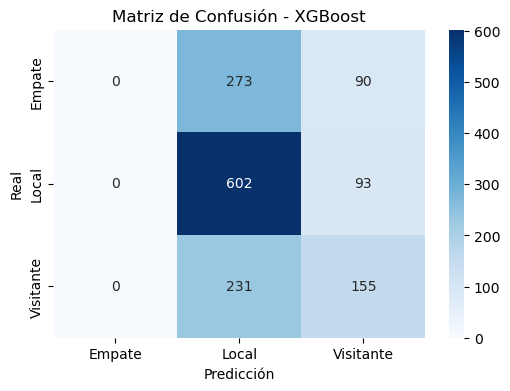

Visitante
Resultado
Local        0.468421
Visitante    0.283380
Empate       0.248199
Name: proportion, dtype: float64
Resultado
Local        3382
Visitante    2046
Empate       1792
Name: count, dtype: int64


In [35]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Cargar todos los CSV y preparar los datos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]

dataframes = []
for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp)
df_final = pd.concat(dataframes, ignore_index=True)

# 2. Crear columna "Resultado"
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'
df_final['Resultado'] = df_final.apply(obtener_resultado, axis=1)

# 3. Calcular goles promedio de Local y Visitante
prom_goles_local = df_final.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df_final.groupby('Visitante')['Goles_Visitante'].mean().to_dict()

df_final['Prom_Goles_Local'] = df_final['Local'].map(prom_goles_local)
df_final['Prom_Goles_Visitante'] = df_final['Visitante'].map(prom_goles_visitante)

# 4. Codificar texto a números
le_equipo = LabelEncoder()
le_resultado = LabelEncoder()

df_final['Local_cod'] = le_equipo.fit_transform(df_final['Local'])
df_final['Visitante_cod'] = le_equipo.transform(df_final['Visitante'])
df_final['Resultado_cod'] = le_resultado.fit_transform(df_final['Resultado'])

# 5. Variables X e y con nuevas features
X = df_final[['Local_cod', 'Visitante_cod', 'Prom_Goles_Local', 'Prom_Goles_Visitante']]
y = df_final['Resultado_cod']

# 6. Separar datos de entrenamiento y prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7. Entrenar modelo con GridSearchCV para XGBoost
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

parametros = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(estimator=xgb,
                    param_grid=parametros,
                    cv=3,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

grid.fit(X_entrenamiento, y_entrenamiento)

print("✅ Mejores hiperparámetros encontrados:")
print(grid.best_params_)

mejor_modelo = grid.best_estimator_
y_pred = mejor_modelo.predict(X_prueba)

print("\n🎯 Accuracy del modelo optimizado:")
print(accuracy_score(y_prueba, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_prueba, y_pred, target_names=le_resultado.classes_))

# 8. Matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_prueba, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le_resultado.classes_, yticklabels=le_resultado.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# 9. Función de predicción actualizada
def predecir_ganador_xgb(equipo_local, equipo_visitante):
    try:
        local_cod = le_equipo.transform([equipo_local])[0]
        visitante_cod = le_equipo.transform([equipo_visitante])[0]
        prom_local = prom_goles_local.get(equipo_local, df_final['Goles_Local'].mean())
        prom_visitante = prom_goles_visitante.get(equipo_visitante, df_final['Goles_Visitante'].mean())
    except ValueError:
        return "Error: Uno o ambos equipos no están en la base de datos."
    
    partido = pd.DataFrame([[local_cod, visitante_cod, prom_local, prom_visitante]],
                          columns=['Local_cod', 'Visitante_cod', 'Prom_Goles_Local', 'Prom_Goles_Visitante'])
    prediccion_cod = mejor_modelo.predict(partido)[0]
    resultado_texto = le_resultado.inverse_transform([prediccion_cod])[0]
    return resultado_texto

# Ejemplo de uso
print(predecir_ganador_xgb('Getafe', 'Barcelona'))
print(df_final['Resultado'].value_counts(normalize=True))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

🎯 Accuracy del modelo optimizado:
0.48545706371191133

📊 Classification Report:
              precision    recall  f1-score   support

      Empate       0.30      0.30      0.30       358
       Local       0.62      0.57      0.60       677
   Visitante       0.44      0.50      0.47       409

    accuracy                           0.49      1444
   macro avg       0.46      0.46      0.46      1444
weighted avg       0.49      0.49      0.49      1444



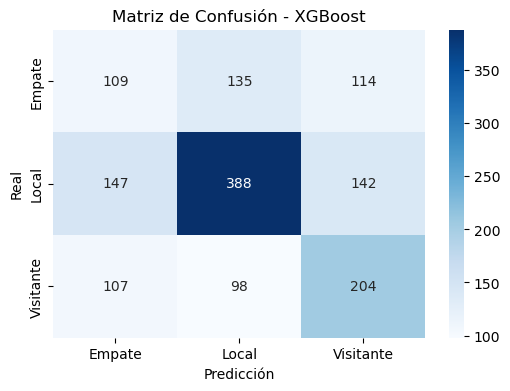

Empate

Distribución real de resultados en dataset:
Resultado
Local        0.468421
Visitante    0.283380
Empate       0.248199
Name: proportion, dtype: float64
Resultado
Local        0.483642
Visitante    0.349929
Empate       0.166430
Name: proportion, dtype: float64
(array([0, 1, 2], dtype=int64), array([363, 621, 460], dtype=int64))


In [55]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE  # <-- Import SMOTE
import numpy as np

# 1. Cargar todos los CSV y preparar los datos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]

dataframes = []
for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp)
df_final = pd.concat(dataframes, ignore_index=True)

# 2. Crear columna "Resultado"
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'
df_final['Resultado'] = df_final.apply(obtener_resultado, axis=1)

# 3. Calcular goles promedio de Local y Visitante
prom_goles_local = df_final.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df_final.groupby('Visitante')['Goles_Visitante'].mean().to_dict()

df_final['Prom_Goles_Local'] = df_final['Local'].map(prom_goles_local)
df_final['Prom_Goles_Visitante'] = df_final['Visitante'].map(prom_goles_visitante)

# 4. Codificar texto a números
le_equipo = LabelEncoder()
le_resultado = LabelEncoder()

df_final['Local_cod'] = le_equipo.fit_transform(df_final['Local'])
df_final['Visitante_cod'] = le_equipo.transform(df_final['Visitante'])
df_final['Resultado_cod'] = le_resultado.fit_transform(df_final['Resultado'])

# 5. Variables X e y con nuevas features
X = df_final[['Local_cod', 'Visitante_cod', 'Prom_Goles_Local', 'Prom_Goles_Visitante']]
y = df_final['Resultado_cod']

# 6. Separar datos de entrenamiento y prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7. Aplicar SMOTE para balancear clases en entrenamiento
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_entrenamiento, y_entrenamiento)

# 8. Entrenar modelo con GridSearchCV para XGBoost usando datos balanceados
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

parametros = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(estimator=xgb,
                    param_grid=parametros,
                    cv=3,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

grid.fit(X_resampled, y_resampled)  # Entrenar con datos balanceados

print("✅ Mejores hiperparámetros encontrados:")
print(grid.best_params_)

mejor_modelo = grid.best_estimator_
y_pred = mejor_modelo.predict(X_prueba)  # Evaluar con datos originales de prueba

print("\n🎯 Accuracy del modelo optimizado:")
print(accuracy_score(y_prueba, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_prueba, y_pred, target_names=le_resultado.classes_))

# 9. Matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_prueba, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le_resultado.classes_, yticklabels=le_resultado.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# 10. Función de predicción actualizada
def predecir_ganador_xgb(equipo_local, equipo_visitante):
    try:
        local_cod = le_equipo.transform([equipo_local])[0]
        visitante_cod = le_equipo.transform([equipo_visitante])[0]
        prom_local = prom_goles_local.get(equipo_local, df_final['Goles_Local'].mean())
        prom_visitante = prom_goles_visitante.get(equipo_visitante, df_final['Goles_Visitante'].mean())
    except ValueError:
        return "Error: Uno o ambos equipos no están en la base de datos."
    
    partido = pd.DataFrame([[local_cod, visitante_cod, prom_local, prom_visitante]],
                          columns=['Local_cod', 'Visitante_cod', 'Prom_Goles_Local', 'Prom_Goles_Visitante'])
    prediccion_cod = mejor_modelo.predict(partido)[0]
    resultado_texto = le_resultado.inverse_transform([prediccion_cod])[0]
    return resultado_texto

# Ejemplo de uso
print(predecir_ganador_xgb('Elche', 'Ath Bilbao'))

# Mostrar distribución real de resultados
print("\nDistribución real de resultados en dataset:")
print(df_final['Resultado'].value_counts(normalize=True))

filtro = (df_final['Local'].isin(['Real Madrid', 'Barcelona'])) | (df_final['Visitante'].isin(['Real Madrid', 'Barcelona']))
df_grandes = df_final[filtro]

print(df_grandes['Resultado'].value_counts(normalize=True))

predicciones = mejor_modelo.predict(X_prueba)
print(np.unique(predicciones, return_counts=True))

In [1]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE  # <-- Import SMOTE
import numpy as np

# 1. Cargar todos los CSV y preparar los datos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]

dataframes = []
for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp)
df_final = pd.concat(dataframes, ignore_index=True)

# 2. Crear columna "Resultado"
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'
df_final['Resultado'] = df_final.apply(obtener_resultado, axis=1)

# 3. Calcular goles promedio de Local y Visitante
prom_goles_local = df_final.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df_final.groupby('Visitante')['Goles_Visitante'].mean().to_dict()

df_final['Prom_Goles_Local'] = df_final['Local'].map(prom_goles_local)
df_final['Prom_Goles_Visitante'] = df_final['Visitante'].map(prom_goles_visitante)

# 4. Codificar texto a números
le_equipo = LabelEncoder()
le_resultado = LabelEncoder()

df_final['Local_cod'] = le_equipo.fit_transform(df_final['Local'])
df_final['Visitante_cod'] = le_equipo.transform(df_final['Visitante'])
df_final['Resultado_cod'] = le_resultado.fit_transform(df_final['Resultado'])

# 5. Variables X e y con nuevas features
X = df_final[['Local_cod', 'Visitante_cod', 'Prom_Goles_Local', 'Prom_Goles_Visitante']]
y = df_final['Resultado_cod']

# 6. Separar datos de entrenamiento y prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 7. Aplicar SMOTE para balancear clases en entrenamiento
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_entrenamiento, y_entrenamiento)

# 8. Entrenar modelo con GridSearchCV para XGBoost usando datos balanceados
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

parametros = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(estimator=xgb,
                    param_grid=parametros,
                    cv=3,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)

grid.fit(X_resampled, y_resampled)  # Entrenar con datos balanceados

print("✅ Mejores hiperparámetros encontrados:")
print(grid.best_params_)

mejor_modelo = grid.best_estimator_
y_pred = mejor_modelo.predict(X_prueba)  # Evaluar con datos originales de prueba

print("\n🎯 Accuracy del modelo optimizado:")
print(accuracy_score(y_prueba, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_prueba, y_pred, target_names=le_resultado.classes_))

# 9. Matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_prueba, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le_resultado.classes_, yticklabels=le_resultado.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# 10. Función de predicción actualizada
def predecir_ganador_xgb(equipo_local, equipo_visitante):
    try:
        local_cod = le_equipo.transform([equipo_local])[0]
        visitante_cod = le_equipo.transform([equipo_visitante])[0]
        prom_local = prom_goles_local.get(equipo_local, df_final['Goles_Local'].mean())
        prom_visitante = prom_goles_visitante.get(equipo_visitante, df_final['Goles_Visitante'].mean())
    except ValueError:
        return "Error: Uno o ambos equipos no están en la base de datos."
    
    partido = pd.DataFrame([[local_cod, visitante_cod, prom_local, prom_visitante]],
                          columns=['Local_cod', 'Visitante_cod', 'Prom_Goles_Local', 'Prom_Goles_Visitante'])
    prediccion_cod = mejor_modelo.predict(partido)[0]
    resultado_texto = le_resultado.inverse_transform([prediccion_cod])[0]
    return resultado_texto

# Ejemplo de uso
print(predecir_ganador_xgb('Real Madrid', 'Barcelona'))

# Mostrar distribución real de resultados
print("\nDistribución real de resultados en dataset:")
print(df_final['Resultado'].value_counts(normalize=True))

filtro = (df_final['Local'].isin(['Real Madrid', 'Barcelona'])) | (df_final['Visitante'].isin(['Real Madrid', 'Barcelona']))
df_grandes = df_final[filtro]

print(df_grandes['Resultado'].value_counts(normalize=True))

predicciones = mejor_modelo.predict(X_prueba)
print(np.unique(predicciones, return_counts=True))
# Filtrar partidos donde juega Barcelona o Real Madrid (como local o visitante)
equipos_objetivo = ['Barcelona', 'Real Madrid']
df_barca_madrid = df_final[
    (df_final['Local'].isin(equipos_objetivo)) |
    (df_final['Visitante'].isin(equipos_objetivo))
].copy()

# Preparar variables necesarias para hacer predicciones
df_barca_madrid['Local_cod'] = le_equipo.transform(df_barca_madrid['Local'])
df_barca_madrid['Visitante_cod'] = le_equipo.transform(df_barca_madrid['Visitante'])

df_barca_madrid['Prom_Goles_Local'] = df_barca_madrid['Local'].map(prom_goles_local)
df_barca_madrid['Prom_Goles_Visitante'] = df_barca_madrid['Visitante'].map(prom_goles_visitante)

# Crear DataFrame de entrada al modelo
X_barca_madrid = df_barca_madrid[['Local_cod', 'Visitante_cod', 'Prom_Goles_Local', 'Prom_Goles_Visitante']]

# Hacer predicciones
df_barca_madrid['Prediccion_cod'] = mejor_modelo.predict(X_barca_madrid)
df_barca_madrid['Prediccion'] = le_resultado.inverse_transform(df_barca_madrid['Prediccion_cod'])

# Resultado real
df_barca_madrid['Resultado_real'] = df_barca_madrid['Resultado']

# Comparar si acertó
df_barca_madrid['Acierto'] = df_barca_madrid['Resultado_real'] == df_barca_madrid['Prediccion']

# Mostrar resultados
#print(df_barca_madrid[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante',
                      #'Resultado_real', 'Prediccion', 'Acierto']])

# Ver tasa de aciertos específicamente en partidos del Barça y Madrid
accuracy_especial = df_barca_madrid['Acierto'].mean()
print(f"\n🎯 Precisión del modelo SOLO en partidos de Barcelona y Real Madrid: {accuracy_especial:.2f}")
df_barca_madrid.to_excel('analisis_barcelona_madrid.xlsx', index=False)

ValueError: No objects to concatenate

Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

🎯 Accuracy del modelo optimizado:
0.49722991689750695

📊 Classification Report:
              precision    recall  f1-score   support

      Empate       0.31      0.27      0.29       358
       Local       0.62      0.60      0.61       677
   Visitante       0.45      0.54      0.49       409

    accuracy                           0.50      1444
   macro avg       0.46      0.47      0.46      1444
weighted avg       0.49      0.50      0.49      1444



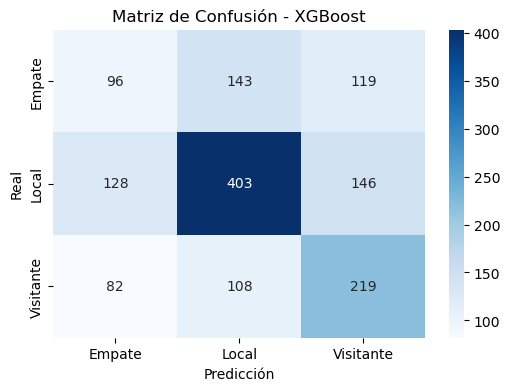

Visitante

🏠 Ranking de fuerza como LOCAL:
Local
Barcelona      2.063712
Real Madrid    1.825485
Ath Madrid     1.171745
Sevilla        0.731302
Villarreal     0.654971
Valencia       0.645429
Ath Bilbao     0.495845
Sociedad       0.453947
Girona         0.336842
Mallorca       0.298246
dtype: float64

🔽 Últimos como LOCAL:
Local
Las Palmas   -0.157895
Granada      -0.163158
Valladolid   -0.210526
Elche        -0.252632
Huesca       -0.263158
Murcia       -0.263158
Cadiz        -0.328947
Xerez        -0.473684
Gimnastic    -0.684211
Cordoba      -1.105263
dtype: float64

🛫 Ranking de fuerza como VISITANTE:
Visitante
Barcelona      1.180055
Real Madrid    0.994460
Ath Madrid     0.279778
Villarreal    -0.102339
Sevilla       -0.180055
Sociedad      -0.319079
Valencia      -0.321330
Girona        -0.326316
Ath Bilbao    -0.365651
Betis         -0.473684
dtype: float64

🔽 Últimos como VISITANTE:
Visitante
Xerez        -1.000000
Sp Gijon     -1.008772
Las Palmas   -1.042105
Granada      -

In [10]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np

# 1. Cargar todos los CSV y preparar los datos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]

dataframes = []
for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp)
df_final = pd.concat(dataframes, ignore_index=True)

# 2. Crear columna "Resultado"
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'
df_final['Resultado'] = df_final.apply(obtener_resultado, axis=1)

# 3. Calcular goles promedio
prom_goles_local = df_final.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df_final.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
df_final['Prom_Goles_Local'] = df_final['Local'].map(prom_goles_local)
df_final['Prom_Goles_Visitante'] = df_final['Visitante'].map(prom_goles_visitante)

goles_marcados_local = df_final.groupby('Local')['Goles_Local'].mean()
goles_recibidos_local = df_final.groupby('Local')['Goles_Visitante'].mean()
fuerza_equipo_local = goles_marcados_local - goles_recibidos_local

# Goles marcados y recibidos como visitante
goles_marcados_visitante = df_final.groupby('Visitante')['Goles_Visitante'].mean()
goles_recibidos_visitante = df_final.groupby('Visitante')['Goles_Local'].mean()
fuerza_equipo_visitante = goles_marcados_visitante - goles_recibidos_visitante

# Mapear la fuerza a cada partido
df_final['Fuerza_Local'] = df_final['Local'].map(fuerza_equipo_local)
df_final['Fuerza_Visitante'] = df_final['Visitante'].map(fuerza_equipo_visitante)

# 4. One-Hot Encoding para equipos
equipos_onehot = pd.get_dummies(df_final[['Local', 'Visitante']], prefix=['Loc', 'Vis'])
df_final = pd.concat([df_final, equipos_onehot], axis=1)

# 5. Calcular puntos promedio por equipo (fuerza)
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1
df_final[['Puntos_Local', 'Puntos_Visitante']] = df_final.apply(puntos, axis=1, result_type='expand')
prom_puntos_local = df_final.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df_final.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()
df_final['Fuerza_Local'] = df_final['Local'].map(prom_puntos_local)
df_final['Fuerza_Visitante'] = df_final['Visitante'].map(prom_puntos_visitante)

# 6. Variables X e y
X = df_final[['Local_cod', 'Visitante_cod', 'Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante']]
y = df_final['Resultado_cod']

# 7. Separar datos
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Balancear con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_entrenamiento, y_entrenamiento)

# 9. Entrenar modelo con GridSearchCV
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
parametros = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
grid = GridSearchCV(estimator=xgb,
                    param_grid=parametros,
                    cv=3,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)
grid.fit(X_resampled, y_resampled)

print("✅ Mejores hiperparámetros encontrados:")
print(grid.best_params_)

# 10. Evaluación
mejor_modelo = grid.best_estimator_
y_pred = mejor_modelo.predict(X_prueba)

print("\n🎯 Accuracy del modelo optimizado:")
print(accuracy_score(y_prueba, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_prueba, y_pred, target_names=le_resultado.classes_))

# 11. Matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_prueba, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le_resultado.classes_, yticklabels=le_resultado.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

# 12. Función de predicción actualizada
def predecir_ganador_xgb(equipo_local, equipo_visitante):
    try:
        local_cod = le_equipo.transform([equipo_local])[0]
        visitante_cod = le_equipo.transform([equipo_visitante])[0]
        prom_local = prom_goles_local.get(equipo_local, df_final['Goles_Local'].mean())
        prom_visitante = prom_goles_visitante.get(equipo_visitante, df_final['Goles_Visitante'].mean())
        fuerza_local = prom_puntos_local.get(equipo_local, 1.5)
        fuerza_visitante = prom_puntos_visitante.get(equipo_visitante, 1.5)
    except ValueError:
        return "Error: Uno o ambos equipos no están en la base de datos."

    partido = pd.DataFrame([[local_cod, visitante_cod, prom_local, prom_visitante, fuerza_local, fuerza_visitante]],
                           columns=['Local_cod', 'Visitante_cod', 'Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante'])
    prediccion_cod = mejor_modelo.predict(partido)[0]
    resultado_texto = le_resultado.inverse_transform([prediccion_cod])[0]
    return resultado_texto

# 🔍 Ejemplo de uso
print(predecir_ganador_xgb('Real Madrid', 'Barcelona'))

# 🔽 Ranking de fuerza de equipos

# Ordenar de mayor a menor fuerza local
ranking_local = fuerza_equipo_local.sort_values(ascending=False)
print("\n🏠 Ranking de fuerza como LOCAL:")
print(ranking_local.head(10))  # Top 10 equipos locales
print("\n🔽 Últimos como LOCAL:")
print(ranking_local.tail(10))  # Peores 10 locales

# Ordenar de mayor a menor fuerza visitante
ranking_visitante = fuerza_equipo_visitante.sort_values(ascending=False)
print("\n🛫 Ranking de fuerza como VISITANTE:")
print(ranking_visitante.head(10))  # Top 10 visitantes
print("\n🔽 Últimos como VISITANTE:")
print(ranking_visitante.tail(10))  # Peores 10 visitantes

def mostrar_estadisticas_equipo(equipo):
    print(f"\n📊 Estadísticas para: {equipo}")

    # Promedios de goles
    prom_local = prom_goles_local.get(equipo, "No disponible")
    prom_visit = prom_goles_visitante.get(equipo, "No disponible")

    # Fuerza ofensiva-defensiva
    fuerza_loc = fuerza_equipo_local.get(equipo, "No disponible")
    fuerza_vis = fuerza_equipo_visitante.get(equipo, "No disponible")

    print(f"⚽ Promedio de goles como LOCAL: {prom_local}")
    print(f"⚽ Promedio de goles como VISITANTE: {prom_visit}")
    print(f"💪 Fuerza como LOCAL (goles marcados - recibidos): {fuerza_loc}")
    print(f"💪 Fuerza como VISITANTE (goles marcados - recibidos): {fuerza_vis}")
mostrar_estadisticas_equipo('Gimnastic')

In [14]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np

# 1. Cargar todos los CSV y preparar los datos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]

dataframes = []
for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp)
df_final = pd.concat(dataframes, ignore_index=True)

# 2. Crear columna "Resultado"
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'
df_final['Resultado'] = df_final.apply(obtener_resultado, axis=1)

# Codificar el resultado
le_resultado = LabelEncoder()
df_final['Resultado_cod'] = le_resultado.fit_transform(df_final['Resultado'])

# 3. Calcular goles promedio
prom_goles_local = df_final.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df_final.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
df_final['Prom_Goles_Local'] = df_final['Local'].map(prom_goles_local)
df_final['Prom_Goles_Visitante'] = df_final['Visitante'].map(prom_goles_visitante)

goles_marcados_local = df_final.groupby('Local')['Goles_Local'].mean()
goles_recibidos_local = df_final.groupby('Local')['Goles_Visitante'].mean()
fuerza_equipo_local = goles_marcados_local - goles_recibidos_local

# Goles marcados y recibidos como visitante
goles_marcados_visitante = df_final.groupby('Visitante')['Goles_Visitante'].mean()
goles_recibidos_visitante = df_final.groupby('Visitante')['Goles_Local'].mean()
fuerza_equipo_visitante = goles_marcados_visitante - goles_recibidos_visitante

# Mapear la fuerza a cada partido
df_final['Fuerza_Local'] = df_final['Local'].map(fuerza_equipo_local)
df_final['Fuerza_Visitante'] = df_final['Visitante'].map(fuerza_equipo_visitante)

# 4. One-Hot Encoding para equipos
equipos_onehot = pd.get_dummies(df_final[['Local', 'Visitante']], prefix=['Loc', 'Vis'])
df_final = pd.concat([df_final, equipos_onehot], axis=1)

# 5. Calcular puntos promedio por equipo (fuerza)
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1
df_final[['Puntos_Local', 'Puntos_Visitante']] = df_final.apply(puntos, axis=1, result_type='expand')
prom_puntos_local = df_final.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df_final.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()
df_final['Fuerza_Local'] = df_final['Local'].map(prom_puntos_local)
df_final['Fuerza_Visitante'] = df_final['Visitante'].map(prom_puntos_visitante)

# 6. Variables X e y con One-Hot
columnas_onehot = [col for col in df_final.columns if col.startswith('Loc_') or col.startswith('Vis_')]
X = df_final[columnas_onehot + ['Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante']]
y = df_final['Resultado_cod']

# 7. Separar datos
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8. Balancear con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_entrenamiento, y_entrenamiento)

# 9. Entrenar modelo con GridSearchCV
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
parametros = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
grid = GridSearchCV(estimator=xgb,
                    param_grid=parametros,
                    cv=3,
                    scoring='accuracy',
                    verbose=1,
                    n_jobs=-1)
grid.fit(X_resampled, y_resampled)

print("✅ Mejores hiperparámetros encontrados:")
print(grid.best_params_)

# 10. Evaluación
mejor_modelo = grid.best_estimator_
y_pred = mejor_modelo.predict(X_prueba)

print("\n🎯 Accuracy del modelo optimizado (con One-Hot):")
print(accuracy_score(y_prueba, y_pred))

print("\n📊 Classification Report:")
print(classification_report(y_prueba, y_pred, target_names=le_resultado.classes_))
def predecir_ganador_onehot(local, visitante):
    # Crear base para el partido
    columnas_modelo = X.columns
    partido = pd.DataFrame([np.zeros(len(columnas_modelo))], columns=columnas_modelo)

    # Marcar 1 en columnas one-hot correspondientes
    loc_col = f'Loc_{local}'
    vis_col = f'Vis_{visitante}'

    if loc_col in partido.columns:
        partido[loc_col] = 1
    if vis_col in partido.columns:
        partido[vis_col] = 1

    # Asignar valores estadísticos
    partido['Prom_Goles_Local'] = prom_goles_local.get(local, df_final['Goles_Local'].mean())
    partido['Prom_Goles_Visitante'] = prom_goles_visitante.get(visitante, df_final['Goles_Visitante'].mean())
    partido['Fuerza_Local'] = prom_puntos_local.get(local, 1.5)
    partido['Fuerza_Visitante'] = prom_puntos_visitante.get(visitante, 1.5)

    prediccion = mejor_modelo.predict(partido)[0]
    return le_resultado.inverse_transform([prediccion])[0]

# Repetir la predicción 100 veces
equipo_local = 'Real Madrid'
equipo_visitante = 'Barcelona'

resultados = [predecir_ganador_onehot(equipo_local, equipo_visitante) for _ in range(100)]
conteo = Counter(resultados)

print(f"\n🔁 Predicciones con One-Hot para {equipo_local} vs {equipo_visitante} (100 repeticiones):")
for resultado, cantidad in conteo.items():
    print(f"➡️ {resultado}: {cantidad} veces")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

🎯 Accuracy del modelo optimizado (con One-Hot):
0.481994459833795

📊 Classification Report:
              precision    recall  f1-score   support

      Empate       0.28      0.22      0.25       358
       Local       0.60      0.60      0.60       677
   Visitante       0.43      0.52      0.47       409

    accuracy                           0.48      1444
   macro avg       0.44      0.45      0.44      1444
weighted avg       0.47      0.48      0.48      1444


🔁 Predicciones con One-Hot para Real Madrid vs Barcelona (100 repeticiones):
➡️ Visitante: 100 veces


Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Mejores hiperparámetros:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

🎯 Accuracy solo con estadísticas:
0.49238227146814406

📊 Classification Report:
              precision    recall  f1-score   support

       Local       0.63      0.59      0.61       677
      Empate       0.28      0.25      0.26       358
   Visitante       0.44      0.55      0.49       409

    accuracy                           0.49      1444
   macro avg       0.45      0.46      0.45      1444
weighted avg       0.49      0.49      0.49      1444



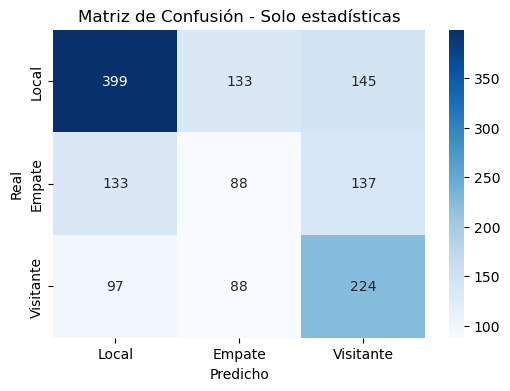


🔁 Predicciones SOLO con estadísticas para Barcelona vs Getafe:
➡️ Local: 100 veces


In [19]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Cargar y preparar los datos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                            'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}, inplace=True)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)
# Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'
df['Resultado'] = df.apply(obtener_resultado, axis=1)

# Promedios y fuerzas
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)

def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1
df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

# Codificar la variable objetivo
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

# Variables numéricas como features
X = df[['Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante']]
y = df['Resultado_cod']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE para balanceo
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# XGBoost con GridSearchCV
parametros = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(estimator=xgb, param_grid=parametros, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_resampled, y_resampled)

print("✅ Mejores hiperparámetros:")
print(grid.best_params_)

# Evaluación
mejor_modelo = grid.best_estimator_
y_pred = mejor_modelo.predict(X_test)
print("\n🎯 Accuracy solo con estadísticas:")
print(accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Local', 'Empate', 'Visitante']))

# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=['Local', 'Empate', 'Visitante'],
            yticklabels=['Local', 'Empate', 'Visitante'],
            cmap='Blues')
plt.title("Matriz de Confusión - Solo estadísticas")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Función de predicción (sin codificar equipos)
def predecir_solo_estadisticas(local, visitante):
    prom_local = prom_goles_local.get(local, df['Goles_Local'].mean())
    prom_vis = prom_goles_visitante.get(visitante, df['Goles_Visitante'].mean())
    fuerza_loc = prom_puntos_local.get(local, 1.5)
    fuerza_vis = prom_puntos_visitante.get(visitante, 1.5)

    entrada = pd.DataFrame([[prom_local, prom_vis, fuerza_loc, fuerza_vis]],
                           columns=['Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante'])
    pred_cod = mejor_modelo.predict(entrada)[0]
    return ['Local', 'Empate', 'Visitante'][pred_cod]
# 🔁 Probar con 100 repeticiones
from collections import Counter

equipo_local = 'Barcelona'
equipo_visitante = 'Getafe'
resultados = [predecir_solo_estadisticas(equipo_local, equipo_visitante) for _ in range(100)]
conteo = Counter(resultados)

print(f"\n🔁 Predicciones SOLO con estadísticas para {equipo_local} vs {equipo_visitante}:")
for resultado, cantidad in conteo.items():
    print(f"➡️ {resultado}: {cantidad} veces")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Mejores hiperparámetros:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

🎯 Accuracy con estadísticas + H2H:
0.5948753462603878

📊 Classification Report:
              precision    recall  f1-score   support

       Local       0.75      0.59      0.66       677
      Empate       0.46      0.57      0.50       358
   Visitante       0.55      0.63      0.59       409

    accuracy                           0.59      1444
   macro avg       0.59      0.60      0.58      1444
weighted avg       0.62      0.59      0.60      1444



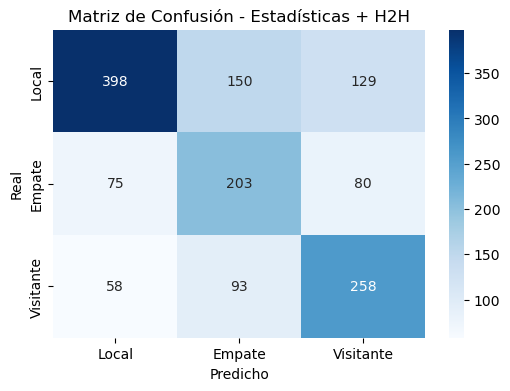


🔁 Predicciones con estadísticas + H2H para fjsfjsfsjsfdj vs Almeria:
➡️ Empate: 100 veces


In [4]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# -----------------------------
# 1. Cargar y preparar los datos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                            'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}, inplace=True)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

# Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'
df['Resultado'] = df.apply(obtener_resultado, axis=1)

# -----------------------------
# 2. Función para calcular estadísticas head-to-head
def head_to_head_stats(df):
    h2h = {}
    # Para cada pareja (Local, Visitante) calculamos wins, draws, losses del local
    grouped = df.groupby(['Local', 'Visitante'])
    for (local, visitante), group in grouped:
        total = len(group)
        wins_local = sum(group['Resultado'] == 'Local') / total
        draws = sum(group['Resultado'] == 'Empate') / total
        wins_visit = sum(group['Resultado'] == 'Visitante') / total
        h2h[(local, visitante)] = (wins_local, draws, wins_visit)
    return h2h

h2h = head_to_head_stats(df)

# Funciones para mapear esas estadísticas en el DataFrame
def get_h2h_wins_local(row):
    return h2h.get((row['Local'], row['Visitante']), (0.33, 0.33, 0.33))[0]

def get_h2h_draws(row):
    return h2h.get((row['Local'], row['Visitante']), (0.33, 0.33, 0.33))[1]

def get_h2h_wins_visit(row):
    return h2h.get((row['Local'], row['Visitante']), (0.33, 0.33, 0.33))[2]

df['H2H_Wins_Local'] = df.apply(get_h2h_wins_local, axis=1)
df['H2H_Draws'] = df.apply(get_h2h_draws, axis=1)
df['H2H_Wins_Visitante'] = df.apply(get_h2h_wins_visit, axis=1)

# -----------------------------
# 3. Promedios y fuerzas (como ya tenías)
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)


def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1
df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

# -----------------------------
# 4. Codificar variable objetivo
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

# -----------------------------
# 5. Definir variables predictoras incluyendo H2H
features = ['Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
            'H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante']

X = df[features]
y = df['Resultado_cod']

# -----------------------------
# 6. Train/test split y SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# -----------------------------
# 7. Entrenar XGBoost con GridSearchCV
parametros = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(estimator=xgb, param_grid=parametros, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_resampled, y_resampled)

print("✅ Mejores hiperparámetros:")
print(grid.best_params_)

# -----------------------------
# 8. Evaluación
mejor_modelo = grid.best_estimator_
y_pred = mejor_modelo.predict(X_test)
print("\n🎯 Accuracy con estadísticas + H2H:")
print(accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Local', 'Empate', 'Visitante']))

# Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=['Local', 'Empate', 'Visitante'],
            yticklabels=['Local', 'Empate', 'Visitante'],
            cmap='Blues')
plt.title("Matriz de Confusión - Estadísticas + H2H")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# -----------------------------
# 9. Función de predicción con H2H (sin codificar equipos)
def predecir_con_h2h(local, visitante):
    prom_local = prom_goles_local.get(local, df['Goles_Local'].mean())
    prom_vis = prom_goles_visitante.get(visitante, df['Goles_Visitante'].mean())
    fuerza_loc = prom_puntos_local.get(local, 1.5)
    fuerza_vis = prom_puntos_visitante.get(visitante, 1.5)
    h2h_vals = h2h.get((local, visitante), (0.33, 0.33, 0.33))

    entrada = pd.DataFrame([[prom_local, prom_vis, fuerza_loc, fuerza_vis,
                             h2h_vals[0], h2h_vals[1], h2h_vals[2]]],
                           columns=features)
    pred_cod = mejor_modelo.predict(entrada)[0]
    return ['Local', 'Empate', 'Visitante'][pred_cod]

from collections import Counter
equipo_local = 'fjsfjsfsjsfdj'
equipo_visitante = 'Almeria'
resultados = [predecir_con_h2h(equipo_local, equipo_visitante) for _ in range(100)]
conteo = Counter(resultados)

print(f"\n🔁 Predicciones con estadísticas + H2H para {equipo_local} vs {equipo_visitante}:")
for resultado, cantidad in conteo.items():
    print(f"➡️ {resultado}: {cantidad} veces")

In [26]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import difflib

# -----------------------------
# FUNCIONES DE NORMALIZACIÓN Y UTILIDADES

def normalizar_datos(df):
    df.columns = [col.strip() for col in df.columns]
    if 'HomeTeam' in df.columns and 'AwayTeam' in df.columns:
        df.rename(columns={'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                           'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}, inplace=True)
    df['Local'] = df['Local'].str.strip().str.title()
    df['Visitante'] = df['Visitante'].str.strip().str.title()
    return df

def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

# -----------------------------
# CARGA DE DATOS GENERALES
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp = normalizar_datos(df_temp)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)
df['Resultado'] = df.apply(obtener_resultado, axis=1)

# -----------------------------
# HEAD TO HEAD
def head_to_head_stats(df):
    h2h = {}
    grouped = df.groupby(['Local', 'Visitante'])
    for (local, visitante), group in grouped:
        total = len(group)
        wins_local = sum(group['Resultado'] == 'Local') / total
        draws = sum(group['Resultado'] == 'Empate') / total
        wins_visit = sum(group['Resultado'] == 'Visitante') / total
        h2h[(local, visitante)] = (wins_local, draws, wins_visit)
    return h2h

h2h = head_to_head_stats(df)

def get_h2h_wins_local(row):
    return h2h.get((row['Local'], row['Visitante']), (0.33, 0.33, 0.33))[0]

def get_h2h_draws(row):
    return h2h.get((row['Local'], row['Visitante']), (0.33, 0.33, 0.33))[1]

def get_h2h_wins_visit(row):
    return h2h.get((row['Local'], row['Visitante']), (0.33, 0.33, 0.33))[2]

df['H2H_Wins_Local'] = df.apply(get_h2h_wins_local, axis=1)
df['H2H_Draws'] = df.apply(get_h2h_draws, axis=1)
df['H2H_Wins_Visitante'] = df.apply(get_h2h_wins_visit, axis=1)

# -----------------------------
# PROMEDIOS Y FUERZAS
df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

# -----------------------------
# INCLUIR DATOS DEL REAL OVIEDO
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp = normalizar_datos(df_oviedo_temp)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)
    else:
        print(f"⚠️ Archivo ignorado (faltan columnas): {archivo}")

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)
# --- 🔤 Normalizar nombres del Real Oviedo ---
df_oviedo['Local'] = df_oviedo['Local'].str.strip()
df_oviedo['Visitante'] = df_oviedo['Visitante'].str.strip()
# Reemplazar variantes del nombre
df_oviedo['Local'] = df_oviedo['Local'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})
df_oviedo['Visitante'] = df_oviedo['Visitante'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})

df_oviedo['Resultado'] = df_oviedo.apply(obtener_resultado, axis=1)
df_oviedo[['Puntos_Local', 'Puntos_Visitante']] = df_oviedo.apply(puntos, axis=1, result_type='expand')

oviedo_local = df_oviedo[df_oviedo['Local'] == 'Real Oviedo']
oviedo_visitante = df_oviedo[df_oviedo['Visitante'] == 'Real Oviedo']
estadisticas_oviedo = {
    'Prom_Goles_Local': oviedo_local['Goles_Local'].mean(),
    'Prom_Goles_Visitante': oviedo_visitante['Goles_Visitante'].mean(),
    'Fuerza_Local': oviedo_local['Puntos_Local'].mean(),
    'Fuerza_Visitante': oviedo_visitante['Puntos_Visitante'].mean()
}
prom_goles_local['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Local']
prom_goles_visitante['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Visitante']
prom_puntos_local['Real Oviedo'] = estadisticas_oviedo['Fuerza_Local']
prom_puntos_visitante['Real Oviedo'] = estadisticas_oviedo['Fuerza_Visitante']

# -----------------------------
# ENTRENAMIENTO DEL MODELO
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})
features = ['Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
            'H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante']
X = df[features]
y = df['Resultado_cod']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

parametros = {
    'n_estimators': [100],
    'max_depth': [5],
    'learning_rate': [0.1],
    'subsample': [0.8]
}
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(estimator=xgb, param_grid=parametros, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_resampled, y_resampled)

mejor_modelo = grid.best_estimator_
y_pred = mejor_modelo.predict(X_test)
print("\n🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Local', 'Empate', 'Visitante']))

# -----------------------------
# PREDICCIÓN CON VALIDACIÓN Y AUTOCOMPLETADO

todos_equipos = set(list(prom_goles_local.keys()) + list(prom_goles_visitante.keys()))

def sugerencias_equipo(nombre):
    similares = difflib.get_close_matches(nombre.title(), todos_equipos, n=3, cutoff=0.6)
    return similares

def predecir_con_h2h(local, visitante):
    local = local.strip().title()
    visitante = visitante.strip().title()

    if local not in prom_goles_local:
        sugerencias = sugerencias_equipo(local)
        raise ValueError(f"⚠️ Equipo local '{local}' no encontrado. ¿Quizás quisiste decir: {sugerencias}?")
    if visitante not in prom_goles_visitante:
        sugerencias = sugerencias_equipo(visitante)
        raise ValueError(f"⚠️ Equipo visitante '{visitante}' no encontrado. ¿Quizás quisiste decir: {sugerencias}?")

    entrada = pd.DataFrame([[
        prom_goles_local[local],
        prom_goles_visitante[visitante],
        prom_puntos_local[local],
        prom_puntos_visitante[visitante],
        *h2h.get((local, visitante), (0.33, 0.33, 0.33))
    ]], columns=features)

    pred_cod = mejor_modelo.predict(entrada)[0]
    return ['Local', 'Empate', 'Visitante'][pred_cod]

# -----------------------------
# EJEMPLO DE PREDICCIÓN

equipo_local = 'Real Oviedo'     # prueba con errores
equipo_visitante = 'Getafe'

try:
    resultados = [predecir_con_h2h(equipo_local, equipo_visitante) for _ in range(100)]
    conteo = Counter(resultados)
    print(f"\n🔁 Predicciones para {equipo_local} vs {equipo_visitante}:")
    for resultado, cantidad in conteo.items():
        print(f"➡️ {resultado}: {cantidad} veces")
except ValueError as e:
    print(str(e))


🎯 Accuracy: 0.5650969529085873

📊 Classification Report:
              precision    recall  f1-score   support

       Local       0.71      0.61      0.65       677
      Empate       0.41      0.45      0.43       358
   Visitante       0.52      0.60      0.56       409

    accuracy                           0.57      1444
   macro avg       0.55      0.55      0.55      1444
weighted avg       0.58      0.57      0.57      1444


🔁 Predicciones para Real Oviedo vs Getafe:
➡️ Empate: 100 veces


In [48]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. Cargar datos históricos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                            'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}, inplace=True)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 2. Agregar columna de resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 3. H2H y marcador si existe
def head_to_head_stats(df):
    h2h = {}
    grouped = df.groupby(['Local', 'Visitante'])
    for (local, visitante), group in grouped:
        total = len(group)
        wins_local = sum(group['Resultado'] == 'Local') / total
        draws = sum(group['Resultado'] == 'Empate') / total
        wins_visit = sum(group['Resultado'] == 'Visitante') / total
        h2h[(local, visitante)] = (wins_local, draws, wins_visit)
    return h2h

h2h = head_to_head_stats(df)

def get_h2h_values(row):
    val = h2h.get((row['Local'], row['Visitante']), (None, None, None))
    return pd.Series([*val])

df[['H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante']] = df.apply(get_h2h_values, axis=1)
df['Tiene_H2H'] = df['H2H_Wins_Local'].notna().astype(int)
df.fillna({'H2H_Wins_Local': 0, 'H2H_Draws': 0, 'H2H_Wins_Visitante': 0}, inplace=True)

# ----------------------------------------
# 4. Estadísticas por equipo
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

# ----------------------------------------
# 5. Datos Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# --- 🔤 Normalizar nombres del Real Oviedo ---
df_oviedo['Local'] = df_oviedo['Local'].str.strip()
df_oviedo['Visitante'] = df_oviedo['Visitante'].str.strip()

# Reemplazar variantes del nombre
df_oviedo['Local'] = df_oviedo['Local'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})
df_oviedo['Visitante'] = df_oviedo['Visitante'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})

df_oviedo['Resultado'] = df_oviedo.apply(obtener_resultado, axis=1)
df_oviedo[['Puntos_Local', 'Puntos_Visitante']] = df_oviedo.apply(puntos, axis=1, result_type='expand')

# Estadísticas del Oviedo
oviedo_local = df_oviedo[df_oviedo['Local'] == 'Real Oviedo']
oviedo_visitante = df_oviedo[df_oviedo['Visitante'] == 'Real Oviedo']
estadisticas_oviedo = {
    'Prom_Goles_Local': oviedo_local['Goles_Local'].mean(),
    'Prom_Goles_Visitante': oviedo_visitante['Goles_Visitante'].mean(),
    'Fuerza_Local': oviedo_local['Puntos_Local'].mean(),
    'Fuerza_Visitante': oviedo_visitante['Puntos_Visitante'].mean()
}

# 💡 Aplicar pequeño 'handicap' al Real Oviedo por venir de Segunda División
penalizacion_goles = 0.9      # 10% menos
penalizacion_fuerza = 0.95    # 5% menos

# Aplicar penalización
prom_goles_local['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Local'] * penalizacion_goles
prom_goles_visitante['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Visitante'] * penalizacion_goles
prom_puntos_local['Real Oviedo'] = estadisticas_oviedo['Fuerza_Local'] * penalizacion_fuerza
prom_puntos_visitante['Real Oviedo'] = estadisticas_oviedo['Fuerza_Visitante'] * penalizacion_fuerza

# ----------------------------------------
# 6. Codificar resultado y preparar X/y
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

features = ['Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
            'H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante', 'Tiene_H2H']

X = df[features]
y = df['Resultado_cod']

# ----------------------------------------
# 7. Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [50],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [1.0]
}

modelo = XGBClassifier(eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)
grid.fit(X_resampled, y_resampled)
mejor_modelo = grid.best_estimator_

# ----------------------------------------
# 8. Evaluación
y_pred = mejor_modelo.predict(X_test)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Local', 'Empate', 'Visitante']))

# 9. Funciones de sugerencia y predicción con verificación inteligente

from difflib import get_close_matches

# Lista de equipos conocidos (construida a partir de los datos ya cargados)
todos_los_equipos = set(df['Local']).union(df['Visitante'])

def sugerir_equipo(nombre):
    """Sugiere nombres de equipo similares si el ingresado no está en los datos."""
    sugerencias = get_close_matches(nombre, todos_los_equipos, n=3, cutoff=0.6)
    return sugerencias if sugerencias else None

def predecir_con_h2h(local, visitante):
    """Predice el resultado entre dos equipos con verificación y sugerencias."""
    errores = []
    if local not in prom_goles_local:
        sugerencias = sugerir_equipo(local)
        if sugerencias:
            raise ValueError(f"⚠️ El equipo local '{local}' no existe. ¿Quizás quiso decir: {sugerencias}?")
        else:
            raise ValueError(f"⚠️ El equipo local '{local}' no existe y no se encontraron sugerencias. Vuelva a intentarlo.")
    
    if visitante not in prom_goles_visitante:
        sugerencias = sugerir_equipo(visitante)
        if sugerencias:
            raise ValueError(f"⚠️ El equipo visitante '{visitante}' no existe. ¿Quizás quiso decir: {sugerencias}?")
        else:
            raise ValueError(f"⚠️ El equipo visitante '{visitante}' no existe y no se encontraron sugerencias. Vuelva a intentarlo.")

    entrada = pd.DataFrame([[
        prom_goles_local[local],
        prom_goles_visitante[visitante],
        prom_puntos_local[local],
        prom_puntos_visitante[visitante],
        *h2h.get((local, visitante), (0.33, 0.33, 0.33)),
        int((local, visitante) in h2h)
    ]], columns=features)

    pred_cod = mejor_modelo.predict(entrada)[0]
    return ['Local', 'Empate', 'Visitante'][pred_cod]
# ----------------------------------------
# 9. Predicción con detección de equipos desconocidos
def predecir_con_h2h(local, visitante):
    if local not in prom_goles_local or visitante not in prom_goles_visitante:
        raise ValueError(f"⚠️ Uno o ambos equipos no existen: '{local}' o '{visitante}'")
    
    entrada = pd.DataFrame([[
        prom_goles_local[local],
        prom_goles_visitante[visitante],
        prom_puntos_local[local],
        prom_puntos_visitante[visitante],
        *h2h.get((local, visitante), (0, 0, 0)),
        int((local, visitante) in h2h)
    ]], columns=features)
    
    pred_cod = mejor_modelo.predict(entrada)[0]
    return ['Local', 'Empate', 'Visitante'][pred_cod]

# Ejemplo
local = "Real Oviedo"
visitante = "Real Madrid"
resultados = [predecir_con_h2h(local, visitante) for _ in range(100)]
conteo = Counter(resultados)

print(f"\n🔁 Predicciones simuladas para {local} vs {visitante}:")
for resultado, cantidad in conteo.items():
    print(f"➡️ {resultado}: {cantidad} veces")

print("📉 Estadísticas Real Oviedo con handicap aplicado:")
print(f"Goles Local: {prom_goles_local['Real Oviedo']:.2f}")
print(f"Goles Visitante: {prom_goles_visitante['Real Oviedo']:.2f}")
print(f"Fuerza Local: {prom_puntos_local['Real Oviedo']:.2f}")
print(f"Fuerza Visitante: {prom_puntos_visitante['Real Oviedo']:.2f}")

🔍 Accuracy: 0.5969529085872576

📊 Classification Report:
              precision    recall  f1-score   support

       Local       0.75      0.58      0.66       677
      Empate       0.46      0.56      0.51       358
   Visitante       0.55      0.65      0.60       409

    accuracy                           0.60      1444
   macro avg       0.59      0.60      0.59      1444
weighted avg       0.62      0.60      0.60      1444


🔁 Predicciones simuladas para Real Oviedo vs Real Madrid:
➡️ Local: 100 veces
📉 Estadísticas Real Oviedo con handicap aplicado:
Goles Local: 1.28
Goles Visitante: 0.85
Fuerza Local: 1.78
Fuerza Visitante: 1.02


In [37]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. Cargar datos históricos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                            'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}, inplace=True)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

# ---------------------------------------------------------
# Añadir clasificación de equipos: Primera o Segunda División
equipos_primera = {
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta","Elche", "Espanol","Getafe","Girona","Levante","Mallorca","Osasuna",
    "Real Madrid","Sevilla","Sociedad","Valencia","Vallecano","Villarreal"
    # Asegúrate de ajustar esta lista según tus equipos reales
}

# Nueva columna binaria: 1 si ambos equipos son de Primera División, 0 si hay algún Segunda
def categoria_equipo(row):
    local_es_primera = row['Local'] in equipos_primera
    visitante_es_primera = row['Visitante'] in equipos_primera
    return int(local_es_primera and visitante_es_primera)

df['Categoria_Equipo'] = df.apply(categoria_equipo, axis=1)


# 2. Agregar columna de resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 3. H2H y marcador si existe
def head_to_head_stats(df):
    h2h = {}
    grouped = df.groupby(['Local', 'Visitante'])
    for (local, visitante), group in grouped:
        total = len(group)
        wins_local = sum(group['Resultado'] == 'Local') / total
        draws = sum(group['Resultado'] == 'Empate') / total
        wins_visit = sum(group['Resultado'] == 'Visitante') / total
        h2h[(local, visitante)] = (wins_local, draws, wins_visit)
    return h2h

h2h = head_to_head_stats(df)

def get_h2h_values(row):
    val = h2h.get((row['Local'], row['Visitante']), (None, None, None))
    return pd.Series([*val])

df[['H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante']] = df.apply(get_h2h_values, axis=1)
df['Tiene_H2H'] = df['H2H_Wins_Local'].notna().astype(int)
df.fillna({'H2H_Wins_Local': 0, 'H2H_Draws': 0, 'H2H_Wins_Visitante': 0}, inplace=True)

# ----------------------------------------
# 4. Estadísticas por equipo
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

# ----------------------------------------
# 5. Datos Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# --- 🔤 Normalizar nombres del Real Oviedo ---
df_oviedo['Local'] = df_oviedo['Local'].str.strip()
df_oviedo['Visitante'] = df_oviedo['Visitante'].str.strip()

# Reemplazar variantes del nombre
df_oviedo['Local'] = df_oviedo['Local'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})
df_oviedo['Visitante'] = df_oviedo['Visitante'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})

df_oviedo['Resultado'] = df_oviedo.apply(obtener_resultado, axis=1)
df_oviedo[['Puntos_Local', 'Puntos_Visitante']] = df_oviedo.apply(puntos, axis=1, result_type='expand')

# Estadísticas del Oviedo
oviedo_local = df_oviedo[df_oviedo['Local'] == 'Real Oviedo']
oviedo_visitante = df_oviedo[df_oviedo['Visitante'] == 'Real Oviedo']
estadisticas_oviedo = {
    'Prom_Goles_Local': oviedo_local['Goles_Local'].mean(),
    'Prom_Goles_Visitante': oviedo_visitante['Goles_Visitante'].mean(),
    'Fuerza_Local': oviedo_local['Puntos_Local'].mean(),
    'Fuerza_Visitante': oviedo_visitante['Puntos_Visitante'].mean()
}

# 💡 Aplicar pequeño 'handicap' al Real Oviedo por venir de Segunda División
penalizacion_goles = 0.9      # 10% menos
penalizacion_fuerza = 0.95    # 5% menos

# Aplicar penalización
prom_goles_local['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Local'] * penalizacion_goles
prom_goles_visitante['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Visitante'] * penalizacion_goles
prom_puntos_local['Real Oviedo'] = estadisticas_oviedo['Fuerza_Local'] * penalizacion_fuerza
prom_puntos_visitante['Real Oviedo'] = estadisticas_oviedo['Fuerza_Visitante'] * penalizacion_fuerza

# ----------------------------------------
# 6. Codificar resultado y preparar X/y
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

features = ['Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
            'H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante', 'Categoria_Equipo']

X = df[features]
y = df['Resultado_cod']

# ----------------------------------------
# 7. Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [50],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [1.0]
}

modelo = XGBClassifier(eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)
grid.fit(X_resampled, y_resampled)
mejor_modelo = grid.best_estimator_

# ----------------------------------------
# 8. Evaluación
y_pred = mejor_modelo.predict(X_test)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Local', 'Empate', 'Visitante']))

# 9. Funciones de sugerencia y predicción con verificación inteligente

from difflib import get_close_matches

# Lista de equipos conocidos (construida a partir de los datos ya cargados)
todos_los_equipos = set(df['Local']).union(df['Visitante'])

# 👇 Función para obtener sugerencias si un equipo no existe
def obtener_sugerencias_equipo(nombre, diccionario_estadisticas):
    sugerencias = get_close_matches(nombre, diccionario_estadisticas.keys(), n=3, cutoff=0.7)
    return sugerencias if sugerencias else None

# 🧩 Función principal de predicción con H2H y validaciones
def predecir_con_h2h(local, visitante):
    if local not in prom_goles_local or visitante not in prom_goles_visitante:
        sugerencias_local = obtener_sugerencias_equipo(local, prom_goles_local)
        sugerencias_visitante = obtener_sugerencias_equipo(visitante, prom_goles_visitante)

        mensaje = f"⚠️ Uno o ambos equipos no existen: '{local}' o '{visitante}'\n"
        if sugerencias_local:
            mensaje += f"🔍 ¿Quizás quisiste decir (local)? {sugerencias_local}\n"
        if sugerencias_visitante:
            mensaje += f"🔍 ¿Quizás quisiste decir (visitante)? {sugerencias_visitante}\n"
        if not sugerencias_local or not sugerencias_visitante:
            mensaje += "❌ No se ha encontrado ninguna sugerencia. Vuelve a intentarlo."
        raise ValueError(mensaje)

    # ⚠️ Categoría especial si juega el Oviedo
    categoria = 1 if local == 'Real Oviedo' or visitante == 'Real Oviedo' else 0

    entrada = pd.DataFrame([[  # 8 columnas
        prom_goles_local[local],
        prom_goles_visitante[visitante],
        prom_puntos_local[local],
        prom_puntos_visitante[visitante],
        *h2h.get((local, visitante), (0, 0, 0)),
        categoria
    ]], columns=features)

    pred_cod = mejor_modelo.predict(entrada)[0]
    return ['Local', 'Empate', 'Visitante'][pred_cod]
    
# 🔁 Ejecutar 100 simulaciones de un partido
local = "Real Oviedo"
visitante = "Barcelona"

    
try:
    resultados = [predecir_con_h2h(local, visitante) for _ in range(100)]
    conteo = Counter(resultados)

    print(f"\n🔁 Predicciones simuladas para {local} vs {visitante}:")
    for resultado, cantidad in conteo.items():
        print(f"➡️ {resultado}: {cantidad} veces")
except ValueError as e:
    print(e)
print(df['Resultado'].value_counts(normalize=True))
print(list(prom_goles_local.keys()))

🔍 Accuracy: 0.6011080332409973

📊 Classification Report:
              precision    recall  f1-score   support

       Local       0.75      0.60      0.66       677
      Empate       0.46      0.56      0.51       358
   Visitante       0.56      0.65      0.60       409

    accuracy                           0.60      1444
   macro avg       0.59      0.60      0.59      1444
weighted avg       0.62      0.60      0.61      1444


🔁 Predicciones simuladas para Real Oviedo vs Barcelona:
➡️ Local: 100 veces
Resultado
Local        0.468421
Visitante    0.283380
Empate       0.248199
Name: proportion, dtype: float64
['Alaves', 'Almeria', 'Ath Bilbao', 'Ath Madrid', 'Barcelona', 'Betis', 'Cadiz', 'Celta', 'Cordoba', 'Eibar', 'Elche', 'Espanol', 'Getafe', 'Gimnastic', 'Girona', 'Granada', 'Hercules', 'Huesca', 'La Coruna', 'Las Palmas', 'Leganes', 'Levante', 'Malaga', 'Mallorca', 'Murcia', 'Numancia', 'Osasuna', 'Real Madrid', 'Recreativo', 'Santander', 'Sevilla', 'Sociedad', 'Sp Gijon',

In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. Cargar datos históricos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                            'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}, inplace=True)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

# ---------------------------------------------------------
# Añadir clasificación de equipos: Primera o Segunda División
equipos_primera = {
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta","Elche", "Espanol","Getafe","Girona","Levante","Mallorca","Osasuna",
    "Real Madrid","Sevilla","Sociedad","Valencia","Vallecano","Villarreal"
    # Asegúrate de ajustar esta lista según tus equipos reales
}

# Nueva columna binaria: 1 si ambos equipos son de Primera División, 0 si hay algún Segunda
def categoria_equipo(row):
    local_es_primera = row['Local'] in equipos_primera
    visitante_es_primera = row['Visitante'] in equipos_primera
    return int(local_es_primera and visitante_es_primera)

df['Categoria_Equipo'] = df.apply(categoria_equipo, axis=1)


# 2. Agregar columna de resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 3. H2H y marcador si existe
def head_to_head_stats(df):
    h2h = {}
    grouped = df.groupby(['Local', 'Visitante'])
    for (local, visitante), group in grouped:
        total = len(group)
        wins_local = sum(group['Resultado'] == 'Local') / total
        draws = sum(group['Resultado'] == 'Empate') / total
        wins_visit = sum(group['Resultado'] == 'Visitante') / total
        h2h[(local, visitante)] = (wins_local, draws, wins_visit)
    return h2h

h2h = head_to_head_stats(df)

def get_h2h_values(row):
    val = h2h.get((row['Local'], row['Visitante']), (None, None, None))
    return pd.Series([*val])

df[['H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante']] = df.apply(get_h2h_values, axis=1)
df['Tiene_H2H'] = df['H2H_Wins_Local'].notna().astype(int)
df.fillna({'H2H_Wins_Local': 0, 'H2H_Draws': 0, 'H2H_Wins_Visitante': 0}, inplace=True)

# ----------------------------------------
# 4. Estadísticas por equipo
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

# ----------------------------------------
# 5. Datos Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# --- 🔤 Normalizar nombres del Real Oviedo ---
df_oviedo['Local'] = df_oviedo['Local'].str.strip()
df_oviedo['Visitante'] = df_oviedo['Visitante'].str.strip()

# Reemplazar variantes del nombre
df_oviedo['Local'] = df_oviedo['Local'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})
df_oviedo['Visitante'] = df_oviedo['Visitante'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})

df_oviedo['Resultado'] = df_oviedo.apply(obtener_resultado, axis=1)
df_oviedo[['Puntos_Local', 'Puntos_Visitante']] = df_oviedo.apply(puntos, axis=1, result_type='expand')

# Estadísticas del Oviedo
oviedo_local = df_oviedo[df_oviedo['Local'] == 'Real Oviedo']
oviedo_visitante = df_oviedo[df_oviedo['Visitante'] == 'Real Oviedo']
estadisticas_oviedo = {
    'Prom_Goles_Local': oviedo_local['Goles_Local'].mean(),
    'Prom_Goles_Visitante': oviedo_visitante['Goles_Visitante'].mean(),
    'Fuerza_Local': oviedo_local['Puntos_Local'].mean(),
    'Fuerza_Visitante': oviedo_visitante['Puntos_Visitante'].mean()
}

# Asignar las estadísticas reales (sin penalización) al diccionario base
prom_goles_local['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Local']
prom_goles_visitante['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Visitante']
prom_puntos_local['Real Oviedo'] = estadisticas_oviedo['Fuerza_Local']
prom_puntos_visitante['Real Oviedo'] = estadisticas_oviedo['Fuerza_Visitante']

# ----------------------------------------
# 6. Codificar resultado y preparar X/y
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

features = ['Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
            'H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante', 'Categoria_Equipo']

X = df[features]
y = df['Resultado_cod']

# ----------------------------------------
# 7. Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [50],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [1.0]
}

modelo = XGBClassifier(eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)
grid.fit(X_resampled, y_resampled)
mejor_modelo = grid.best_estimator_

# ----------------------------------------
# 8. Evaluación
y_pred = mejor_modelo.predict(X_test)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Local', 'Empate', 'Visitante']))

# 9. Funciones de sugerencia y predicción con verificación inteligente

from difflib import get_close_matches

# Lista de equipos conocidos (construida a partir de los datos ya cargados)
todos_los_equipos = set(df['Local']).union(df['Visitante'])

# 👇 Función para obtener sugerencias si un equipo no existe
def obtener_sugerencias_equipo(nombre, diccionario_estadisticas):
    sugerencias = get_close_matches(nombre, diccionario_estadisticas.keys(), n=3, cutoff=0.7)
    return sugerencias if sugerencias else None

# 🧩 Función principal de predicción con H2H y validaciones
def predecir_con_h2h(local, visitante):
    # Verifica que ambos equipos existan en las estadísticas
    if local not in prom_goles_local or visitante not in prom_goles_visitante:
        raise ValueError(f"⚠️ Uno o ambos equipos no existen: '{local}' o '{visitante}'")

    # Copiar estadísticas base
    goles_local = prom_goles_local[local]
    goles_visitante = prom_goles_visitante[visitante]
    fuerza_local = prom_puntos_local[local]
    fuerza_visitante = prom_puntos_visitante[visitante]

    # ✅ Aplica handicap SOLO si el Oviedo está implicado
    penalizacion_goles = 0.9
    penalizacion_fuerza = 0.95

    if local == "Real Oviedo":
        goles_local *= penalizacion_goles
        fuerza_local *= penalizacion_fuerza

    if visitante == "Real Oviedo":
        goles_visitante *= penalizacion_goles
        fuerza_visitante *= penalizacion_fuerza

    # Extraer H2H
    h2h_stats = h2h.get((local, visitante), (0, 0, 0))
    categoria = 1 if local == "Real Oviedo" or visitante == "Real Oviedo" else 0

    entrada = pd.DataFrame([[
        goles_local,
        goles_visitante,
        fuerza_local,
        fuerza_visitante,
        *h2h_stats,
        categoria
    ]], columns=features)

    pred_cod = mejor_modelo.predict(entrada)[0]
    return ['Local', 'Empate', 'Visitante'][pred_cod]

print(predecir_con_h2h('Ath Bilbao', 'Barcelona'))

import joblib

# Guardar modelo entrenado
joblib.dump(mejor_modelo, 'mejor_modelo.pkl')

# Guardar diccionarios de estadísticas
estadisticas_dict = {
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'h2h': h2h
}
joblib.dump(estadisticas_dict, 'estadisticas.pkl')

🔍 Accuracy: 0.6011080332409973

📊 Classification Report:
              precision    recall  f1-score   support

       Local       0.75      0.60      0.66       677
      Empate       0.46      0.56      0.51       358
   Visitante       0.56      0.65      0.60       409

    accuracy                           0.60      1444
   macro avg       0.59      0.60      0.59      1444
weighted avg       0.62      0.60      0.61      1444

Visitante


['estadisticas.pkl']

In [10]:
# COPIA BUENA DE LA IA (USADA PARA EL PRIMER EXPERIMENTO)
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. Cargar datos históricos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                            'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}, inplace=True)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

# ---------------------------------------------------------
# Añadir clasificación de equipos: Primera o Segunda División
equipos_primera = {
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta","Elche", "Espanol","Getafe","Girona","Levante","Mallorca","Osasuna",
    "Real Madrid","Sevilla","Sociedad","Valencia","Vallecano","Villarreal"
    # Asegúrate de ajustar esta lista según tus equipos reales
}

# Nueva columna binaria: 1 si ambos equipos son de Primera División, 0 si hay algún Segunda
def categoria_equipo(row):
    local_es_primera = row['Local'] in equipos_primera
    visitante_es_primera = row['Visitante'] in equipos_primera
    return int(local_es_primera and visitante_es_primera)

df['Categoria_Equipo'] = df.apply(categoria_equipo, axis=1)


# 2. Agregar columna de resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 3. H2H y marcador si existe
def head_to_head_stats(df):
    h2h = {}
    grouped = df.groupby(['Local', 'Visitante'])
    for (local, visitante), group in grouped:
        total = len(group)
        wins_local = sum(group['Resultado'] == 'Local') / total
        draws = sum(group['Resultado'] == 'Empate') / total
        wins_visit = sum(group['Resultado'] == 'Visitante') / total
        h2h[(local, visitante)] = (wins_local, draws, wins_visit)
    return h2h

h2h = head_to_head_stats(df)

def get_h2h_values(row):
    val = h2h.get((row['Local'], row['Visitante']), (None, None, None))
    return pd.Series([*val])

df[['H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante']] = df.apply(get_h2h_values, axis=1)
df['Tiene_H2H'] = df['H2H_Wins_Local'].notna().astype(int)
df.fillna({'H2H_Wins_Local': 0, 'H2H_Draws': 0, 'H2H_Wins_Visitante': 0}, inplace=True)

# ----------------------------------------
# 4. Estadísticas por equipo
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

# ----------------------------------------
# 5. Datos Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# --- 🔤 Normalizar nombres del Real Oviedo ---
df_oviedo['Local'] = df_oviedo['Local'].str.strip()
df_oviedo['Visitante'] = df_oviedo['Visitante'].str.strip()

# Reemplazar variantes del nombre
df_oviedo['Local'] = df_oviedo['Local'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})
df_oviedo['Visitante'] = df_oviedo['Visitante'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})

df_oviedo['Resultado'] = df_oviedo.apply(obtener_resultado, axis=1)
df_oviedo[['Puntos_Local', 'Puntos_Visitante']] = df_oviedo.apply(puntos, axis=1, result_type='expand')

# Estadísticas del Oviedo
oviedo_local = df_oviedo[df_oviedo['Local'] == 'Real Oviedo']
oviedo_visitante = df_oviedo[df_oviedo['Visitante'] == 'Real Oviedo']
estadisticas_oviedo = {
    'Prom_Goles_Local': oviedo_local['Goles_Local'].mean(),
    'Prom_Goles_Visitante': oviedo_visitante['Goles_Visitante'].mean(),
    'Fuerza_Local': oviedo_local['Puntos_Local'].mean(),
    'Fuerza_Visitante': oviedo_visitante['Puntos_Visitante'].mean()
}

# Asignar las estadísticas reales (sin penalización) al diccionario base
prom_goles_local['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Local']
prom_goles_visitante['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Visitante']
prom_puntos_local['Real Oviedo'] = estadisticas_oviedo['Fuerza_Local']
prom_puntos_visitante['Real Oviedo'] = estadisticas_oviedo['Fuerza_Visitante']

# ----------------------------------------
# 6. Codificar resultado y preparar X/y
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

features = ['Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
            'H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante', 'Categoria_Equipo']

X = df[features]
y = df['Resultado_cod']

# ----------------------------------------
# 7. Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [50],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [1.0]
}

modelo = XGBClassifier(eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)
grid.fit(X_resampled, y_resampled)
mejor_modelo = grid.best_estimator_

# ----------------------------------------
# 8. Evaluación
y_pred = mejor_modelo.predict(X_test)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Local', 'Empate', 'Visitante']))

# 9. Funciones de sugerencia y predicción con verificación inteligente

from difflib import get_close_matches

# Lista de equipos conocidos (construida a partir de los datos ya cargados)
todos_los_equipos = set(df['Local']).union(df['Visitante'])

# 👇 Función para obtener sugerencias si un equipo no existe
def obtener_sugerencias_equipo(nombre, diccionario_estadisticas):
    sugerencias = get_close_matches(nombre, diccionario_estadisticas.keys(), n=3, cutoff=0.7)
    return sugerencias if sugerencias else None

# 🧩 Función principal de predicción con H2H y validaciones
def predecir_con_h2h(local, visitante):
    # Verifica que ambos equipos existan en las estadísticas
    if local not in prom_goles_local or visitante not in prom_goles_visitante:
        raise ValueError(f"⚠️ Uno o ambos equipos no existen: '{local}' o '{visitante}'")

    # Copiar estadísticas base
    goles_local = prom_goles_local[local]
    goles_visitante = prom_goles_visitante[visitante]
    fuerza_local = prom_puntos_local[local]
    fuerza_visitante = prom_puntos_visitante[visitante]

    # ✅ Aplica handicap SOLO si el Oviedo está implicado
    penalizacion_goles = 0.9
    penalizacion_fuerza = 0.95

    if local == "Real Oviedo":
        goles_local *= penalizacion_goles
        fuerza_local *= penalizacion_fuerza

    if visitante == "Real Oviedo":
        goles_visitante *= penalizacion_goles
        fuerza_visitante *= penalizacion_fuerza

    # Extraer H2H
    h2h_stats = h2h.get((local, visitante), (0, 0, 0))
    categoria = 1 if local == "Real Oviedo" or visitante == "Real Oviedo" else 0

    entrada = pd.DataFrame([[
        goles_local,
        goles_visitante,
        fuerza_local,
        fuerza_visitante,
        *h2h_stats,
        categoria
    ]], columns=features)

    pred_cod = mejor_modelo.predict(entrada)[0]
    return ['Local', 'Empate', 'Visitante'][pred_cod]

print(predecir_con_h2h('Real Oviedo', 'Barcelona'))

import joblib

# Guardar modelo entrenado
joblib.dump(mejor_modelo, 'mejor_modelo.pkl')

# Guardar diccionarios de estadísticas
estadisticas_dict = {
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'h2h': h2h
}


🔍 Accuracy: 0.5724043715846995

📊 Classification Report:
              precision    recall  f1-score   support

       Local       0.76      0.56      0.64       685
      Empate       0.43      0.56      0.48       364
   Visitante       0.52      0.60      0.56       415

    accuracy                           0.57      1464
   macro avg       0.57      0.57      0.56      1464
weighted avg       0.61      0.57      0.58      1464

Local


In [12]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. Cargar datos históricos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                            'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}, inplace=True)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

# ---------------------------------------------------------
# Añadir clasificación de equipos: Primera o Segunda División
equipos_primera = {
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta","Elche", "Espanol","Getafe","Girona","Levante","Mallorca","Osasuna",
    "Real Madrid","Sevilla","Sociedad","Valencia","Vallecano","Villarreal"
    # Asegúrate de ajustar esta lista según tus equipos reales
}

# Nueva columna binaria: 1 si ambos equipos son de Primera División, 0 si hay algún Segunda
def categoria_equipo(row):
    local_es_primera = row['Local'] in equipos_primera
    visitante_es_primera = row['Visitante'] in equipos_primera
    return int(local_es_primera and visitante_es_primera)

df['Categoria_Equipo'] = df.apply(categoria_equipo, axis=1)


# 2. Agregar columna de resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 3. H2H y marcador si existe
def head_to_head_stats(df):
    h2h = {}
    grouped = df.groupby(['Local', 'Visitante'])
    for (local, visitante), group in grouped:
        total = len(group)
        wins_local = sum(group['Resultado'] == 'Local') / total
        draws = sum(group['Resultado'] == 'Empate') / total
        wins_visit = sum(group['Resultado'] == 'Visitante') / total
        h2h[(local, visitante)] = (wins_local, draws, wins_visit)
    return h2h

h2h = head_to_head_stats(df)

def get_h2h_values(row):
    val = h2h.get((row['Local'], row['Visitante']), (None, None, None))
    return pd.Series([*val])

df[['H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante']] = df.apply(get_h2h_values, axis=1)
df['Tiene_H2H'] = df['H2H_Wins_Local'].notna().astype(int)
df.fillna({'H2H_Wins_Local': 0, 'H2H_Draws': 0, 'H2H_Wins_Visitante': 0}, inplace=True)

# ----------------------------------------
# 4. Estadísticas por equipo
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

# ----------------------------------------
# 5. Datos Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# --- 🔤 Normalizar nombres del Real Oviedo ---
df_oviedo['Local'] = df_oviedo['Local'].str.strip()
df_oviedo['Visitante'] = df_oviedo['Visitante'].str.strip()

# Reemplazar variantes del nombre
df_oviedo['Local'] = df_oviedo['Local'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})
df_oviedo['Visitante'] = df_oviedo['Visitante'].replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})

df_oviedo['Resultado'] = df_oviedo.apply(obtener_resultado, axis=1)
df_oviedo[['Puntos_Local', 'Puntos_Visitante']] = df_oviedo.apply(puntos, axis=1, result_type='expand')

# Estadísticas del Oviedo
oviedo_local = df_oviedo[df_oviedo['Local'] == 'Real Oviedo']
oviedo_visitante = df_oviedo[df_oviedo['Visitante'] == 'Real Oviedo']
estadisticas_oviedo = {
    'Prom_Goles_Local': oviedo_local['Goles_Local'].mean(),
    'Prom_Goles_Visitante': oviedo_visitante['Goles_Visitante'].mean(),
    'Fuerza_Local': oviedo_local['Puntos_Local'].mean(),
    'Fuerza_Visitante': oviedo_visitante['Puntos_Visitante'].mean()
}

# Asignar las estadísticas reales (sin penalización) al diccionario base
prom_goles_local['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Local']
prom_goles_visitante['Real Oviedo'] = estadisticas_oviedo['Prom_Goles_Visitante']
prom_puntos_local['Real Oviedo'] = estadisticas_oviedo['Fuerza_Local']
prom_puntos_visitante['Real Oviedo'] = estadisticas_oviedo['Fuerza_Visitante']

# ----------------------------------------
# 6. Codificar resultado y preparar X/y
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

features = ['Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
            'H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante', 'Categoria_Equipo']

X = df[features]
y = df['Resultado_cod']

# ----------------------------------------
# 7. Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [50],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [1.0]
}

modelo = XGBClassifier(eval_metric='mlogloss', random_state=42)
grid = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)
grid.fit(X_resampled, y_resampled)
mejor_modelo = grid.best_estimator_

# ----------------------------------------
# 8. Evaluación
y_pred = mejor_modelo.predict(X_test)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Local', 'Empate', 'Visitante']))

# 9. Funciones de sugerencia y predicción con verificación inteligente

from difflib import get_close_matches

# Lista de equipos conocidos (construida a partir de los datos ya cargados)
todos_los_equipos = set(df['Local']).union(df['Visitante'])

# 👇 Función para obtener sugerencias si un equipo no existe
def obtener_sugerencias_equipo(nombre, diccionario_estadisticas):
    sugerencias = get_close_matches(nombre, diccionario_estadisticas.keys(), n=3, cutoff=0.7)
    return sugerencias if sugerencias else None

# 🧩 Función principal de predicción con H2H y validaciones
def predecir_con_h2h(local, visitante):
    # Verifica que ambos equipos existan en las estadísticas
    if local not in prom_goles_local or visitante not in prom_goles_visitante:
        raise ValueError(f"⚠️ Uno o ambos equipos no existen: '{local}' o '{visitante}'")

    # Copiar estadísticas base
    goles_local = prom_goles_local[local]
    goles_visitante = prom_goles_visitante[visitante]
    fuerza_local = prom_puntos_local[local]
    fuerza_visitante = prom_puntos_visitante[visitante]

    # ✅ Aplica handicap SOLO si el Oviedo está implicado
    penalizacion_goles = 0.9
    penalizacion_fuerza = 0.95

    if local == "Real Oviedo":
        goles_local *= penalizacion_goles
        fuerza_local *= penalizacion_fuerza

    if visitante == "Real Oviedo":
        goles_visitante *= penalizacion_goles
        fuerza_visitante *= penalizacion_fuerza

    # Extraer H2H
    h2h_stats = h2h.get((local, visitante), (0, 0, 0))
    categoria = 1 if local == "Real Oviedo" or visitante == "Real Oviedo" else 0

    entrada = pd.DataFrame([[
        goles_local,
        goles_visitante,
        fuerza_local,
        fuerza_visitante,
        *h2h_stats,
        categoria
    ]], columns=features)

    pred_cod = mejor_modelo.predict(entrada)[0]
    return ['Local', 'Empate', 'Visitante'][pred_cod]

print(predecir_con_h2h('Barcelona', 'Real Oviedo'))

import joblib

# Guardar modelo entrenado
joblib.dump(mejor_modelo, 'mejor_modelo.pkl')

# Guardar diccionarios de estadísticas
estadisticas_dict = {
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'h2h': h2h
}

print(df['Local'].unique())
print(df['Visitante'].unique())

🔍 Accuracy: 0.5724043715846995

📊 Classification Report:
              precision    recall  f1-score   support

       Local       0.76      0.56      0.64       685
      Empate       0.43      0.56      0.48       364
   Visitante       0.52      0.60      0.56       415

    accuracy                           0.57      1464
   macro avg       0.57      0.57      0.56      1464
weighted avg       0.61      0.57      0.58      1464

Local
['Valencia' 'Ath Bilbao' 'Espanol' 'La Coruna' 'Osasuna' 'Real Madrid'
 'Recreativo' 'Santander' 'Celta' 'Sevilla' 'Ath Madrid' 'Barcelona'
 'Betis' 'Getafe' 'Gimnastic' 'Levante' 'Mallorca' 'Sociedad' 'Villarreal'
 'Zaragoza' 'Murcia' 'Almeria' 'Valladolid' 'Numancia' 'Sp Gijon' 'Malaga'
 'Tenerife' 'Xerez' 'Hercules' 'Granada' 'Vallecano' 'Elche' 'Eibar'
 'Cordoba' 'Las Palmas' 'Leganes' 'Alaves' 'Girona' 'Huesca' 'Cadiz'
 'Oviedo']
['Betis' 'Sociedad' 'Gimnastic' 'Zaragoza' 'Getafe' 'Villarreal'
 'Mallorca' 'Ath Madrid' 'Barcelona' 'Levante' 'Vale

In [6]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. Cargar datos históricos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                            'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}, inplace=True)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

# --- 🔤 Normalización general de nombres ---
df['Local'] = df['Local'].str.strip()
df['Visitante'] = df['Visitante'].str.strip()

df['Local'] = df['Local'].replace({
    'Oviedo': 'Real Oviedo',
    'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo',
    'Real_Oviedo': 'Real Oviedo'
})

df['Visitante'] = df['Visitante'].replace({
    'Oviedo': 'Real Oviedo',
    'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo',
    'Real_Oviedo': 'Real Oviedo'
})

# ---------------------------------------------------------
# Añadir clasificación de equipos: Primera o Segunda División
equipos_primera = {
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta", "Elche", "Espanol", "Getafe",
    "Girona", "Levante", "Mallorca", "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal"
}

def categoria_equipo(row):
    local_es_primera = row['Local'] in equipos_primera
    visitante_es_primera = row['Visitante'] in equipos_primera
    return int(local_es_primera and visitante_es_primera)

df['Categoria_Equipo'] = df.apply(categoria_equipo, axis=1)

# ----------------------------------------
# 2. Agregar columna de resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 3. H2H y marcador si existe
def head_to_head_stats(df):
    h2h = {}
    grouped = df.groupby(['Local', 'Visitante'])
    for (local, visitante), group in grouped:
        total = len(group)
        wins_local = sum(group['Resultado'] == 'Local') / total
        draws = sum(group['Resultado'] == 'Empate') / total
        wins_visit = sum(group['Resultado'] == 'Visitante') / total
        h2h[(local, visitante)] = (wins_local, draws, wins_visit)
    return h2h

h2h = head_to_head_stats(df)

def get_h2h_values(row):
    val = h2h.get((row['Local'], row['Visitante']), (None, None, None))
    return pd.Series([*val])

df[['H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante']] = df.apply(get_h2h_values, axis=1)
df['Tiene_H2H'] = df['H2H_Wins_Local'].notna().astype(int)
df.fillna({'H2H_Wins_Local': 0, 'H2H_Draws': 0, 'H2H_Wins_Visitante': 0}, inplace=True)

# ----------------------------------------
# 4. Estadísticas por equipo
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 5. Datos del Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# --- 🔤 Normalizar nombres del Real Oviedo ---
df_oviedo['Local'] = df_oviedo['Local'].str.strip().replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})
df_oviedo['Visitante'] = df_oviedo['Visitante'].str.strip().replace({'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo'})

df_oviedo['Resultado'] = df_oviedo.apply(obtener_resultado, axis=1)
df_oviedo[['Puntos_Local', 'Puntos_Visitante']] = df_oviedo.apply(puntos, axis=1, result_type='expand')

# --- 🧩 Unir datasets ---
df_total = pd.concat([df, df_oviedo], ignore_index=True)
df = df_total.copy()  # A partir de aquí usamos df ya combinado

# ----------------------------------------
# 6. Estadísticas globales (ahora sí con el Oviedo incluido)
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

# ----------------------------------------
# 7. Codificar resultado y preparar X/y
df['es_local'] = 1  # todos los partidos se ven desde la perspectiva "local"
# Diferencia de goles y fuerza
df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 🔹 2. Features para el modelo
features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante',
    'Fuerza_Local', 'Fuerza_Visitante',
    'H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante',
    'Categoria_Equipo',
    'es_local', 'dif_goles', 'dif_fuerza'
]
df['Resultado_cod'] = df['Resultado'].map({
    'Local': 0,
    'Empate': 1,
    'Visitante': 2
})
X = df[features]
y = df['Resultado_cod']

# ----------------------------------------
# 🔹 3. Entrenamiento sin SMOTE por ahora
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Rellenar posibles NaN con 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# ----------------------------------------
# 🔹 4. Entrenamiento XGBoost
param_grid = {
    'n_estimators': [50],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [1.0]
}

# 🔹 Calcular pesos inversos a la frecuencia de cada clase
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

clases = np.unique(y_train)
pesos = compute_class_weight('balanced', classes=clases, y=y_train)
peso_dict = {int(clases[i]): pesos[i] for i in range(len(clases))}
print("Pesos de clase:", peso_dict)

modelo = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    num_class=3,
    scale_pos_weight=1  # no se usa directamente, lo haremos vía sample_weight
)

grid = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=0
)
grid.fit(X_train, y_train, sample_weight=[peso_dict[int(label)] for label in y_train])
grid = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=0
)
grid.fit(X_train, y_train)
mejor_modelo = grid.best_estimator_

# ----------------------------------------
# 🔹 5. Evaluación
y_pred = mejor_modelo.predict(X_test)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Local', 'Empate', 'Visitante']))

# ----------------------------------------
# 10. Predicción con verificación inteligente
from difflib import get_close_matches

todos_los_equipos = set(df['Local']).union(df['Visitante'])

def obtener_sugerencias_equipo(nombre, diccionario_estadisticas):
    sugerencias = get_close_matches(nombre, diccionario_estadisticas.keys(), n=3, cutoff=0.7)
    return sugerencias if sugerencias else None

# ----------------------------------------
# 🔹 Función corregida de predicción con H2H
def predecir_con_h2h(local, visitante):
    if local not in prom_goles_local or visitante not in prom_goles_visitante:
        raise ValueError(f"⚠️ Uno o ambos equipos no existen: '{local}' o '{visitante}'")

    # Estadísticas base
    goles_local = prom_goles_local[local]
    goles_visitante = prom_goles_visitante[visitante]
    fuerza_local = prom_puntos_local[local]
    fuerza_visitante = prom_puntos_visitante[visitante]

    # H2H
    h2h_stats = h2h.get((local, visitante), (0, 0, 0))

    # Categoría
    categoria = 1 if (local in equipos_primera and visitante in equipos_primera) else 0

    # Nuevas features
    es_local = 1 if local == 'Real Oviedo' else 0
    dif_goles = goles_local - goles_visitante
    dif_fuerza = fuerza_local - fuerza_visitante

    # DataFrame de entrada
    entrada = pd.DataFrame([[
        goles_local,
        goles_visitante,
        fuerza_local,
        fuerza_visitante,
        h2h_stats[0],
        h2h_stats[1],
        h2h_stats[2],
        categoria,
        es_local,
        dif_goles,
        dif_fuerza
    ]], columns=features)

    pred_cod = mejor_modelo.predict(entrada)[0]
    return ['Local', 'Empate', 'Visitante'][pred_cod]
    
# Prueba de predicción
print(predecir_con_h2h('Real Oviedo', 'Real Madrid'))

# ----------------------------------------
# 11. Guardar modelo y estadísticas
import joblib
joblib.dump(mejor_modelo, 'mejor_modelo.pkl')

estadisticas_dict = {
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'h2h': h2h
}
# ----------------------------------------
# ✅ 12. Verificación de integración del Real Oviedo

df_oviedo_check = df[(df['Local'] == 'Real Oviedo') | (df['Visitante'] == 'Real Oviedo')]
total_partidos_oviedo = len(df_oviedo_check)
locales = len(df_oviedo_check[df_oviedo_check['Local'] == 'Real Oviedo'])
visitantes = len(df_oviedo_check[df_oviedo_check['Visitante'] == 'Real Oviedo'])

victorias = len(df_oviedo_check[df_oviedo_check['Resultado'] == 'Local'].query("Local == 'Real Oviedo'")) + \
             len(df_oviedo_check[df_oviedo_check['Resultado'] == 'Visitante'].query("Visitante == 'Real Oviedo'"))
empates = len(df_oviedo_check[df_oviedo_check['Resultado'] == 'Empate'])
derrotas = total_partidos_oviedo - victorias - empates

porc_victorias = victorias / total_partidos_oviedo * 100 if total_partidos_oviedo > 0 else 0
porc_empates = empates / total_partidos_oviedo * 100 if total_partidos_oviedo > 0 else 0
porc_derrotas = derrotas / total_partidos_oviedo * 100 if total_partidos_oviedo > 0 else 0

print("\n" + "="*50)
print("🔵 VERIFICACIÓN REAL OVIEDO 🔵")
print(f"Total de partidos del Real Oviedo: {total_partidos_oviedo}")
print(f"   - Como local: {locales}")
print(f"   - Como visitante: {visitantes}")
print(f"   - Victorias: {victorias} ({porc_victorias:.1f}%)")
print(f"   - Empates: {empates} ({porc_empates:.1f}%)")
print(f"   - Derrotas: {derrotas} ({porc_derrotas:.1f}%)")
print("="*50 + "\n")

# Comprobación de presencia en estadísticas
if 'Real Oviedo' in prom_goles_local:
    print(f"Promedio de goles como local: {prom_goles_local['Real Oviedo']:.2f}")
else:
    print("⚠️ El Real Oviedo no tiene promedio de goles como local registrado.")

if 'Real Oviedo' in prom_goles_visitante:
    print(f"Promedio de goles como visitante: {prom_goles_visitante['Real Oviedo']:.2f}")
else:
    print("⚠️ El Real Oviedo no tiene promedio de goles como visitante registrado.")
# ----------------------------------------
# 🔹 7. Simulación de partidos del Oviedo contra rivales
rivales = ['Ath Bilbao', 'Barcelona', 'Sevilla', 'Valencia', 'Betis']
posiciones = ['Local', 'Visitante']
preds = mejor_modelo.predict(X_test)
print("Distribución real de clases:", Counter(y_test))
print("Distribución de predicciones:", Counter(preds))
print("\n================== SIMULACIÓN PARTIDOS REAL OVIEDO ==================")
for rival in rivales:
    for pos in posiciones:
        if pos == 'Local':
            local = 'Real Oviedo'
            visitante = rival
        else:
            local = rival
            visitante = 'Real Oviedo'
        
        try:
            resultado = predecir_con_h2h(local, visitante)
            print(f"{local} vs {visitante} -> Predicción: {resultado}")
        except ValueError as e:
            print(f"{local} vs {visitante} -> Error: {e}")
print("====================================================================\n")

Pesos de clase: {0: 0.7228327228327228, 1: 1.2304494673941284, 2: 1.2440241660099816}
🔍 Accuracy: 0.5451858108108109

📊 Classification Report:
              precision    recall  f1-score   support

       Local       0.55      0.83      0.66      1092
      Empate       0.54      0.17      0.26       641
   Visitante       0.53      0.44      0.48       635

    accuracy                           0.55      2368
   macro avg       0.54      0.48      0.47      2368
weighted avg       0.54      0.55      0.50      2368

Visitante

🔵 VERIFICACIÓN REAL OVIEDO 🔵
Total de partidos del Real Oviedo: 420
   - Como local: 210
   - Como visitante: 210
   - Victorias: 163 (38.8%)
   - Empates: 130 (31.0%)
   - Derrotas: 127 (30.2%)

Promedio de goles como local: 1.42
Promedio de goles como visitante: 0.94
Distribución real de clases: Counter({0: 1092, 1: 641, 2: 635})
Distribución de predicciones: Counter({0: 1637, 2: 529, 1: 202})

================== SIMULACIÓN PARTIDOS REAL OVIEDO ==============

In [11]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Extras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import joblib

# ----------------------------------------
# 1. Cargar datos históricos
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp = df_temp[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df_temp.rename(columns={'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                            'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}, inplace=True)
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

# --- 🔤 Normalización general de nombres ---
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

df['Local'] = df['Local'].replace({
    'Oviedo': 'Real Oviedo',
    'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo',
    'Real_Oviedo': 'Real Oviedo'
})

df['Visitante'] = df['Visitante'].replace({
    'Oviedo': 'Real Oviedo',
    'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo',
    'Real_Oviedo': 'Real Oviedo'
})

# ---------------------------------------------------------
# Añadir clasificación de equipos: Primera o Segunda División
equipos_primera = {
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta", "Elche", "Espanol", "Getafe",
    "Girona", "Levante", "Mallorca", "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal"
}

def categoria_equipo(row):
    local_es_primera = row['Local'] in equipos_primera
    visitante_es_primera = row['Visitante'] in equipos_primera
    return int(local_es_primera and visitante_es_primera)

df['Categoria_Equipo'] = df.apply(categoria_equipo, axis=1)

# ----------------------------------------
# 2. Agregar columna de resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 3. H2H y marcador si existe
def head_to_head_stats(df_in):
    h2h_map = {}
    grouped = df_in.groupby(['Local', 'Visitante'])
    for (local, visitante), group in grouped:
        total = len(group)
        wins_local = sum(group['Resultado'] == 'Local') / total
        draws = sum(group['Resultado'] == 'Empate') / total
        wins_visit = sum(group['Resultado'] == 'Visitante') / total
        h2h_map[(local, visitante)] = (wins_local, draws, wins_visit)
    return h2h_map

h2h = head_to_head_stats(df)

def get_h2h_values(row):
    return pd.Series(h2h.get((row['Local'], row['Visitante']), (0.0, 0.0, 0.0)))

df[['H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante']] = df.apply(get_h2h_values, axis=1)
df['Tiene_H2H'] = df['H2H_Wins_Local'].notna().astype(int)
df.fillna({'H2H_Wins_Local': 0, 'H2H_Draws': 0, 'H2H_Wins_Visitante': 0}, inplace=True)

# ----------------------------------------
# 4. Estadísticas por equipo
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 🔹 5. Datos del Real Oviedo (filtrando solo sus partidos)
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_temp = pd.read_csv(archivo)
    df_temp.columns = [col.strip() for col in df_temp.columns]
    
    # Renombrar columnas
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    
    # 🔹 Filtrar solo partidos donde juega Real Oviedo
    df_temp = df_temp[(df_temp['Local'].str.contains('Oviedo', case=False)) |
                      (df_temp['Visitante'].str.contains('Oviedo', case=False))]
    
    # Normalizar nombres del Oviedo
    df_temp['Local'] = df_temp['Local'].str.strip().replace({
        'Oviedo': 'Real Oviedo',
        'Real Oviedo SAD': 'Real Oviedo',
        'R. Oviedo': 'Real Oviedo',
        'Real_Oviedo': 'Real Oviedo'
    })
    df_temp['Visitante'] = df_temp['Visitante'].str.strip().replace({
        'Oviedo': 'Real Oviedo',
        'Real Oviedo SAD': 'Real Oviedo',
        'R. Oviedo': 'Real Oviedo',
        'Real_Oviedo': 'Real Oviedo'
    })
    
    # Calcular resultado y puntos
    df_temp['Resultado'] = df_temp.apply(obtener_resultado, axis=1)
    df_temp[['Puntos_Local', 'Puntos_Visitante']] = df_temp.apply(puntos, axis=1, result_type='expand')
    
    partidos_oviedo.append(df_temp)

# Concatenar todos los partidos del Oviedo
if partidos_oviedo:
    df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)
else:
    df_oviedo = pd.DataFrame(columns=['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante', 'Resultado', 'Puntos_Local', 'Puntos_Visitante'])

# 🔹 Unir con el dataset principal
df_total = pd.concat([df, df_oviedo], ignore_index=True)
df = df_total.copy()  # ahora df incluye todos los datos + partidos del Oviedo

# ----------------------------------------
# 6. Estadísticas globales (ahora sí con el Oviedo incluido si existía)
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

# ----------------------------------------
# 7. Nuevas features discriminantes
# Flags para Real Oviedo (útil para analizar sesgo específico)
df['es_oviedo_local'] = (df['Local'] == 'Real Oviedo').astype(int)
df['es_oviedo_visitante'] = (df['Visitante'] == 'Real Oviedo').astype(int)

# Diferencia de goles y fuerza
df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# Ratios (relativas)
df['ratio_fuerza'] = df['Fuerza_Local'] / (df['Fuerza_Visitante'] + 1e-6)
df['ratio_goles'] = df['Prom_Goles_Local'] / (df['Prom_Goles_Visitante'] + 1e-6)

# ----------------------------------------
# 8. Preparar etiquetas y features
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante',
    'Fuerza_Local', 'Fuerza_Visitante',
    'H2H_Wins_Local', 'H2H_Draws', 'H2H_Wins_Visitante',
    'Categoria_Equipo',
    'dif_goles', 'dif_fuerza', 'ratio_fuerza', 'ratio_goles',
    'es_oviedo_local', 'es_oviedo_visitante'
]

# Selección final X, y
X = df[features].copy()
y = df['Resultado_cod'].copy()

# Rellenar NaN por seguridad (SMOTE no lo usamos aquí)
X = X.fillna(0)

# ----------------------------------------
# 9. Split train/test y split train->subtrain/val para calibración
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Particionar X_train para gridsearch + calibración
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=42
)

# ----------------------------------------
# 10. Calcular pesos de clase y sample_weight para subtrain
clases = np.unique(y_subtrain)
pesos = compute_class_weight('balanced', classes=clases, y=y_subtrain)
peso_dict = {int(clases[i]): pesos[i] for i in range(len(clases))}
print("Pesos de clase (subtrain):", peso_dict)

sample_weight_subtrain = np.array([peso_dict[int(lbl)] for lbl in y_subtrain])

# ----------------------------------------
# 11. GridSearch con sample_weight en fit
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

modelo = XGBClassifier(eval_metric='mlogloss', random_state=42, num_class=3, use_label_encoder=False)

grid = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Pasamos sample_weight en la llamada a fit de GridSearchCV
grid.fit(X_subtrain, y_subtrain, sample_weight=sample_weight_subtrain)

mejor_modelo = grid.best_estimator_
print("Mejores parámetros:", grid.best_params_)

# ----------------------------------------
# 12. Calibración de probabilidades (usando X_val)
calibrador = CalibratedClassifierCV(mejor_modelo, cv='prefit', method='sigmoid')
calibrador.fit(X_val, y_val)  # usa la validación para calibrar

modelo_final = calibrador  # usar este para predecir probabilidades y clases

# ----------------------------------------
# 13. Evaluación en test set
y_pred = modelo_final.predict(X_test)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Local', 'Empate', 'Visitante']))

print("Distribución real de clases:", Counter(y_test))
print("Distribución de predicciones:", Counter(y_pred))

# ----------------------------------------
# 14. Predicción con verificación inteligente
from difflib import get_close_matches
todos_los_equipos = set(df['Local']).union(df['Visitante'])

def obtener_sugerencias_equipo(nombre, diccionario_estadisticas):
    sugerencias = get_close_matches(nombre, diccionario_estadisticas.keys(), n=3, cutoff=0.7)
    return sugerencias if sugerencias else None

def predecir_con_h2h(local, visitante):
    if local not in prom_goles_local or visitante not in prom_goles_visitante:
        raise ValueError(f"⚠️ Uno o ambos equipos no existen: '{local}' o '{visitante}'")

    # Estadísticas base
    goles_local = prom_goles_local[local]
    goles_visitante = prom_goles_visitante[visitante]
    fuerza_local = prom_puntos_local[local]
    fuerza_visitante = prom_puntos_visitante[visitante]

    # H2H
    h2h_stats = h2h.get((local, visitante), (0.0, 0.0, 0.0))

    # Categoría
    categoria = 1 if (local in equipos_primera and visitante in equipos_primera) else 0

    # Nuevas features (consistentes con el entrenamiento)
    dif_goles = goles_local - goles_visitante
    dif_fuerza = fuerza_local - fuerza_visitante
    ratio_fuerza = fuerza_local / (fuerza_visitante + 1e-6)
    ratio_goles = goles_local / (goles_visitante + 1e-6)
    es_oviedo_local = 1 if local == 'Real Oviedo' else 0
    es_oviedo_visitante = 1 if visitante == 'Real Oviedo' else 0

    entrada = pd.DataFrame([[
        goles_local,
        goles_visitante,
        fuerza_local,
        fuerza_visitante,
        h2h_stats[0],
        h2h_stats[1],
        h2h_stats[2],
        categoria,
        dif_goles,
        dif_fuerza,
        ratio_fuerza,
        ratio_goles,
        es_oviedo_local,
        es_oviedo_visitante
    ]], columns=features)

    entrada = entrada.fillna(0)
    pred_prob = modelo_final.predict_proba(entrada)[0]
    pred_cod = np.argmax(pred_prob)
    return ['Local', 'Empate', 'Visitante'][pred_cod], pred_prob  # devolvemos label y probabilidades

# Prueba rápida
label, probs = predecir_con_h2h('Real Oviedo', 'Barcelona')
print("Prueba Real Oviedo vs Real Madrid ->", label, "probs:", probs)

# ----------------------------------------
# 15. Guardar modelo y estadísticas
joblib.dump(modelo_final, 'mejor_modelo_calibrado.pkl')

estadisticas_dict = {
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'h2h': h2h
}

# ----------------------------------------
# 16. Verificación del Real Oviedo
df_oviedo_check = df[(df['Local'] == 'Real Oviedo') | (df['Visitante'] == 'Real Oviedo')]
total_partidos_oviedo = len(df_oviedo_check)
locales = len(df_oviedo_check[df_oviedo_check['Local'] == 'Real Oviedo'])
visitantes = len(df_oviedo_check[df_oviedo_check['Visitante'] == 'Real Oviedo'])

victorias = len(df_oviedo_check[df_oviedo_check['Resultado'] == 'Local'].query("Local == 'Real Oviedo'")) + \
             len(df_oviedo_check[df_oviedo_check['Resultado'] == 'Visitante'].query("Visitante == 'Real Oviedo'"))
empates = len(df_oviedo_check[df_oviedo_check['Resultado'] == 'Empate'])
derrotas = total_partidos_oviedo - victorias - empates

porc_victorias = victorias / total_partidos_oviedo * 100 if total_partidos_oviedo > 0 else 0
porc_empates = empates / total_partidos_oviedo * 100 if total_partidos_oviedo > 0 else 0
porc_derrotas = derrotas / total_partidos_oviedo * 100 if total_partidos_oviedo > 0 else 0

print("\n" + "="*50)
print("🔵 VERIFICACIÓN REAL OVIEDO 🔵")
print(f"Total de partidos del Real Oviedo: {total_partidos_oviedo}")
print(f"   - Como local: {locales}")
print(f"   - Como visitante: {visitantes}")
print(f"   - Victorias: {victorias} ({porc_victorias:.1f}%)")
print(f"   - Empates: {empates} ({porc_empates:.1f}%)")
print(f"   - Derrotas: {derrotas} ({porc_derrotas:.1f}%)")
print("="*50 + "\n")

if 'Real Oviedo' in prom_goles_local:
    print(f"Promedio de goles como local: {prom_goles_local['Real Oviedo']:.2f}")
if 'Real Oviedo' in prom_goles_visitante:
    print(f"Promedio de goles como visitante: {prom_goles_visitante['Real Oviedo']:.2f}")

# ----------------------------------------
# 17. Simulación final de partidos del Oviedo contra rivales (resumen)
rivales = sorted(list(set(df['Local']).union(df['Visitante'])))  # todos los equipos
# limitar por si hay muchos: toma 30 rivales aleatorios (o quitar .sample para todos)
if len(rivales) > 30:
    rivales_sample = np.random.choice(rivales, size=30, replace=False)
else:
    rivales_sample = rivales

resumen = {'Local': 0, 'Empate': 0, 'Visitante': 0}
print("\n================== SIMULACIÓN PARTIDOS REAL OVIEDO (MUESTRA) ==================")
for rival in rivales_sample:
    for pos_local in [True, False]:  # True: Oviedo local; False: Oviedo visitante
        if pos_local:
            local = 'Real Oviedo'
            visitante = rival
        else:
            local = rival
            visitante = 'Real Oviedo'
        try:
            label, probs = predecir_con_h2h(local, visitante)
            resumen[label] += 1
            print(f"{local} vs {visitante} -> {label} (probs: {probs})")
        except ValueError:
            # equipo no en estadísticas (salta)
            continue

print("--------------------------------------------------------------------")
print("Resumen (conteo predicciones):", resumen)
print("====================================================================\n")

Pesos de clase (subtrain): {0: 0.7107137665358337, 1: 1.3249322493224933, 2: 1.1930209858467544}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Mejores parámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
🔍 Accuracy: 0.5857329842931938

📊 Classification Report:
              precision    recall  f1-score   support

       Local       0.63      0.76      0.69       717
      Empate       0.49      0.32      0.39       384
   Visitante       0.54      0.53      0.54       427

    accuracy                           0.59      1528
   macro avg       0.56      0.54      0.54      1528
weighted avg       0.57      0.59      0.57      1528

Distribución real de clases: Counter({0: 717, 2: 427, 1: 384})
Distribución de predicciones: Counter({0: 860, 2: 419, 1: 249})
Prueba Real Oviedo vs Real Madrid -> Local probs: [0.47208508 0.32790899 0.20000593]

🔵 VERIFICACIÓN REAL OVIEDO 🔵
Total de partidos del Real Oviedo: 420


In [25]:
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. 📂 Cargar datos históricos de Primera División
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']])

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 1b. 📂 Cargar datos históricos de Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# ----------------------------------------
# 1c. 🔗 Combinar datasets
df = pd.concat([df, df_oviedo], ignore_index=True)


# ----------------------------------------
# 2. 🔤 Normalizar nombres de equipos
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

df['Local'] = df['Local'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})
df['Visitante'] = df['Visitante'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})

# ----------------------------------------
# 3. ⚽ Filtrar SOLO equipos de Primera División
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal", "Real Oviedo"
]

df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)]

# ----------------------------------------
# 4. Crear columna Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 5. Calcular puntos
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 6. Estadísticas por equipo
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 7. Codificar resultado
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

# ----------------------------------------
# 8. Entrenar modelo XGBoost
features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante',
    'Fuerza_Local', 'Fuerza_Visitante',
    'dif_goles', 'dif_fuerza'
]

X = df[features].fillna(0)
y = df['Resultado_cod']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

modelo = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False, random_state=42
)
modelo.fit(X_train, y_train)

print("✅ Modelo entrenado con éxito")
print("Accuracy:", accuracy_score(y_test, modelo.predict(X_test)))

# ----------------------------------------
# 9. Guardar modelo y estadísticas
joblib.dump(modelo, 'modelo_laliga.pkl')
joblib.dump({
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante
}, 'estadisticas_laliga.pkl')

# ----------------------------------------
# 10. 🔮 Predicción manual de partidos
def predecir_partido(local, visitante):
    stats = joblib.load('estadisticas_laliga.pkl')
    modelo = joblib.load('modelo_laliga.pkl')

    if local not in stats['prom_goles_local'] or visitante not in stats['prom_goles_visitante']:
        raise ValueError(f"No hay datos para {local} o {visitante}")

    entrada = pd.DataFrame([{
        'Prom_Goles_Local': stats['prom_goles_local'][local],
        'Prom_Goles_Visitante': stats['prom_goles_visitante'][visitante],
        'Fuerza_Local': stats['prom_puntos_local'][local],
        'Fuerza_Visitante': stats['prom_puntos_visitante'][visitante],
        'dif_goles': stats['prom_goles_local'][local] - stats['prom_goles_visitante'][visitante],
        'dif_fuerza': stats['prom_puntos_local'][local] - stats['prom_puntos_visitante'][visitante]
    }])

    probs = modelo.predict_proba(entrada)[0]
    resultado = ['Local', 'Empate', 'Visitante'][np.argmax(probs)]

    print(f"\n⚽ Predicción: {local} vs {visitante}")
    print(f"👉 Resultado: {resultado}")
    print(f"🔢 Probabilidades: Local={probs[0]:.2f}, Empate={probs[1]:.2f}, Visitante={probs[2]:.2f}")

# ----------------------------------------
# Ejemplo:
predecir_partido('Real Oviedo', 'Barcelona')

✅ Modelo entrenado con éxito
Accuracy: 0.5042839657282742

⚽ Predicción: Real Oviedo vs Barcelona
👉 Resultado: Visitante
🔢 Probabilidades: Local=0.10, Empate=0.39, Visitante=0.51


In [2]:
import joblib
import pandas as pd
import numpy as np

# ----------------------------------------
# 🔮 Función de predicción (igual que antes)
def predecir_partido(local, visitante):
    stats = joblib.load('estadisticas_laliga.pkl')
    modelo = joblib.load('modelo_laliga.pkl')

    if local not in stats['prom_goles_local'] or visitante not in stats['prom_goles_visitante']:
        raise ValueError(f"No hay datos para {local} o {visitante}")

    entrada = pd.DataFrame([{
        'Prom_Goles_Local': stats['prom_goles_local'][local],
        'Prom_Goles_Visitante': stats['prom_goles_visitante'][visitante],
        'Fuerza_Local': stats['prom_puntos_local'][local],
        'Fuerza_Visitante': stats['prom_puntos_visitante'][visitante],
        'dif_goles': stats['prom_goles_local'][local] - stats['prom_goles_visitante'][visitante],
        'dif_fuerza': stats['prom_puntos_local'][local] - stats['prom_puntos_visitante'][visitante]
    }])

    probs = modelo.predict_proba(entrada)[0]
    resultado = ['Local', 'Empate', 'Visitante'][np.argmax(probs)]

    return resultado, probs

# ----------------------------------------
# Lista de equipos de Primera División (sin incluir Real Oviedo)
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal"
]

# ----------------------------------------
# 1️⃣ Predicciones de Oviedo como LOCAL
print("🏟️ Real Oviedo como LOCAL")
for rival in equipos_primera:
    resultado, probs = predecir_partido("Sociedad", rival)
    print(f"{'Sociedad':<15} vs {rival:<15} => {resultado} | Probabilidades: Local={probs[0]:.2f}, Empate={probs[1]:.2f}, Visitante={probs[2]:.2f}")

# ----------------------------------------
# 2️⃣ Predicciones de Oviedo como VISITANTE
print("\n🏟️ Real Oviedo como VISITANTE")
for rival in equipos_primera:
    resultado, probs = predecir_partido(rival, "Real Oviedo")
    print(f"{rival:<15} vs {'Real Oviedo':<15} => {resultado} | Probabilidades: Local={probs[0]:.2f}, Empate={probs[1]:.2f}, Visitante={probs[2]:.2f}")

🏟️ Real Oviedo como LOCAL
Sociedad        vs Alaves          => Local | Probabilidades: Local=0.66, Empate=0.07, Visitante=0.27
Sociedad        vs Ath Bilbao      => Local | Probabilidades: Local=0.51, Empate=0.25, Visitante=0.25
Sociedad        vs Ath Madrid      => Local | Probabilidades: Local=0.49, Empate=0.20, Visitante=0.31
Sociedad        vs Barcelona       => Visitante | Probabilidades: Local=0.29, Empate=0.20, Visitante=0.51
Sociedad        vs Betis           => Local | Probabilidades: Local=0.48, Empate=0.45, Visitante=0.06
Sociedad        vs Celta           => Local | Probabilidades: Local=0.50, Empate=0.18, Visitante=0.32
Sociedad        vs Elche           => Local | Probabilidades: Local=0.96, Empate=0.02, Visitante=0.02
Sociedad        vs Espanol         => Local | Probabilidades: Local=0.49, Empate=0.32, Visitante=0.19
Sociedad        vs Getafe          => Local | Probabilidades: Local=0.35, Empate=0.33, Visitante=0.31
Sociedad        vs Girona          => Empate | Proba

In [16]:
# 🧠 VERSIÓN MEJORADA DE LA IA CON EL OVIEDO — BALANCEADA Y OPTIMIZADA
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. 📂 Cargar datos históricos de Primera División
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']])

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 1b. 📂 Cargar datos históricos de Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# ----------------------------------------
# 1c. 🔗 Combinar datasets
df = pd.concat([df, df_oviedo], ignore_index=True)

# ----------------------------------------
# 2. 🔤 Normalizar nombres de equipos
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

df['Local'] = df['Local'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})
df['Visitante'] = df['Visitante'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})

# ----------------------------------------
# 3. ⚽ Filtrar SOLO equipos de Primera División
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal", "Real Oviedo"
]

df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)]

# ----------------------------------------
# 4. Crear columna Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 5. Calcular puntos
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 6. Estadísticas por equipo
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 7. Codificar resultado
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

# ----------------------------------------
# 8. Entrenar modelo XGBoost con balanceo de clases
features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante',
    'Fuerza_Local', 'Fuerza_Visitante',
    'dif_goles', 'dif_fuerza'
]

X = df[features].fillna(0)
y = df['Resultado_cod']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# ⚖️ Calcular pesos balanceados
clases = np.unique(y_train)
pesos = compute_class_weight('balanced', classes=clases, y=y_train)
pesos_dict = dict(zip(clases, pesos))
print("⚖️ Pesos aplicados:", pesos_dict)

# 🧠 Entrenar modelo balanceado
modelo = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8
)

modelo.fit(X_train, y_train, sample_weight=[pesos_dict[c] for c in y_train])

# 🔎 Evaluación
preds = modelo.predict(X_test)
print("✅ Modelo entrenado con éxito")
print("Accuracy:", accuracy_score(y_test, preds))
print("Distribución real:", Counter(y_test))
print("Distribución predicha:", Counter(preds))

# ----------------------------------------
# 9. Guardar modelo y estadísticas
joblib.dump(modelo, 'modelo_laliga.pkl')
joblib.dump({
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante
}, 'estadisticas_laliga.pkl')

# ----------------------------------------
# 10. 🔮 Predicción de partidos (versión robusta)
def predecir_partido(local, visitante):
    stats = joblib.load('estadisticas_laliga.pkl')
    modelo = joblib.load('modelo_laliga.pkl')

    # Si no hay datos del equipo, devolver None con aviso
    if local not in stats['prom_goles_local'] or visitante not in stats['prom_goles_visitante']:
        print(f"⚠️ No hay datos suficientes para {local} o {visitante}. Se omite.")
        return None, None

    entrada = pd.DataFrame([{
        'Prom_Goles_Local': stats['prom_goles_local'][local],
        'Prom_Goles_Visitante': stats['prom_goles_visitante'][visitante],
        'Fuerza_Local': stats['prom_puntos_local'][local],
        'Fuerza_Visitante': stats['prom_puntos_visitante'][visitante],
        'dif_goles': stats['prom_goles_local'][local] - stats['prom_goles_visitante'][visitante],
        'dif_fuerza': stats['prom_puntos_local'][local] - stats['prom_puntos_visitante'][visitante]
    }])

    probs = modelo.predict_proba(entrada)[0]

    # --- 🔧 Corrección ligera del sesgo local ---
    if probs[0] > 0.55:
        exceso = probs[0] - 0.55
        probs[0] -= exceso * 0.7
        probs[1] += exceso * 0.4
        probs[2] += exceso * 0.3
        probs = probs / probs.sum()

    resultado = ['Local', 'Empate', 'Visitante'][np.argmax(probs)]
    return resultado, probs


# ----------------------------------------
# 🧩 Predicciones para el Real Oviedo (local y visitante)
def predicciones_oviedo():
    equipos = [
        "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
        "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
        "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
        "Vallecano", "Villarreal"
    ]

    print("\n🏟️ REAL OVIEDO COMO LOCAL")
    resultados_local = []
    for rival in equipos:
        resultado, probs = predecir_partido("Real Oviedo", rival)
        if resultado is not None:
            print(f"Real Oviedo vs {rival:<12} => {resultado:<9} | Local={probs[0]:.2f}, Empate={probs[1]:.2f}, Visitante={probs[2]:.2f}")
            resultados_local.append(["Real Oviedo", rival, resultado, *probs])
        else:
            resultados_local.append(["Real Oviedo", rival, "Sin datos", 0, 0, 0])

    print("\n🚍 REAL OVIEDO COMO VISITANTE")
    resultados_visitante = []
    for rival in equipos:
        resultado, probs = predecir_partido(rival, "Real Oviedo")
        if resultado is not None:
            print(f"{rival:<12} vs Real Oviedo => {resultado:<9} | Local={probs[0]:.2f}, Empate={probs[1]:.2f}, Visitante={probs[2]:.2f}")
            resultados_visitante.append([rival, "Real Oviedo", resultado, *probs])
        else:
            resultados_visitante.append([rival, "Real Oviedo", "Sin datos", 0, 0, 0])


# ----------------------------------------
# 🧠 Ejecutar predicciones
predicciones_oviedo()
predecir_partido('Ath Madrid','Ath Bilbao')

⚖️ Pesos aplicados: {0: 0.69989281886388, 1: 1.3811336717428089, 2: 1.180404916847433}
✅ Modelo entrenado con éxito
Accuracy: 0.48714810281517745
Distribución real: Counter({0: 389, 2: 231, 1: 197})
Distribución predicha: Counter({0: 322, 2: 259, 1: 236})

🏟️ REAL OVIEDO COMO LOCAL
Real Oviedo vs Alaves       => Empate    | Local=0.36, Empate=0.49, Visitante=0.15
Real Oviedo vs Ath Bilbao   => Local     | Local=0.42, Empate=0.27, Visitante=0.31
Real Oviedo vs Ath Madrid   => Visitante | Local=0.17, Empate=0.33, Visitante=0.51
Real Oviedo vs Barcelona    => Visitante | Local=0.08, Empate=0.42, Visitante=0.50
Real Oviedo vs Betis        => Local     | Local=0.35, Empate=0.34, Visitante=0.30
Real Oviedo vs Celta        => Local     | Local=0.44, Empate=0.27, Visitante=0.29
Real Oviedo vs Elche        => Empate    | Local=0.39, Empate=0.48, Visitante=0.13
Real Oviedo vs Espanol      => Local     | Local=0.48, Empate=0.20, Visitante=0.32
Real Oviedo vs Getafe       => Local     | Local=0.45

('Local', array([0.55034167, 0.24803163, 0.20162675], dtype=float32))

In [21]:
# ⚽️ IA DE PREDICCIÓN DE PARTIDOS - REAL OVIEDO OPTIMIZADA V2
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. 📂 Cargar datos históricos de Primera División
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']])

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 1b. 📂 Cargar datos históricos de Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# ----------------------------------------
# 1c. 🔗 Combinar datasets
df = pd.concat([df, df_oviedo], ignore_index=True)

# ----------------------------------------
# 2. 🔤 Normalizar nombres de equipos
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

df['Local'] = df['Local'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})
df['Visitante'] = df['Visitante'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})

# ----------------------------------------
# 3. ⚽ Filtrar SOLO equipos de Primera División
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal", "Real Oviedo"
]

df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)]

# ----------------------------------------
# 4. Crear columna Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 5. Calcular puntos
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 6. Estadísticas por equipo
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 7. Codificar resultado
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

# ----------------------------------------
# 8. Entrenar modelo XGBoost
features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante',
    'Fuerza_Local', 'Fuerza_Visitante',
    'dif_goles', 'dif_fuerza'
]

X = df[features].fillna(0)
y = df['Resultado_cod']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

modelo = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
modelo.fit(X_train, y_train)

print("✅ Modelo entrenado con éxito")
print("📊 Precisión en test:", round(accuracy_score(y_test, modelo.predict(X_test)), 3))

# ----------------------------------------
# 9. Guardar modelo y estadísticas
joblib.dump(modelo, 'modelo_laliga.pkl')
joblib.dump({
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante
}, 'estadisticas_laliga.pkl')

# ----------------------------------------
# 🔮 FUNCIÓN DE PREDICCIÓN
def predecir_partido(local, visitante):
    stats = joblib.load('estadisticas_laliga.pkl')
    modelo = joblib.load('modelo_laliga.pkl')

    if local not in stats['prom_goles_local'] or visitante not in stats['prom_goles_visitante']:
        return None, None

    entrada = pd.DataFrame([{
        'Prom_Goles_Local': stats['prom_goles_local'][local],
        'Prom_Goles_Visitante': stats['prom_goles_visitante'][visitante],
        'Fuerza_Local': stats['prom_puntos_local'][local],
        'Fuerza_Visitante': stats['prom_puntos_visitante'][visitante],
        'dif_goles': stats['prom_goles_local'][local] - stats['prom_goles_visitante'][visitante],
        'dif_fuerza': stats['prom_puntos_local'][local] - stats['prom_puntos_visitante'][visitante]
    }])

    probs = modelo.predict_proba(entrada)[0]
    resultado = ['Local', 'Empate', 'Visitante'][np.argmax(probs)]
    return resultado, probs

# ----------------------------------------
# 🧠 FUNCIÓN PARA TODA LA TEMPORADA DEL OVIEDO
def predicciones_oviedo():
    equipos = [e for e in equipos_primera if e != "Real Oviedo"]
    filas = []

    print("\n🏟️ REAL OVIEDO COMO LOCAL")
    for rival in equipos:
        resultado, probs = predecir_partido("Real Oviedo", rival)
        if resultado:
            filas.append(["Real Oviedo", rival, resultado, *probs])
            print(f"Real Oviedo vs {rival:<12} => {resultado:<9} | L={probs[0]*100:.1f}% E={probs[1]*100:.1f}% V={probs[2]*100:.1f}%")

    print("\n🚍 REAL OVIEDO COMO VISITANTE")
    for rival in equipos:
        resultado, probs = predecir_partido(rival, "Real Oviedo")
        if resultado:
            # Ajuste visitante → +5% a empates
            probs[1] += 0.05
            probs = probs / probs.sum()
            resultado = ['Local', 'Empate', 'Visitante'][np.argmax(probs)]
            filas.append([rival, "Real Oviedo", resultado, *probs])
            print(f"{rival:<12} vs Real Oviedo => {resultado:<9} | L={probs[0]*100:.1f}% E={probs[1]*100:.1f}% V={probs[2]*100:.1f}%")
 
            df_pred = pd.DataFrame(filas, columns=["Local", "Visitante", "Predicción", "Prob_Local", "Prob_Empate", "Prob_Visitante"])
    df_pred.to_csv("predicciones_real_oviedo.csv", index=False)
    print("\n💾 Resultados guardados en 'predicciones_real_oviedo.csv'")

   
    # 🔹 Resumen estadístico
    resumen_local = df_pred[df_pred["Local"] == "Real Oviedo"]["Predicción"].value_counts()
    resumen_visitante = df_pred[df_pred["Visitante"] == "Real Oviedo"]["Predicción"].value_counts()

    print("\n📊 RESUMEN ESTADÍSTICO")
    print("🏟️ En casa:")
    for r, c in resumen_local.items():
        print(f"  {r}: {c}")
    print("\n🚍 Fuera de casa:")
    for r, c in resumen_visitante.items():
        print(f"  {r}: {c}")

# ----------------------------------------
# 🚀 Ejecutar predicciones
predicciones_oviedo()

✅ Modelo entrenado con éxito
📊 Precisión en test: 0.504

🏟️ REAL OVIEDO COMO LOCAL
Real Oviedo vs Alaves       => Empate    | L=46.0% E=48.3% V=5.7%
Real Oviedo vs Ath Bilbao   => Local     | L=65.4% E=9.2% V=25.4%
Real Oviedo vs Ath Madrid   => Visitante | L=30.3% E=21.5% V=48.3%
Real Oviedo vs Barcelona    => Visitante | L=10.1% E=39.2% V=50.7%
Real Oviedo vs Betis        => Local     | L=43.7% E=24.8% V=31.5%
Real Oviedo vs Celta        => Local     | L=74.2% E=10.1% V=15.7%
Real Oviedo vs Elche        => Local     | L=41.4% E=40.7% V=17.9%
Real Oviedo vs Espanol      => Local     | L=55.5% E=2.7% V=41.8%
Real Oviedo vs Getafe       => Local     | L=69.2% E=12.1% V=18.6%
Real Oviedo vs Girona       => Visitante | L=28.2% E=24.0% V=47.8%
Real Oviedo vs Levante      => Local     | L=74.0% E=22.8% V=3.2%
Real Oviedo vs Mallorca     => Empate    | L=34.7% E=60.9% V=4.4%
Real Oviedo vs Osasuna      => Local     | L=61.9% E=7.2% V=30.8%
Real Oviedo vs Real Madrid  => Visitante | L=24.1% E

In [22]:
# =============================================================
#  Liga IA 2025 (simulación completa) — usa los mismos 20 equipos
#  - Entrenamiento XGBoost balanceado
#  - Predicción de todos los partidos (ida y vuelta)
#  - Ajuste visitante (+5% prob empate)
#  - CSV: predicciones_real_oviedo.csv, liga_ia_2025.csv
# =============================================================

import pandas as pd
import os
import numpy as np
import joblib
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# -------------------------
# Rutas (ajusta si hace falta)
# -------------------------
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"

# -------------------------
# Equipos (LOS MISMOS QUE USA TU IA)
# -------------------------
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal", "Real Oviedo"
]

# -------------------------
# 1) Cargar CSVs (Primera) y CSVs Oviedo, unirlos
# -------------------------
def cargar_partidos_from_folder(folder):
    archivos = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.csv')]
    dfl = []
    for archivo in archivos:
        try:
            tmp = pd.read_csv(archivo)
            # normalizar nombres de columnas esperadas si es necesario
            rename_map = {}
            if 'Date' in tmp.columns and 'HomeTeam' in tmp.columns and 'AwayTeam' in tmp.columns and 'FTHG' in tmp.columns and 'FTAG' in tmp.columns:
                rename_map = {'Date':'Fecha', 'HomeTeam':'Local', 'AwayTeam':'Visitante', 'FTHG':'Goles_Local', 'FTAG':'Goles_Visitante'}
            # si las columnas ya están con esos nombres no pasa nada
            tmp = tmp.rename(columns=rename_map)
            # intentamos seleccionar las columnas necesarias (si faltan, saltamos)
            cols_needed = ['Fecha','Local','Visitante','Goles_Local','Goles_Visitante']
            if all(col in tmp.columns for col in cols_needed):
                tmp = tmp[cols_needed]
                dfl.append(tmp)
        except Exception as e:
            print(f"⚠️ Error leyendo {archivo}: {e}")
    if dfl:
        return pd.concat(dfl, ignore_index=True)
    else:
        return pd.DataFrame(columns=['Fecha','Local','Visitante','Goles_Local','Goles_Visitante'])

df_primera = cargar_partidos_from_folder(carpeta)
df_oviedo = cargar_partidos_from_folder(carpeta_oviedo)

# unir ambos (evita duplicados potenciales)
df = pd.concat([df_primera, df_oviedo], ignore_index=True).drop_duplicates().reset_index(drop=True)

# -------------------------
# 2) Normalizar nombres básicos (asegurar 'Real Oviedo' etc.)
# -------------------------
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

# mapeos simples para Real Oviedo y variantes si las hubiera
mapeos_basicos = {
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo', 'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo',
    'Ath Madrid': 'Ath Madrid', 'Ath Bilbao': 'Ath Bilbao', 'Levante': 'Levante'
}
df['Local'] = df['Local'].replace(mapeos_basicos)
df['Visitante'] = df['Visitante'].replace(mapeos_basicos)

# -------------------------
# 3) Filtrar SOLO los equipos de la lista (aseguramos que la lista incluya 'Real Oviedo')
# -------------------------
df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)].copy()
df = df.reset_index(drop=True)

if df.empty:
    raise RuntimeError("No hay partidos después del filtrado por equipos. Revisa rutas y nombres en tus CSVs.")

# -------------------------
# 4) Resultado y puntos
# -------------------------
def obtener_resultado_row(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado_row, axis=1)

def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local','Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# -------------------------
# 5) Estadísticas por equipo (promedios y "fuerza")
# -------------------------
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

# asegurar que todos los equipos de la lista tengan una entrada (si falta, rellenar con 0.5 o valor sensato)
for equipo in equipos_primera:
    prom_goles_local.setdefault(equipo, 0.8)       # valor por defecto conservador
    prom_goles_visitante.setdefault(equipo, 0.6)
    prom_puntos_local.setdefault(equipo, 1.0)
    prom_puntos_visitante.setdefault(equipo, 0.8)

# -------------------------
# 6) Features para el modelo
# -------------------------
df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)
df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

features = ['Prom_Goles_Local','Prom_Goles_Visitante','Fuerza_Local','Fuerza_Visitante','dif_goles','dif_fuerza']
X = df[features].fillna(0)
y = df['Resultado'].map({'Local':0,'Empate':1,'Visitante':2})

# -------------------------
# 7) Train/test + pesos para balance
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clases = np.unique(y_train)
pesos = compute_class_weight('balanced', classes=clases, y=y_train)
pesos_dict = dict(zip(clases, pesos))
print("⚖️ Pesos de clase aplicados:", pesos_dict)

# -------------------------
# 8) Entrenar XGBoost con sample_weight
# -------------------------
modelo = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8
)

sample_weight = np.array([pesos_dict[int(l)] for l in y_train])
modelo.fit(X_train, y_train, sample_weight=sample_weight)

# evaluación
preds_test = modelo.predict(X_test)
print("✅ Modelo entrenado. Accuracy (test):", round(accuracy_score(y_test, preds_test), 3))
print("Distribución real (test):", Counter(y_test))
print("Distribución predicha (test):", Counter(preds_test))

# guardar
joblib.dump(modelo, 'modelo_laliga_full.pkl')
joblib.dump({
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'features': features,
    'equipos_primera': equipos_primera
}, 'estadisticas_laliga_full.pkl')

# -------------------------
# Función de predicción robusta (devuelve probs y etiqueta)
# -------------------------
def predecir_probas(local, visitante, aplicar_ajuste_visitante=True):
    stats = joblib.load('estadisticas_laliga_full.pkl')
    modelo_local = joblib.load('modelo_laliga_full.pkl')
    prom_g_local = stats['prom_goles_local']
    prom_g_visit = stats['prom_goles_visitante']
    prom_p_local = stats['prom_puntos_local']
    prom_p_visit = stats['prom_puntos_visitante']

    if local not in prom_g_local or visitante not in prom_g_visit:
        return None  # datos no disponibles

    entrada = pd.DataFrame([{
        'Prom_Goles_Local': prom_g_local[local],
        'Prom_Goles_Visitante': prom_g_visit[visitante],
        'Fuerza_Local': prom_p_local[local],
        'Fuerza_Visitante': prom_p_visit[visitante],
        'dif_goles': prom_g_local[local] - prom_g_visit[visitante],
        'dif_fuerza': prom_p_local[local] - prom_p_visit[visitante]
    }], columns=features).fillna(0)

    probs = modelo_local.predict_proba(entrada)[0].astype(float)

    # Ajuste visitante: cuando el Oviedo es visitante (o en general cualquier visitante), podemos
    # añadir un pequeño empuje al empate para reflejar tendencia realista fuera de casa.
    if aplicar_ajuste_visitante and local != 'Real Oviedo' and visitante == 'Real Oviedo':
        # si Oviedo es visitante (i.e., partido local vs Oviedo), se aplica ajuste en la llamada
        probs[1] += 0.05
        probs = probs / probs.sum()
    elif aplicar_ajuste_visitante and local == 'Real Oviedo' and visitante != 'Real Oviedo':
        # Oviedo juega como local -> no ajustar (pero mantenemos posibilidad de ajuste opcional)
        pass

    return probs

# -------------------------
# 9) Generar predicciones para TODOS los partidos (ida y vuelta)
# -------------------------
equipos = equipos_primera.copy()
matches = []
for home in equipos:
    for away in equipos:
        if home == away:
            continue
        matches.append((home, away))

result_rows = []
# Liga table accumulator
table = {team: {'PJ':0,'G':0,'E':0,'P':0,'GF':0,'GA':0,'PTS':0} for team in equipos}

for home, away in matches:
    probs = predecir_probas(home, away, aplicar_ajuste_visitante=True)
    if probs is None:
        # si faltan datos, saltar (no romper)
        continue

    # Si away == 'Real Oviedo' (Oviedo visitante), ya se aplicó ajuste.
    # Para consistencia también aplicamos un ligero ajuste general: si home != 'Real Oviedo' and away == 'Real Oviedo' already included.
    # Decidir resultado según probs
    pred_idx = int(np.argmax(probs))
    resultado_label = ['Local','Empate','Visitante'][pred_idx]

    # Para mayor realismo podríamos muestrear según probs en vez de argmax (opcional)
    # ejemplo: outcome = np.random.choice([0,1,2], p=probs)  # si quieres stochasticidad

    # construir marcador "esperado" aproximado (opcional): usamos medias de goles relativos
    # simple heuristic: expected goals = base_prom * (1 + advantage)
    exp_g_home = max(0.0, (prom_goles_local[home] + prom_goles_visitante[away]) / 2.0)
    exp_g_away = max(0.0, (prom_goles_visitante[away] + prom_goles_local[home]) / 2.0)
    # ajustar por dif_fuerza
    exp_g_home *= (1 + 0.05 * (prom_puntos_local[home] - prom_puntos_visitante[away]))
    exp_g_away *= (1 + 0.05 * (prom_puntos_visitante[away] - prom_puntos_local[home]))
    # redondear a enteros para marcador aproximado
    marcador_home = int(round(exp_g_home))
    marcador_away = int(round(exp_g_away))

    # asegurar no empate automático contradictorio: preferir coherencia con predicción
    if resultado_label == 'Local' and marcador_home <= marcador_away:
        marcador_home = marcador_away + 1
    elif resultado_label == 'Visitante' and marcador_away <= marcador_home:
        marcador_away = marcador_home + 1
    # Empate: forzar igualdad
    elif resultado_label == 'Empate':
        # poner ambos al promedio redondeado
        m = int(round((marcador_home + marcador_away) / 2))
        marcador_home = marcador_away = m

    # guardar fila
    result_rows.append({
        'Home': home,
        'Away': away,
        'Predicted': resultado_label,
        'Prob_Local': probs[0],
        'Prob_Empate': probs[1],
        'Prob_Visitante': probs[2],
        'Score_H': marcador_home,
        'Score_A': marcador_away
    })

    # actualizar tabla
    table[home]['PJ'] += 1
    table[away]['PJ'] += 1
    table[home]['GF'] += marcador_home
    table[home]['GA'] += marcador_away
    table[away]['GF'] += marcador_away
    table[away]['GA'] += marcador_home

    if resultado_label == 'Local':
        table[home]['G'] += 1
        table[away]['P'] += 1
        table[home]['PTS'] += 3
    elif resultado_label == 'Visitante':
        table[away]['G'] += 1
        table[home]['P'] += 1
        table[away]['PTS'] += 3
    else:
        table[home]['E'] += 1
        table[away]['E'] += 1
        table[home]['PTS'] += 1
        table[away]['PTS'] += 1

# -------------------------
# 10) Construir DataFrame de resultados y tabla
# -------------------------
df_results = pd.DataFrame(result_rows)
df_results.to_csv('predicciones_liga_ia_matches.csv', index=False, encoding='utf-8-sig')

# Construir tabla final agregada (sum over all matches)
table_rows = []
for team, vals in table.items():
    vals = vals.copy()
    vals['DG'] = vals['GF'] - vals['GA']
    table_rows.append({
        'Equipo': team,
        'PJ': vals['PJ'],
        'G': vals['G'],
        'E': vals['E'],
        'P': vals['P'],
        'GF': vals['GF'],
        'GA': vals['GA'],
        'DG': vals['DG'],
        'PTS': vals['PTS']
    })

df_table = pd.DataFrame(table_rows)
df_table = df_table.sort_values(by=['PTS','DG','GF'], ascending=[False, False, False]).reset_index(drop=True)
df_table.index = df_table.index + 1  # ranking from 1
df_table.to_csv('liga_ia_2025.csv', index=True, encoding='utf-8-sig')

# -------------------------
# 11) Extra: Filtrar y guardar predicciones del Real Oviedo
# -------------------------
df_ov = df_results[(df_results['Home']=='Real Oviedo') | (df_results['Away']=='Real Oviedo')].copy()
df_ov.to_csv('predicciones_real_oviedo.csv', index=False, encoding='utf-8-sig')

# -------------------------
# 12) Imprimir resumen
# -------------------------
print("\n✅ Simulación completada.")
print("-> Matches predicted saved to 'predicciones_liga_ia_matches.csv'")
print("-> League table saved to 'liga_ia_2025.csv'")
print("-> Oviedo matches saved to 'predicciones_real_oviedo.csv'\n")

print("🏆 TOP 5 (simulated table):")
print(df_table.head(5).to_string(index=True))

# Optional: quick summary for Oviedo
ov_home = df_ov[df_ov['Home']=='Real Oviedo']
ov_away = df_ov[df_ov['Away']=='Real Oviedo']
print(f"\n📌 Real Oviedo simulated: {len(ov_home)} home matches, {len(ov_away)} away matches")
print(ov_home[['Home','Away','Predicted','Prob_Local','Prob_Empate','Prob_Visitante','Score_H','Score_A']].to_string(index=False))
print(ov_away[['Home','Away','Predicted','Prob_Local','Prob_Empate','Prob_Visitante','Score_H','Score_A']].to_string(index=False))

⚖️ Pesos de clase aplicados: {0: 0.69989281886388, 1: 1.3811336717428089, 2: 1.180404916847433}
✅ Modelo entrenado. Accuracy (test): 0.487
Distribución real (test): Counter({0: 389, 2: 231, 1: 197})
Distribución predicha (test): Counter({0: 322, 2: 259, 1: 236})

✅ Simulación completada.
-> Matches predicted saved to 'predicciones_liga_ia_matches.csv'
-> League table saved to 'liga_ia_2025.csv'
-> Oviedo matches saved to 'predicciones_real_oviedo.csv'

🏆 TOP 5 (simulated table):
        Equipo  PJ   G   E  P   GF  GA  DG  PTS
1  Real Madrid  38  35   2  1  108  74  34  107
2    Barcelona  38  34   3  1  108  75  33  105
3   Ath Madrid  38  30   5  3   77  50  27   95
4   Villarreal  38  18  13  7   62  51  11   67
5      Sevilla  38  19  10  9   63  53  10   67

📌 Real Oviedo simulated: 19 home matches, 19 away matches
       Home        Away Predicted  Prob_Local  Prob_Empate  Prob_Visitante  Score_H  Score_A
Real Oviedo      Alaves    Empate    0.364708     0.490165        0.145127  

In [3]:
# ⚽️ IA DE PREDICCIÓN DE PARTIDOS - REAL OVIEDO OPTIMIZADA V2 (con ponderación por temporada)
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. 📂 Cargar datos históricos de Primera División
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']])

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 1b. 📂 Cargar datos históricos de Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# ----------------------------------------
# 1c. 🔗 Combinar datasets
df = pd.concat([df, df_oviedo], ignore_index=True)

# ----------------------------------------
# 2. 🔤 Normalizar nombres de equipos
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

df['Local'] = df['Local'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})
df['Visitante'] = df['Visitante'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})

# ----------------------------------------
# 3. ⚽ Filtrar SOLO equipos de Primera División
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal", "Real Oviedo"
]
df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)]

# ----------------------------------------
# 4. Crear columna Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 5. Calcular puntos
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 6. Estadísticas por equipo
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 7. Codificar resultado
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

# ----------------------------------------
# ⚖️ 7b. Ponderación por temporada (más peso a las recientes)
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df['Año'] = df['Fecha'].dt.year

def calcular_peso(año):
    if año >= 2025:
        return 3.0  # Temporada actual
    elif año == 2024:
        return 2.5
    elif año >= 2020:
        return 2.0
    elif año >= 2015:
        return 1.5
    else:
        return 1.0

df['Peso'] = df['Año'].apply(calcular_peso)

print("\n📊 Ponderación aplicada por año:")
print(df.groupby('Año')['Peso'].mean())

# ----------------------------------------
# 8. Entrenar modelo XGBoost con ponderación
features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante',
    'Fuerza_Local', 'Fuerza_Visitante',
    'dif_goles', 'dif_fuerza'
]

X = df[features].fillna(0)
y = df['Resultado_cod']
w = df['Peso']

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, stratify=y, random_state=42, test_size=0.2
)

modelo = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
modelo.fit(X_train, y_train, sample_weight=w_train)

print("\n✅ Modelo entrenado con ponderación por temporada")
print("📈 Precisión ajustada:", round(accuracy_score(y_test, modelo.predict(X_test)), 3))

# ----------------------------------------
# 9. Guardar modelo y estadísticas
joblib.dump(modelo, 'modelo_laliga.pkl')
joblib.dump({
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante
}, 'estadisticas_laliga.pkl')

# ----------------------------------------
# 🔮 FUNCIÓN DE PREDICCIÓN
def predecir_partido(local, visitante):
    stats = joblib.load('estadisticas_laliga.pkl')
    modelo = joblib.load('modelo_laliga.pkl')

    if local not in stats['prom_goles_local'] or visitante not in stats['prom_goles_visitante']:
        return None, None

    entrada = pd.DataFrame([{
        'Prom_Goles_Local': stats['prom_goles_local'][local],
        'Prom_Goles_Visitante': stats['prom_goles_visitante'][visitante],
        'Fuerza_Local': stats['prom_puntos_local'][local],
        'Fuerza_Visitante': stats['prom_puntos_visitante'][visitante],
        'dif_goles': stats['prom_goles_local'][local] - stats['prom_goles_visitante'][visitante],
        'dif_fuerza': stats['prom_puntos_local'][local] - stats['prom_puntos_visitante'][visitante]
    }])

    probs = modelo.predict_proba(entrada)[0]
    resultado = ['Local', 'Empate', 'Visitante'][np.argmax(probs)]
    return resultado, probs

# ----------------------------------------
# 🧠 FUNCIÓN PARA TODA LA TEMPORADA DEL OVIEDO
def predicciones_oviedo():
    equipos = [e for e in equipos_primera if e != "Real Oviedo"]
    filas = []

    print("\n🏟️ REAL OVIEDO COMO LOCAL")
    for rival in equipos:
        resultado, probs = predecir_partido("Real Oviedo", rival)
        if resultado:
            filas.append(["Real Oviedo", rival, resultado, *probs])
            print(f"Real Oviedo vs {rival:<12} => {resultado:<9} | L={probs[0]*100:.1f}% E={probs[1]*100:.1f}% V={probs[2]*100:.1f}%")

    print("\n🚍 REAL OVIEDO COMO VISITANTE")
    for rival in equipos:
        resultado, probs = predecir_partido(rival, "Real Oviedo")
        if resultado:
            probs[1] += 0.05
            probs = probs / probs.sum()
            resultado = ['Local', 'Empate', 'Visitante'][np.argmax(probs)]
            filas.append([rival, "Real Oviedo", resultado, *probs])
            print(f"{rival:<12} vs Real Oviedo => {resultado:<9} | L={probs[0]*100:.1f}% E={probs[1]*100:.1f}% V={probs[2]*100:.1f}%")
 
    df_pred = pd.DataFrame(filas, columns=["Local", "Visitante", "Predicción", "Prob_Local", "Prob_Empate", "Prob_Visitante"])
    df_pred.to_csv("predicciones_real_oviedo.csv", index=False)
    print("\n💾 Resultados guardados en 'predicciones_real_oviedo.csv'")

    resumen_local = df_pred[df_pred["Local"] == "Real Oviedo"]["Predicción"].value_counts()
    resumen_visitante = df_pred[df_pred["Visitante"] == "Real Oviedo"]["Predicción"].value_counts()

    print("\n📊 RESUMEN ESTADÍSTICO")
    print("🏟️ En casa:")
    for r, c in resumen_local.items():
        print(f"  {r}: {c}")
    print("\n🚍 Fuera de casa:")
    for r, c in resumen_visitante.items():
        print(f"  {r}: {c}")

# ----------------------------------------
# 🚀 Ejecutar predicciones
predicciones_oviedo()


📊 Ponderación aplicada por año:
Año
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.5
2016    1.5
2017    1.5
2018    1.5
2019    1.5
2020    2.0
2021    2.0
2022    2.0
2023    2.0
2024    2.5
2025    3.0
Name: Peso, dtype: float64

✅ Modelo entrenado con ponderación por temporada
📈 Precisión ajustada: 0.468

🏟️ REAL OVIEDO COMO LOCAL
Real Oviedo vs Alaves       => Local     | L=54.3% E=40.9% V=4.8%
Real Oviedo vs Ath Bilbao   => Local     | L=46.1% E=16.2% V=37.7%
Real Oviedo vs Ath Madrid   => Visitante | L=22.6% E=21.8% V=55.6%
Real Oviedo vs Barcelona    => Visitante | L=1.9% E=6.8% V=91.3%
Real Oviedo vs Betis        => Empate    | L=32.0% E=34.6% V=33.4%
Real Oviedo vs Celta        => Local     | L=56.9% E=16.3% V=26.8%
Real Oviedo vs Elche        => Empate    | L=39.7% E=58.8% V=1.5%
Real Oviedo vs Espanol      => Visitante | L=31.1% E=6.1% V=62.8%
Real Oviedo vs Getafe       => Local     | L=90.1% E=2.7% V=

In [4]:
# ⚽️ IA DE PREDICCIÓN DE PARTIDOS - OPTIMIZADA V3 (ponderación + forma reciente)
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. 📂 Cargar datos históricos de Primera División
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']])

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 1b. 📂 Cargar datos de Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# ----------------------------------------
# 1c. 🔗 Combinar datasets
df = pd.concat([df, df_oviedo], ignore_index=True)

# ----------------------------------------
# 2. 🔤 Normalizar nombres de equipos
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

df['Local'] = df['Local'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})
df['Visitante'] = df['Visitante'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})

# ----------------------------------------
# 3. 📅 Convertir fechas y obtener años
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df = df.dropna(subset=['Fecha'])
df['Año'] = df['Fecha'].dt.year

print("\n📅 Años detectados en el dataset:")
print(df['Año'].value_counts().sort_index())

# ----------------------------------------
# 4. ⚽ Filtrar SOLO equipos de Primera División
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal", "Real Oviedo"
]
df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)]

# ----------------------------------------
# 5. Crear columna Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 6. Calcular puntos
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 7. 🧠 Calcular forma reciente (últimos 5 partidos por equipo)
df = df.sort_values('Fecha')

def calcular_forma(df, equipo_col, goles_favor_col, goles_contra_col, puntos_col, prefix):
    resultados = []
    for equipo, partidos in df.groupby(equipo_col):
        partidos = partidos.sort_values('Fecha')
        goles_favor_rolling = partidos[goles_favor_col].rolling(5, min_periods=1).mean()
        goles_contra_rolling = partidos[goles_contra_col].rolling(5, min_periods=1).mean()
        puntos_rolling = partidos[puntos_col].rolling(5, min_periods=1).mean()
        resultados.append(pd.DataFrame({
            prefix + '_Forma_Goles': goles_favor_rolling,
            prefix + '_Forma_Concedidos': goles_contra_rolling,
            prefix + '_Forma_Puntos': puntos_rolling
        }, index=partidos.index))
    return pd.concat(resultados)

forma_local = calcular_forma(df, 'Local', 'Goles_Local', 'Goles_Visitante', 'Puntos_Local', 'Local')
forma_visitante = calcular_forma(df, 'Visitante', 'Goles_Visitante', 'Goles_Local', 'Puntos_Visitante', 'Visitante')
df = pd.concat([df, forma_local, forma_visitante], axis=1)

# ----------------------------------------
# 8. Estadísticas base + forma
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 9. Codificar resultado y ponderar temporadas
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

peso_por_año = {2025: 3.0, 2024: 2.5, 2023: 2.0, 2022: 1.5, 2021: 1.2}
df['Peso'] = df['Año'].map(peso_por_año).fillna(1.0)

print("\n📊 Ponderación aplicada por año:")
print(df.groupby('Año')['Peso'].mean())

# ----------------------------------------
# 10. Entrenar modelo
features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
    'dif_goles', 'dif_fuerza',
    'Local_Forma_Goles', 'Local_Forma_Concedidos', 'Local_Forma_Puntos',
    'Visitante_Forma_Goles', 'Visitante_Forma_Concedidos', 'Visitante_Forma_Puntos'
]

df = df.dropna(subset=features)
X = df[features]
y = df['Resultado_cod']
w = df['Peso']

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, stratify=y, random_state=42, test_size=0.2
)

modelo = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
modelo.fit(X_train, y_train, sample_weight=w_train)

print("\n✅ Modelo entrenado con forma reciente + ponderación por temporada")
print("📈 Precisión test:", round(accuracy_score(y_test, modelo.predict(X_test)), 3))

# ----------------------------------------
# 11. Guardar modelo y estadísticas
joblib.dump(modelo, 'modelo_laliga.pkl')
joblib.dump({
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante
}, 'estadisticas_laliga.pkl')

print("\n💾 Modelo guardado correctamente.")


📅 Años detectados en el dataset:
Año
2006    159
2007    391
2008    370
2009    370
2010    390
2011    380
2012    390
2013    380
2014    369
2015    588
2016    842
2017    863
2018    832
2019    874
2020    796
2021    893
2022    808
2023    872
2024    841
2025    532
Name: count, dtype: int64

📊 Ponderación aplicada por año:
Año
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.2
2022    1.5
2023    2.0
2024    2.5
2025    3.0
Name: Peso, dtype: float64

✅ Modelo entrenado con forma reciente + ponderación por temporada
📈 Precisión test: 0.636

💾 Modelo guardado correctamente.


In [5]:
# ⚽️ IA DE PREDICCIÓN DE PARTIDOS - OPTIMIZADA V3 (ponderación + forma reciente)
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. 📂 Cargar datos históricos de Primera División
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']])

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 1b. 📂 Cargar datos de Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# ----------------------------------------
# 1c. 🔗 Combinar datasets
df = pd.concat([df, df_oviedo], ignore_index=True)

# ----------------------------------------
# 2. 🔤 Normalizar nombres de equipos
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

df['Local'] = df['Local'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})
df['Visitante'] = df['Visitante'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})

# ----------------------------------------
# 3. 📅 Convertir fechas y obtener años
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df = df.dropna(subset=['Fecha'])
df['Año'] = df['Fecha'].dt.year

print("\n📅 Años detectados en el dataset:")
print(df['Año'].value_counts().sort_index())

# ----------------------------------------
# 4. ⚽ Filtrar SOLO equipos de Primera División
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal", "Real Oviedo"
]
df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)]

# ----------------------------------------
# 5. Crear columna Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 6. Calcular puntos
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 7. 🧠 Calcular forma reciente (últimos 5 partidos por equipo)
df = df.sort_values('Fecha')

def calcular_forma(df, equipo_col, goles_favor_col, goles_contra_col, puntos_col, prefix):
    resultados = []
    for equipo, partidos in df.groupby(equipo_col):
        partidos = partidos.sort_values('Fecha')
        goles_favor_rolling = partidos[goles_favor_col].rolling(5, min_periods=1).mean()
        goles_contra_rolling = partidos[goles_contra_col].rolling(5, min_periods=1).mean()
        puntos_rolling = partidos[puntos_col].rolling(5, min_periods=1).mean()
        resultados.append(pd.DataFrame({
            prefix + '_Forma_Goles': goles_favor_rolling,
            prefix + '_Forma_Concedidos': goles_contra_rolling,
            prefix + '_Forma_Puntos': puntos_rolling
        }, index=partidos.index))
    return pd.concat(resultados)

forma_local = calcular_forma(df, 'Local', 'Goles_Local', 'Goles_Visitante', 'Puntos_Local', 'Local')
forma_visitante = calcular_forma(df, 'Visitante', 'Goles_Visitante', 'Goles_Local', 'Puntos_Visitante', 'Visitante')
df = pd.concat([df, forma_local, forma_visitante], axis=1)

# ----------------------------------------
# 8. Estadísticas base + forma
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 9. Codificar resultado y ponderar temporadas
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

peso_por_año = {2025: 3.0, 2024: 2.5, 2023: 2.0, 2022: 1.5, 2021: 1.2}
df['Peso'] = df['Año'].map(peso_por_año).fillna(1.0)

print("\n📊 Ponderación aplicada por año:")
print(df.groupby('Año')['Peso'].mean())

# ----------------------------------------
# 10. 🧠 ENTRENAMIENTO DE MODELOS HÍBRIDOS (Ensemble)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
    'dif_goles', 'dif_fuerza',
    'Local_Forma_Goles', 'Local_Forma_Concedidos', 'Local_Forma_Puntos',
    'Visitante_Forma_Goles', 'Visitante_Forma_Concedidos', 'Visitante_Forma_Puntos'
]

df = df.dropna(subset=features)
X = df[features]
y = df['Resultado_cod']
w = df['Peso']

# Dividir datos
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, stratify=y, random_state=42, test_size=0.2
)

# 🔹 Modelo 1: XGBoost
modelo_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False, random_state=42
)
modelo_xgb.fit(X_train, y_train, sample_weight=w_train)

# 🔹 Modelo 2: Random Forest
modelo_rf = RandomForestClassifier(
    n_estimators=300, random_state=42, max_depth=10, class_weight='balanced'
)
modelo_rf.fit(X_train, y_train)

# 🔹 Modelo 3: Regresión Logística
modelo_lr = LogisticRegression(max_iter=2000, multi_class='multinomial')
modelo_lr.fit(X_train, y_train, sample_weight=w_train)

# ----------------------------------------
# 11. 🔮 PREDICCIÓN ENSEMBLE (Voto ponderado)
pred_xgb = modelo_xgb.predict_proba(X_test)
pred_rf = modelo_rf.predict_proba(X_test)
pred_lr = modelo_lr.predict_proba(X_test)

# Pesos personalizados
peso_xgb, peso_rf, peso_lr = 0.5, 0.3, 0.2
pred_ensemble = (pred_xgb * peso_xgb) + (pred_rf * peso_rf) + (pred_lr * peso_lr)
y_pred_final = np.argmax(pred_ensemble, axis=1)

# ----------------------------------------
# 12. 📊 EVALUACIÓN FINAL
print("\n✅ Evaluación del modelo híbrido (XGB + RF + LR)")
print("📈 Precisión total:", round(accuracy_score(y_test, y_pred_final), 3))
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred_final, target_names=['Local', 'Empate', 'Visitante']))

# ----------------------------------------
# 13. 💾 GUARDAR MODELOS Y ESTADÍSTICAS
joblib.dump({
    'modelo_xgb': modelo_xgb,
    'modelo_rf': modelo_rf,
    'modelo_lr': modelo_lr,
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'pesos': (peso_xgb, peso_rf, peso_lr)
}, 'modelo_hibrido_laliga.pkl')

print("\n💾 Modelo híbrido guardado correctamente.")


📅 Años detectados en el dataset:
Año
2006    159
2007    391
2008    370
2009    370
2010    390
2011    380
2012    390
2013    380
2014    369
2015    588
2016    842
2017    863
2018    832
2019    874
2020    796
2021    893
2022    808
2023    872
2024    841
2025    532
Name: count, dtype: int64

📊 Ponderación aplicada por año:
Año
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.2
2022    1.5
2023    2.0
2024    2.5
2025    3.0
Name: Peso, dtype: float64

✅ Evaluación del modelo híbrido (XGB + RF + LR)
📈 Precisión total: 0.65

📋 Reporte de clasificación:
              precision    recall  f1-score   support

       Local       0.74      0.74      0.74       398
      Empate       0.50      0.36      0.42       203
   Visitante       0.60      0.75      0.67       236

    accuracy                           0.65       837
   macro avg      

In [5]:
# ⚽️ IA DE PREDICCIÓN DE PARTIDOS - OPTIMIZADA V3 (ponderación + forma reciente)
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. 📂 Cargar datos históricos de Primera División
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']])

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 1b. 📂 Cargar datos de Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# ----------------------------------------
# 1c. 🔗 Combinar datasets
df = pd.concat([df, df_oviedo], ignore_index=True)

# ----------------------------------------
# 2. 🔤 Normalizar nombres de equipos
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

df['Local'] = df['Local'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})
df['Visitante'] = df['Visitante'].replace({
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
})

# ----------------------------------------
# 3. 📅 Convertir fechas y obtener años
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df = df.dropna(subset=['Fecha'])
df['Año'] = df['Fecha'].dt.year

print("\n📅 Años detectados en el dataset:")
print(df['Año'].value_counts().sort_index())

# ----------------------------------------
# 4. ⚽ Filtrar SOLO equipos de Primera División
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal", "Real Oviedo"
]
df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)]

# ----------------------------------------
# 5. Crear columna Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 6. Calcular puntos
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 7. 🧠 Calcular forma reciente (últimos 5 partidos por equipo)
df = df.sort_values('Fecha')

def calcular_forma(df, equipo_col, goles_favor_col, goles_contra_col, puntos_col, prefix):
    resultados = []
    for equipo, partidos in df.groupby(equipo_col):
        partidos = partidos.sort_values('Fecha')
        goles_favor_rolling = partidos[goles_favor_col].rolling(5, min_periods=1).mean()
        goles_contra_rolling = partidos[goles_contra_col].rolling(5, min_periods=1).mean()
        puntos_rolling = partidos[puntos_col].rolling(5, min_periods=1).mean()
        resultados.append(pd.DataFrame({
            prefix + '_Forma_Goles': goles_favor_rolling,
            prefix + '_Forma_Concedidos': goles_contra_rolling,
            prefix + '_Forma_Puntos': puntos_rolling
        }, index=partidos.index))
    return pd.concat(resultados)

forma_local = calcular_forma(df, 'Local', 'Goles_Local', 'Goles_Visitante', 'Puntos_Local', 'Local')
forma_visitante = calcular_forma(df, 'Visitante', 'Goles_Visitante', 'Goles_Local', 'Puntos_Visitante', 'Visitante')
df = pd.concat([df, forma_local, forma_visitante], axis=1)

# ----------------------------------------
# 8. Estadísticas base + forma
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 9. Codificar resultado y ponderar temporadas
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})

peso_por_año = {2025: 3.0, 2024: 2.5, 2023: 2.0, 2022: 1.5, 2021: 1.2}
df['Peso'] = df['Año'].map(peso_por_año).fillna(1.0)

print("\n📊 Ponderación aplicada por año:")
print(df.groupby('Año')['Peso'].mean())

# ----------------------------------------
# 10. 🧠 ENTRENAMIENTO DE MODELOS HÍBRIDOS (Ensemble)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
    'dif_goles', 'dif_fuerza',
    'Local_Forma_Goles', 'Local_Forma_Concedidos', 'Local_Forma_Puntos',
    'Visitante_Forma_Goles', 'Visitante_Forma_Concedidos', 'Visitante_Forma_Puntos'
]

df = df.dropna(subset=features)
X = df[features]
y = df['Resultado_cod']
w = df['Peso']

# Dividir datos
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, stratify=y, random_state=42, test_size=0.2
)

# 🔹 Modelo 1: XGBoost
modelo_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False, random_state=42
)
modelo_xgb.fit(X_train, y_train, sample_weight=w_train)

# 🔹 Modelo 2: Random Forest
modelo_rf = RandomForestClassifier(
    n_estimators=300, random_state=42, max_depth=10, class_weight='balanced'
)
modelo_rf.fit(X_train, y_train)

# 🔹 Modelo 3: Regresión Logística
modelo_lr = LogisticRegression(max_iter=2000, multi_class='multinomial')
modelo_lr.fit(X_train, y_train, sample_weight=w_train)

# ----------------------------------------
# 11. 🔮 PREDICCIÓN ENSEMBLE (Voto ponderado)
pred_xgb = modelo_xgb.predict_proba(X_test)
pred_rf = modelo_rf.predict_proba(X_test)
pred_lr = modelo_lr.predict_proba(X_test)

# Pesos personalizados
peso_xgb, peso_rf, peso_lr = 0.2, 0.3, 0.5
pred_ensemble = (pred_xgb * peso_xgb) + (pred_rf * peso_rf) + (pred_lr * peso_lr)
y_pred_final = np.argmax(pred_ensemble, axis=1)

# ----------------------------------------
# 12. 📊 EVALUACIÓN FINAL
print("\n✅ Evaluación del modelo híbrido (XGB + RF + LR)")
print("📈 Precisión total:", round(accuracy_score(y_test, y_pred_final), 3))
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred_final, target_names=['Local', 'Empate', 'Visitante']))

# ----------------------------------------
# 13. 💾 GUARDAR MODELOS Y ESTADÍSTICAS
joblib.dump({
    'modelo_xgb': modelo_xgb,
    'modelo_rf': modelo_rf,
    'modelo_lr': modelo_lr,
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'pesos': (peso_xgb, peso_rf, peso_lr)
}, 'modelo_hibrido_laliga.pkl')

print("\n💾 Modelo híbrido guardado correctamente.")


📅 Años detectados en el dataset:
Año
2006    159
2007    391
2008    370
2009    370
2010    390
2011    380
2012    390
2013    380
2014    369
2015    588
2016    842
2017    863
2018    832
2019    874
2020    796
2021    893
2022    808
2023    872
2024    841
2025    532
Name: count, dtype: int64

📊 Ponderación aplicada por año:
Año
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.2
2022    1.5
2023    2.0
2024    2.5
2025    3.0
Name: Peso, dtype: float64

✅ Evaluación del modelo híbrido (XGB + RF + LR)
📈 Precisión total: 0.674

📋 Reporte de clasificación:
              precision    recall  f1-score   support

       Local       0.74      0.79      0.76       398
      Empate       0.54      0.33      0.40       203
   Visitante       0.64      0.78      0.70       236

    accuracy                           0.67       837
   macro avg     

In [1]:
# ⚽️ IA DE PREDICCIÓN DE PARTIDOS - OPTIMIZADA V3.1 (ponderación + forma reciente + 2025-26)
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. 📂 Cargar datos históricos de Primera División
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']])

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 1b. 📂 Cargar datos de Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# ----------------------------------------
# 1c. 🔗 Combinar datasets
df = pd.concat([df, df_oviedo], ignore_index=True)

# 🧹 Limpieza avanzada de datos
df = df.dropna(subset=['Fecha', 'Local', 'Visitante'])
df = df.drop_duplicates(subset=['Fecha', 'Local', 'Visitante'], keep='first')

# Normalizar nombres de equipos
normalizar = {
    'Athletic Club': 'Ath Bilbao',
    'Atlético': 'Ath Madrid',
    'Atlético Madrid': 'Ath Madrid',
    'Espanyol': 'Espanol',
    'R. Sociedad': 'Sociedad',
    'R. Betis': 'Betis',
    'R. Madrid': 'Real Madrid',
    'R. Oviedo': 'Real Oviedo'
}
df['Local'] = df['Local'].replace(normalizar)
df['Visitante'] = df['Visitante'].replace(normalizar)

# ----------------------------------------
# 2. 🔤 Normalizar nombres de equipos
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

reemplazos_oviedo = {
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
}
df['Local'] = df['Local'].replace(reemplazos_oviedo)
df['Visitante'] = df['Visitante'].replace(reemplazos_oviedo)

# ----------------------------------------
# 3. 📅 Convertir fechas y obtener años
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df = df.dropna(subset=['Fecha'])
df['Año'] = df['Fecha'].dt.year

print("\n📅 Años detectados en el dataset:")
print(df['Año'].value_counts().sort_index())

# ----------------------------------------
# 4. ⚽ Filtrar SOLO equipos de Primera División
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal", "Real Oviedo"
]
df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)]

# ----------------------------------------
# 5. Crear columna Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 6. Calcular puntos
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 7. 📈 Calcular forma reciente (últimos 5 partidos por equipo)
df = df.sort_values('Fecha')

def calcular_forma(df, equipo_col, goles_favor_col, goles_contra_col, puntos_col, prefix):
    resultados = []
    for equipo, partidos in df.groupby(equipo_col):
        partidos = partidos.sort_values('Fecha')
        goles_favor_rolling = partidos[goles_favor_col].shift(1).rolling(5, min_periods=1).mean()
        goles_contra_rolling = partidos[goles_contra_col].shift(1).rolling(5, min_periods=1).mean()
        puntos_rolling = partidos[puntos_col].shift(1).rolling(5, min_periods=1).mean()
        resultados.append(pd.DataFrame({
            prefix + '_Forma_Goles': goles_favor_rolling,
            prefix + '_Forma_Concedidos': goles_contra_rolling,
            prefix + '_Forma_Puntos': puntos_rolling
        }, index=partidos.index))
    return pd.concat(resultados)

forma_local = calcular_forma(df, 'Local', 'Goles_Local', 'Goles_Visitante', 'Puntos_Local', 'Local')
forma_visitante = calcular_forma(df, 'Visitante', 'Goles_Visitante', 'Goles_Local', 'Puntos_Visitante', 'Visitante')

df = pd.concat([df, forma_local, forma_visitante], axis=1)
# 🕵️‍♂️ Verificar la "forma reciente" de un equipo concreto (por ejemplo, Barcelona)

equipo_test = "Getafe"

# Filtramos partidos donde participa el equipo (como local o visitante)
partidos_equipo = df[(df["Local"] == equipo_test) | (df["Visitante"] == equipo_test)].copy()
partidos_equipo = partidos_equipo.sort_values("Fecha", ascending=False)



# Revisamos qué 5 partidos usa la IA para calcular la forma reciente
# (los más recientes ANTES de cada nuevo partido)
partidos_equipo_orden = partidos_equipo.sort_values("Fecha")

# Seleccionamos el bloque de los últimos 5 partidos más recientes
ultimos_5 = partidos_equipo_orden.tail(5)

print(f"\n⚽️ Partidos considerados en la 'forma reciente' de {equipo_test}:")
print(ultimos_5[["Fecha", "Local", "Visitante", "Goles_Local", "Goles_Visitante", "Resultado"]])
print("\n📈 Promedios de esos partidos (forma esperada):")
print(f"➡️ Goles a favor promedio: {ultimos_5.apply(lambda x: x['Goles_Local'] if x['Local']==equipo_test else x['Goles_Visitante'], axis=1).mean():.2f}")
print(f"➡️ Goles en contra promedio: {ultimos_5.apply(lambda x: x['Goles_Visitante'] if x['Local']==equipo_test else x['Goles_Local'], axis=1).mean():.2f}")
# ----------------------------------------
# 8. 📊 Estadísticas base + diferencias
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 9. 🧮 Codificar resultado y ponderar temporadas recientes
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})
peso_por_año = {2025: 3.0, 2024: 2.5, 2023: 2.0, 2022: 1.5, 2021: 1.2}
df['Peso'] = df['Año'].map(peso_por_año).fillna(1.0)

print("\n📊 Ponderación aplicada por año:")
print(df.groupby('Año')['Peso'].mean())

# ----------------------------------------
# 10. 🧠 ENTRENAMIENTO DE MODELOS HÍBRIDOS (con forma reciente)
features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
    'dif_goles', 'dif_fuerza',
    'Local_Forma_Goles', 'Local_Forma_Concedidos', 'Local_Forma_Puntos',
    'Visitante_Forma_Goles', 'Visitante_Forma_Concedidos', 'Visitante_Forma_Puntos'
]

df = df.dropna(subset=features)
X = df[features]
y = df['Resultado_cod']
w = df['Peso']

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, stratify=y, random_state=42, test_size=0.2
)

# 🔹 Modelos base
modelo_xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
modelo_rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10, class_weight='balanced')
modelo_lr = LogisticRegression(max_iter=2000, multi_class='multinomial')

# Entrenamiento
modelo_xgb.fit(X_train, y_train, sample_weight=w_train)
modelo_rf.fit(X_train, y_train)
modelo_lr.fit(X_train, y_train, sample_weight=w_train)

# ----------------------------------------
# 11. 🔮 Ensemble (voto ponderado)
pred_xgb = modelo_xgb.predict_proba(X_test)
pred_rf = modelo_rf.predict_proba(X_test)
pred_lr = modelo_lr.predict_proba(X_test)

peso_xgb, peso_rf, peso_lr = 0.5, 0.3, 0.2
pred_ensemble = (pred_xgb * peso_xgb) + (pred_rf * peso_rf) + (pred_lr * peso_lr)
y_pred_final = np.argmax(pred_ensemble, axis=1)

# ----------------------------------------
# 12. 📊 Evaluación
print("\n✅ Evaluación del modelo híbrido (XGB + RF + LR)")
print("📈 Precisión total:", round(accuracy_score(y_test, y_pred_final), 3))
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred_final, target_names=['Local', 'Empate', 'Visitante']))

# ----------------------------------------
# 13. 💾 Guardar modelo
joblib.dump({
    'modelo_xgb': modelo_xgb,
    'modelo_rf': modelo_rf,
    'modelo_lr': modelo_lr,
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'pesos': (peso_xgb, peso_rf, peso_lr)
}, 'modelo_hibrido_laliga.pkl')

print("\n💾 Modelo híbrido guardado correctamente.")

# 14. 🔮 FUNCIÓN DE PREDICCIÓN DE PARTIDOS ESPECÍFICOS
def predecir_partido(local, visitante):
    """
    Predice el resultado más probable de un partido entre dos equipos.
    Usa el modelo híbrido (XGB + RF + LR) entrenado previamente.
    """
    # Verificar que ambos equipos existen
    if local not in equipos_primera or visitante not in equipos_primera:
        print(f"⚠️ Uno de los equipos no pertenece a Primera División: {local}, {visitante}")
        return None

    if local == visitante:
        print("⚠️ No se pueden enfrentar el mismo equipo.")
        return None

    # Obtener medias y forma reciente del dataset
    try:
        datos_local = df[df['Local'] == local].iloc[-1]
        datos_visitante = df[df['Visitante'] == visitante].iloc[-1]
    except IndexError:
        print("⚠️ No hay datos suficientes para uno de los equipos.")
        return None

    # Crear el vector de características
    X_pred = pd.DataFrame([{
        'Prom_Goles_Local': prom_goles_local.get(local, 1.0),
        'Prom_Goles_Visitante': prom_goles_visitante.get(visitante, 1.0),
        'Fuerza_Local': prom_puntos_local.get(local, 1.0),
        'Fuerza_Visitante': prom_puntos_visitante.get(visitante, 1.0),
        'dif_goles': prom_goles_local.get(local, 0) - prom_goles_visitante.get(visitante, 0),
        'dif_fuerza': prom_puntos_local.get(local, 0) - prom_puntos_visitante.get(visitante, 0),
        'Local_Forma_Goles': datos_local['Local_Forma_Goles'],
        'Local_Forma_Concedidos': datos_local['Local_Forma_Concedidos'],
        'Local_Forma_Puntos': datos_local['Local_Forma_Puntos'],
        'Visitante_Forma_Goles': datos_visitante['Visitante_Forma_Goles'],
        'Visitante_Forma_Concedidos': datos_visitante['Visitante_Forma_Concedidos'],
        'Visitante_Forma_Puntos': datos_visitante['Visitante_Forma_Puntos']
    }])

    # Cargar pesos
    peso_xgb, peso_rf, peso_lr = 0.2, 0.3, 0.5

    # Obtener probabilidades de cada modelo
    p_xgb = modelo_xgb.predict_proba(X_pred)
    p_rf = modelo_rf.predict_proba(X_pred)
    p_lr = modelo_lr.predict_proba(X_pred)

    # Voto ponderado
    p_final = (p_xgb * peso_xgb) + (p_rf * peso_rf) + (p_lr * peso_lr)
    pred = np.argmax(p_final, axis=1)[0]

    etiquetas = ['Local', 'Empate', 'Visitante']
    resultado = etiquetas[pred]
    probas = p_final[0]

    print(f"\n⚔️  Predicción del partido: {local} vs {visitante}")
    print(f"📊  Probabilidades -> Local: {probas[0]:.2%}, Empate: {probas[1]:.2%}, Visitante: {probas[2]:.2%}")
    print(f"✅  Resultado más probable: {resultado}")
    return resultado, probas

predecir_partido('Real Oviedo','Barcelona')



📅 Años detectados en el dataset:
Año
2006    159
2007    391
2008    370
2009    370
2010    390
2011    380
2012    390
2013    380
2014    369
2015    588
2016    842
2017    863
2018    832
2019    874
2020    796
2021    893
2022    808
2023    872
2024    841
2025    532
Name: count, dtype: int64

⚽️ Partidos considerados en la 'forma reciente' de Getafe:
          Fecha       Local    Visitante  Goles_Local  Goles_Visitante  \
7275 2025-09-24      Getafe       Alaves            1                1   
7281 2025-09-27      Getafe      Levante            1                1   
7181 2025-10-05    Valencia       Getafe            3                0   
7308 2025-10-19      Getafe  Real Madrid            0                1   
7313 2025-10-25  Ath Bilbao       Getafe            0                1   

      Resultado  
7275     Empate  
7281     Empate  
7181      Local  
7308  Visitante  
7313  Visitante  

📈 Promedios de esos partidos (forma esperada):
➡️ Goles a favor promedio: 0.60
➡️ 

('Visitante', array([0.0992964 , 0.2456439 , 0.65505971]))

In [5]:
# ⚽️ IA DE PREDICCIÓN DE PARTIDOS - OPTIMIZADA V3.1 (ponderación + forma reciente + 2025-26)
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. 📂 Cargar datos históricos de Primera División
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']])

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 1b. 📂 Cargar datos de Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# ----------------------------------------
# 1c. 🔗 Combinar datasets
df = pd.concat([df, df_oviedo], ignore_index=True)

# 🧹 Limpieza avanzada de datos
df = df.dropna(subset=['Fecha', 'Local', 'Visitante'])
df = df.drop_duplicates(subset=['Fecha', 'Local', 'Visitante'], keep='first')

# Normalizar nombres de equipos
normalizar = {
    'Athletic Club': 'Ath Bilbao',
    'Atlético': 'Ath Madrid',
    'Atlético Madrid': 'Ath Madrid',
    'Espanyol': 'Espanol',
    'R. Sociedad': 'Sociedad',
    'R. Betis': 'Betis',
    'R. Madrid': 'Real Madrid',
    'R. Oviedo': 'Real Oviedo'
}
df['Local'] = df['Local'].replace(normalizar)
df['Visitante'] = df['Visitante'].replace(normalizar)

# ----------------------------------------
# 2. 🔤 Normalizar nombres de equipos
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

reemplazos_oviedo = {
    'Oviedo': 'Real Oviedo', 'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo', 'Real_Oviedo': 'Real Oviedo'
}
df['Local'] = df['Local'].replace(reemplazos_oviedo)
df['Visitante'] = df['Visitante'].replace(reemplazos_oviedo)

# ----------------------------------------
# 3. 📅 Convertir fechas y obtener años (robusto para d/m/a)
import datetime as dt

def parse_fecha_segura(fecha_str):
    if pd.isna(fecha_str):
        return pd.NaT
    fecha_str = str(fecha_str).strip()
    try:
        # Intentar primero con formato d/m/a
        fecha = pd.to_datetime(fecha_str, format="%d/%m/%y", dayfirst=True)
        # Corrige años de 2 dígitos (ej: 09 -> 2009, no 1909 ni 2029)
        if fecha.year > dt.datetime.now().year + 1:  # si parece del futuro
            fecha = fecha - pd.DateOffset(years=100)
        return fecha
    except Exception:
        try:
            # Reintentar con formato d/m/yyyy
            return pd.to_datetime(fecha_str, format="%d/%m/%Y", dayfirst=True)
        except Exception:
            return pd.NaT

df['Fecha'] = df['Fecha'].apply(parse_fecha_segura)
df = df.dropna(subset=['Fecha'])
df['Año'] = df['Fecha'].dt.year

print("\n📅 Años detectados en el dataset (tras corrección robusta):")
print(df['Año'].value_counts().sort_index())

# ----------------------------------------
# 4. ⚽ Filtrar SOLO equipos de Primera División
equipos_primera = [
    "Alaves", "Ath Bilbao", "Ath Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Sociedad", "Valencia",
    "Vallecano", "Villarreal", "Real Oviedo"
]
df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)]

# ----------------------------------------
# 5. Crear columna Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 6. Calcular puntos
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 7. 📈 Calcular forma reciente (últimos 5 partidos por equipo)
df = df.sort_values('Fecha')

def calcular_forma(df, equipo_col, goles_favor_col, goles_contra_col, puntos_col, prefix):
    resultados = []
    for equipo, partidos in df.groupby(equipo_col):
        partidos = partidos.sort_values('Fecha')
        goles_favor_rolling = partidos[goles_favor_col].shift(1).rolling(5, min_periods=1).mean()
        goles_contra_rolling = partidos[goles_contra_col].shift(1).rolling(5, min_periods=1).mean()
        puntos_rolling = partidos[puntos_col].shift(1).rolling(5, min_periods=1).mean()
        resultados.append(pd.DataFrame({
            prefix + '_Forma_Goles': goles_favor_rolling,
            prefix + '_Forma_Concedidos': goles_contra_rolling,
            prefix + '_Forma_Puntos': puntos_rolling
        }, index=partidos.index))
    return pd.concat(resultados)

forma_local = calcular_forma(df, 'Local', 'Goles_Local', 'Goles_Visitante', 'Puntos_Local', 'Local')
forma_visitante = calcular_forma(df, 'Visitante', 'Goles_Visitante', 'Goles_Local', 'Puntos_Visitante', 'Visitante')

df = pd.concat([df, forma_local, forma_visitante], axis=1)
# 🕵️‍♂️ Verificar la "forma reciente" de un equipo concreto (por ejemplo, Barcelona)

equipo_test = "Barcelona"

# Filtramos partidos donde participa el equipo (como local o visitante)
partidos_equipo = df[(df["Local"] == equipo_test) | (df["Visitante"] == equipo_test)].copy()
partidos_equipo = partidos_equipo.sort_values("Fecha", ascending=False)



# Revisamos qué 5 partidos usa la IA para calcular la forma reciente
# (los más recientes ANTES de cada nuevo partido)
partidos_equipo_orden = partidos_equipo.sort_values("Fecha")

# Seleccionamos el bloque de los últimos 5 partidos más recientes
ultimos_5 = partidos_equipo_orden.tail(5)

print(f"\n⚽️ Partidos considerados en la 'forma reciente' de {equipo_test}:")
print(ultimos_5[["Fecha", "Local", "Visitante", "Goles_Local", "Goles_Visitante", "Resultado"]])
print("\n📈 Promedios de esos partidos (forma esperada):")
print(f"➡️ Goles a favor promedio: {ultimos_5.apply(lambda x: x['Goles_Local'] if x['Local']==equipo_test else x['Goles_Visitante'], axis=1).mean():.2f}")
print(f"➡️ Goles en contra promedio: {ultimos_5.apply(lambda x: x['Goles_Visitante'] if x['Local']==equipo_test else x['Goles_Local'], axis=1).mean():.2f}")
# ----------------------------------------
# 8. 📊 Estadísticas base + diferencias
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 9. 🧮 Codificar resultado y ponderar temporadas recientes
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})
peso_por_año = {2025: 3.0, 2024: 2.5, 2023: 2.0, 2022: 1.5, 2021: 1.2}
df['Peso'] = df['Año'].map(peso_por_año).fillna(1.0)

print("\n📊 Ponderación aplicada por año:")
print(df.groupby('Año')['Peso'].mean())

# ----------------------------------------
# 10. 🧠 ENTRENAMIENTO DE MODELOS HÍBRIDOS (con forma reciente)
features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
    'dif_goles', 'dif_fuerza',
    'Local_Forma_Goles', 'Local_Forma_Concedidos', 'Local_Forma_Puntos',
    'Visitante_Forma_Goles', 'Visitante_Forma_Concedidos', 'Visitante_Forma_Puntos'
]

df = df.dropna(subset=features)
X = df[features]
y = df['Resultado_cod']
w = df['Peso']

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, stratify=y, random_state=42, test_size=0.2
)

# 🔹 Modelos base
modelo_xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
modelo_rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10, class_weight='balanced')
modelo_lr = LogisticRegression(max_iter=2000, multi_class='multinomial')

# Entrenamiento
modelo_xgb.fit(X_train, y_train, sample_weight=w_train)
modelo_rf.fit(X_train, y_train)
modelo_lr.fit(X_train, y_train, sample_weight=w_train)

# ----------------------------------------
# 11. 🔮 Ensemble (voto ponderado)
pred_xgb = modelo_xgb.predict_proba(X_test)
pred_rf = modelo_rf.predict_proba(X_test)
pred_lr = modelo_lr.predict_proba(X_test)

peso_xgb, peso_rf, peso_lr = 0.1, 0.5, 0.4
pred_ensemble = (pred_xgb * peso_xgb) + (pred_rf * peso_rf) + (pred_lr * peso_lr)
y_pred_final = np.argmax(pred_ensemble, axis=1)

# ----------------------------------------
# 12. 📊 Evaluación
print("\n✅ Evaluación del modelo híbrido (XGB + RF + LR)")
print("📈 Precisión total:", round(accuracy_score(y_test, y_pred_final), 3))
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred_final, target_names=['Local', 'Empate', 'Visitante']))

# ----------------------------------------
# 13. 💾 Guardar modelo
joblib.dump({
    'modelo_xgb': modelo_xgb,
    'modelo_rf': modelo_rf,
    'modelo_lr': modelo_lr,
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'pesos': (peso_xgb, peso_rf, peso_lr)
}, 'modelo_hibrido_laliga.pkl')

print("\n💾 Modelo híbrido guardado correctamente.")

# 14. 🔮 FUNCIÓN DE PREDICCIÓN DE PARTIDOS ESPECÍFICOS
def predecir_partido(local, visitante):
    """
    Predice el resultado más probable de un partido entre dos equipos.
    Usa el modelo híbrido (XGB + RF + LR) entrenado previamente.
    """
    # Verificar que ambos equipos existen
    if local not in equipos_primera or visitante not in equipos_primera:
        print(f"⚠️ Uno de los equipos no pertenece a Primera División: {local}, {visitante}")
        return None

    if local == visitante:
        print("⚠️ No se pueden enfrentar el mismo equipo.")
        return None

    # Obtener medias y forma reciente del dataset
    try:
        datos_local = df[df['Local'] == local].iloc[-1]
        datos_visitante = df[df['Visitante'] == visitante].iloc[-1]
    except IndexError:
        print("⚠️ No hay datos suficientes para uno de los equipos.")
        return None

    # Crear el vector de características
    X_pred = pd.DataFrame([{
        'Prom_Goles_Local': prom_goles_local.get(local, 1.0),
        'Prom_Goles_Visitante': prom_goles_visitante.get(visitante, 1.0),
        'Fuerza_Local': prom_puntos_local.get(local, 1.0),
        'Fuerza_Visitante': prom_puntos_visitante.get(visitante, 1.0),
        'dif_goles': prom_goles_local.get(local, 0) - prom_goles_visitante.get(visitante, 0),
        'dif_fuerza': prom_puntos_local.get(local, 0) - prom_puntos_visitante.get(visitante, 0),
        'Local_Forma_Goles': datos_local['Local_Forma_Goles'],
        'Local_Forma_Concedidos': datos_local['Local_Forma_Concedidos'],
        'Local_Forma_Puntos': datos_local['Local_Forma_Puntos'],
        'Visitante_Forma_Goles': datos_visitante['Visitante_Forma_Goles'],
        'Visitante_Forma_Concedidos': datos_visitante['Visitante_Forma_Concedidos'],
        'Visitante_Forma_Puntos': datos_visitante['Visitante_Forma_Puntos']
    }])


    # Obtener probabilidades de cada modelo
    p_xgb = modelo_xgb.predict_proba(X_pred)
    p_rf = modelo_rf.predict_proba(X_pred)
    p_lr = modelo_lr.predict_proba(X_pred)

    # Voto ponderado
    p_final = (p_xgb * peso_xgb) + (p_rf * peso_rf) + (p_lr * peso_lr)
    pred = np.argmax(p_final, axis=1)[0]

    etiquetas = ['Local', 'Empate', 'Visitante']
    resultado = etiquetas[pred]
    probas = p_final[0]

    print(f"\n⚔️  Predicción del partido: {local} vs {visitante}")
    print(f"📊  Probabilidades -> Local: {probas[0]:.2%}, Empate: {probas[1]:.2%}, Visitante: {probas[2]:.2%}")
    print(f"✅  Resultado más probable: {resultado}")
    return resultado, probas

predecir_partido('Vallecano','Getafe')



📅 Años detectados en el dataset (tras corrección robusta):
Año
2006    159
2007    391
2008    370
2009    370
2010    390
2011    380
2012    390
2013    380
2014    369
2015    588
2016    842
2017    863
2018    832
2019    874
2020    796
2021    893
2022    808
2023    872
2024    841
2025    532
Name: count, dtype: int64

⚽️ Partidos considerados en la 'forma reciente' de Barcelona:
          Fecha        Local  Visitante  Goles_Local  Goles_Visitante  \
7279 2025-09-25  Real Oviedo  Barcelona            1                3   
7287 2025-09-28    Barcelona   Sociedad            2                1   
7296 2025-10-05      Sevilla  Barcelona            4                1   
7302 2025-10-18    Barcelona     Girona            2                1   
7316 2025-10-26  Real Madrid  Barcelona            2                1   

      Resultado  
7279  Visitante  
7287      Local  
7296      Local  
7302      Local  
7316      Local  

📈 Promedios de esos partidos (forma esperada):
➡️ Goles a f

('Empate', array([0.34056069, 0.41356564, 0.24587368]))

In [4]:
# ⚽️ IA DE PREDICCIÓN DE PARTIDOS - OPTIMIZADA V3.1 (ponderación + forma reciente + 2025-26) VERSIÓN DEFINITIVA
import pandas as pd
import os
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# 1. 📂 Cargar datos históricos de Primera División
carpeta = 'C:/Users/laztr/OneDrive/Escritorio/IA fútbol/'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.endswith('.csv')]
dataframes = []

for archivo in archivos:
    df_temp = pd.read_csv(archivo)
    df_temp.rename(columns={
        'Date': 'Fecha',
        'HomeTeam': 'Local',
        'AwayTeam': 'Visitante',
        'FTHG': 'Goles_Local',
        'FTAG': 'Goles_Visitante'
    }, inplace=True)
    dataframes.append(df_temp[['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']])

df = pd.concat(dataframes, ignore_index=True)

# ----------------------------------------
# 1b. 📂 Cargar datos de Real Oviedo
carpeta_oviedo = "C:/Users/laztr/OneDrive/Escritorio/Real Oviedo/"
archivos_oviedo = [os.path.join(carpeta_oviedo, f) for f in os.listdir(carpeta_oviedo) if f.endswith('.csv')]
partidos_oviedo = []

for archivo in archivos_oviedo:
    df_oviedo_temp = pd.read_csv(archivo)
    df_oviedo_temp.columns = [col.strip() for col in df_oviedo_temp.columns]
    columnas = {'Date': 'Fecha', 'HomeTeam': 'Local', 'AwayTeam': 'Visitante',
                'FTHG': 'Goles_Local', 'FTAG': 'Goles_Visitante'}
    df_oviedo_temp.rename(columns=columnas, inplace=True)
    necesarias = ['Fecha', 'Local', 'Visitante', 'Goles_Local', 'Goles_Visitante']
    if all(col in df_oviedo_temp.columns for col in necesarias):
        df_oviedo_temp = df_oviedo_temp[necesarias]
        partidos_oviedo.append(df_oviedo_temp)

df_oviedo = pd.concat(partidos_oviedo, ignore_index=True)

# ----------------------------------------
# 1c. 🔗 Combinar datasets
df = pd.concat([df, df_oviedo], ignore_index=True)

# 🧹 Limpieza avanzada de datos
df = df.dropna(subset=['Fecha', 'Local', 'Visitante'])
df = df.drop_duplicates(subset=['Fecha', 'Local', 'Visitante'], keep='first')

# ----------------------------------------
# 2. 🔤 Normalizar nombres de equipos (versión estética para presentación)
df['Local'] = df['Local'].astype(str).str.strip()
df['Visitante'] = df['Visitante'].astype(str).str.strip()

# Cambios de nombres para presentación
nombres_bonitos = {
    "Ath Madrid": "Atlético de Madrid",
    "Alaves": "Alavés",
    "Ath Bilbao": "Athletic Club",
    "Espanol": "Espanyol",
    "Sociedad": "Real Sociedad",
    "Vallecano": "Rayo Vallecano"
}

df['Local'] = df['Local'].replace(nombres_bonitos)
df['Visitante'] = df['Visitante'].replace(nombres_bonitos)

# Normalización adicional del Real Oviedo (sin tocar la estética)
reemplazos_oviedo = {
    'Oviedo': 'Real Oviedo',
    'Real Oviedo SAD': 'Real Oviedo',
    'R. Oviedo': 'Real Oviedo',
    'Real_Oviedo': 'Real Oviedo'
}
df['Local'] = df['Local'].replace(reemplazos_oviedo)
df['Visitante'] = df['Visitante'].replace(reemplazos_oviedo)


# ----------------------------------------
# 3. 📅 Convertir fechas y obtener años (robusto para d/m/a)
import datetime as dt

def parse_fecha_segura(fecha_str):
    if pd.isna(fecha_str):
        return pd.NaT
    fecha_str = str(fecha_str).strip()
    try:
        # Intentar primero con formato d/m/a
        fecha = pd.to_datetime(fecha_str, format="%d/%m/%y", dayfirst=True)
        # Corrige años de 2 dígitos (ej: 09 -> 2009, no 1909 ni 2029)
        if fecha.year > dt.datetime.now().year + 1:  # si parece del futuro
            fecha = fecha - pd.DateOffset(years=100)
        return fecha
    except Exception:
        try:
            # Reintentar con formato d/m/yyyy
            return pd.to_datetime(fecha_str, format="%d/%m/%Y", dayfirst=True)
        except Exception:
            return pd.NaT

df['Fecha'] = df['Fecha'].apply(parse_fecha_segura)
df = df.dropna(subset=['Fecha'])
df['Año'] = df['Fecha'].dt.year

print("\n📅 Años detectados en el dataset (tras corrección robusta):")
print(df['Año'].value_counts().sort_index())

# ----------------------------------------
# 4. ⚽ Filtrar SOLO equipos de Primera División
equipos_primera = [
    "Alavés", "Athletic Club", "Atlético de Madrid", "Barcelona", "Betis", "Celta",
    "Elche", "Espanyol", "Getafe", "Girona", "Levante", "Mallorca",
    "Osasuna", "Real Madrid", "Sevilla", "Real Sociedad", "Valencia",
    "Rayo Vallecano", "Villarreal", "Real Oviedo"
]
df = df[df['Local'].isin(equipos_primera) & df['Visitante'].isin(equipos_primera)]

# ----------------------------------------
# 5. Crear columna Resultado
def obtener_resultado(row):
    if row['Goles_Local'] > row['Goles_Visitante']:
        return 'Local'
    elif row['Goles_Local'] < row['Goles_Visitante']:
        return 'Visitante'
    else:
        return 'Empate'

df['Resultado'] = df.apply(obtener_resultado, axis=1)

# ----------------------------------------
# 6. Calcular puntos
def puntos(row):
    if row['Resultado'] == 'Local':
        return 3, 0
    elif row['Resultado'] == 'Visitante':
        return 0, 3
    else:
        return 1, 1

df[['Puntos_Local', 'Puntos_Visitante']] = df.apply(puntos, axis=1, result_type='expand')

# ----------------------------------------
# 7. 📈 Calcular forma reciente (últimos 5 partidos por equipo)
df = df.sort_values('Fecha')

def calcular_forma(df, equipo_col, goles_favor_col, goles_contra_col, puntos_col, prefix):
    resultados = []
    for equipo, partidos in df.groupby(equipo_col):
        partidos = partidos.sort_values('Fecha')
        goles_favor_rolling = partidos[goles_favor_col].shift(1).rolling(5, min_periods=1).mean()
        goles_contra_rolling = partidos[goles_contra_col].shift(1).rolling(5, min_periods=1).mean()
        puntos_rolling = partidos[puntos_col].shift(1).rolling(5, min_periods=1).mean()
        resultados.append(pd.DataFrame({
            prefix + '_Forma_Goles': goles_favor_rolling,
            prefix + '_Forma_Concedidos': goles_contra_rolling,
            prefix + '_Forma_Puntos': puntos_rolling
        }, index=partidos.index))
    return pd.concat(resultados)

forma_local = calcular_forma(df, 'Local', 'Goles_Local', 'Goles_Visitante', 'Puntos_Local', 'Local')
forma_visitante = calcular_forma(df, 'Visitante', 'Goles_Visitante', 'Goles_Local', 'Puntos_Visitante', 'Visitante')

df = pd.concat([df, forma_local, forma_visitante], axis=1)
# 🕵️‍♂️ Verificar la "forma reciente" de un equipo concreto (por ejemplo, Barcelona)

equipo_test = "Barcelona"

# Filtramos partidos donde participa el equipo (como local o visitante)
partidos_equipo = df[(df["Local"] == equipo_test) | (df["Visitante"] == equipo_test)].copy()
partidos_equipo = partidos_equipo.sort_values("Fecha", ascending=False)



# Revisamos qué 5 partidos usa la IA para calcular la forma reciente
# (los más recientes ANTES de cada nuevo partido)
partidos_equipo_orden = partidos_equipo.sort_values("Fecha")

# Seleccionamos el bloque de los últimos 5 partidos más recientes
ultimos_5 = partidos_equipo_orden.tail(5)

print(f"\n⚽️ Partidos considerados en la 'forma reciente' de {equipo_test}:")
print(ultimos_5[["Fecha", "Local", "Visitante", "Goles_Local", "Goles_Visitante", "Resultado"]])
print("\n📈 Promedios de esos partidos (forma esperada):")
print(f"➡️ Goles a favor promedio: {ultimos_5.apply(lambda x: x['Goles_Local'] if x['Local']==equipo_test else x['Goles_Visitante'], axis=1).mean():.2f}")
print(f"➡️ Goles en contra promedio: {ultimos_5.apply(lambda x: x['Goles_Visitante'] if x['Local']==equipo_test else x['Goles_Local'], axis=1).mean():.2f}")
# ----------------------------------------
# 8. 📊 Estadísticas base + diferencias
prom_goles_local = df.groupby('Local')['Goles_Local'].mean().to_dict()
prom_goles_visitante = df.groupby('Visitante')['Goles_Visitante'].mean().to_dict()
prom_puntos_local = df.groupby('Local')['Puntos_Local'].mean().to_dict()
prom_puntos_visitante = df.groupby('Visitante')['Puntos_Visitante'].mean().to_dict()

df['Prom_Goles_Local'] = df['Local'].map(prom_goles_local)
df['Prom_Goles_Visitante'] = df['Visitante'].map(prom_goles_visitante)
df['Fuerza_Local'] = df['Local'].map(prom_puntos_local)
df['Fuerza_Visitante'] = df['Visitante'].map(prom_puntos_visitante)

df['dif_goles'] = df['Prom_Goles_Local'] - df['Prom_Goles_Visitante']
df['dif_fuerza'] = df['Fuerza_Local'] - df['Fuerza_Visitante']

# ----------------------------------------
# 9. 🧮 Codificar resultado y ponderar temporadas recientes
df['Resultado_cod'] = df['Resultado'].map({'Local': 0, 'Empate': 1, 'Visitante': 2})
peso_por_año = {2025: 3.0, 2024: 2.5, 2023: 2.0, 2022: 1.5, 2021: 1.2}
df['Peso'] = df['Año'].map(peso_por_año).fillna(1.0)

print("\n📊 Ponderación aplicada por año:")
print(df.groupby('Año')['Peso'].mean())

# ----------------------------------------
# 10. 🧠 ENTRENAMIENTO DE MODELOS HÍBRIDOS (con forma reciente)
features = [
    'Prom_Goles_Local', 'Prom_Goles_Visitante', 'Fuerza_Local', 'Fuerza_Visitante',
    'dif_goles', 'dif_fuerza',
    'Local_Forma_Goles', 'Local_Forma_Concedidos', 'Local_Forma_Puntos',
    'Visitante_Forma_Goles', 'Visitante_Forma_Concedidos', 'Visitante_Forma_Puntos'
]

df = df.dropna(subset=features)
X = df[features]
y = df['Resultado_cod']
w = df['Peso']

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, stratify=y, random_state=42, test_size=0.2
)

# 🔹 Modelos base
modelo_xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
modelo_rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10, class_weight='balanced')
modelo_lr = LogisticRegression(max_iter=2000, multi_class='multinomial')

# Entrenamiento
modelo_xgb.fit(X_train, y_train, sample_weight=w_train)
modelo_rf.fit(X_train, y_train)
modelo_lr.fit(X_train, y_train, sample_weight=w_train)

# ----------------------------------------
# 11. 🔮 Ensemble (voto ponderado)
pred_xgb = modelo_xgb.predict_proba(X_test)
pred_rf = modelo_rf.predict_proba(X_test)
pred_lr = modelo_lr.predict_proba(X_test)

peso_xgb, peso_rf, peso_lr = 0.1, 0.5, 0.4
pred_ensemble = (pred_xgb * peso_xgb) + (pred_rf * peso_rf) + (pred_lr * peso_lr)
y_pred_final = np.argmax(pred_ensemble, axis=1)

# ----------------------------------------
# 12. 📊 Evaluación
print("\n✅ Evaluación del modelo híbrido (XGB + RF + LR)")
print("📈 Precisión total:", round(accuracy_score(y_test, y_pred_final), 3))
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred_final, target_names=['Local', 'Empate', 'Visitante']))

# ----------------------------------------
# 13. 💾 Guardar modelo
joblib.dump({
    'modelo_xgb': modelo_xgb,
    'modelo_rf': modelo_rf,
    'modelo_lr': modelo_lr,
    'prom_goles_local': prom_goles_local,
    'prom_goles_visitante': prom_goles_visitante,
    'prom_puntos_local': prom_puntos_local,
    'prom_puntos_visitante': prom_puntos_visitante,
    'pesos': (peso_xgb, peso_rf, peso_lr)
}, 'modelo_hibrido_laliga.pkl')

print("\n💾 Modelo híbrido guardado correctamente.")

# 14. 🔮 FUNCIÓN DE PREDICCIÓN DE PARTIDOS ESPECÍFICOS
def predecir_partido(local, visitante):
    """
    Predice el resultado más probable de un partido entre dos equipos.
    Usa el modelo híbrido (XGB + RF + LR) entrenado previamente.
    """
    # Verificar que ambos equipos existen
    if local not in equipos_primera or visitante not in equipos_primera:
        print(f"⚠️ Uno de los equipos no pertenece a Primera División: {local}, {visitante}")
        return None

    if local == visitante:
        print("⚠️ No se pueden enfrentar el mismo equipo.")
        return None

    # Obtener medias y forma reciente del dataset
    try:
        datos_local = df[df['Local'] == local].iloc[-1]
        datos_visitante = df[df['Visitante'] == visitante].iloc[-1]
    except IndexError:
        print("⚠️ No hay datos suficientes para uno de los equipos.")
        return None

    # Crear el vector de características
    X_pred = pd.DataFrame([{
        'Prom_Goles_Local': prom_goles_local.get(local, 1.0),
        'Prom_Goles_Visitante': prom_goles_visitante.get(visitante, 1.0),
        'Fuerza_Local': prom_puntos_local.get(local, 1.0),
        'Fuerza_Visitante': prom_puntos_visitante.get(visitante, 1.0),
        'dif_goles': prom_goles_local.get(local, 0) - prom_goles_visitante.get(visitante, 0),
        'dif_fuerza': prom_puntos_local.get(local, 0) - prom_puntos_visitante.get(visitante, 0),
        'Local_Forma_Goles': datos_local['Local_Forma_Goles'],
        'Local_Forma_Concedidos': datos_local['Local_Forma_Concedidos'],
        'Local_Forma_Puntos': datos_local['Local_Forma_Puntos'],
        'Visitante_Forma_Goles': datos_visitante['Visitante_Forma_Goles'],
        'Visitante_Forma_Concedidos': datos_visitante['Visitante_Forma_Concedidos'],
        'Visitante_Forma_Puntos': datos_visitante['Visitante_Forma_Puntos']
    }])


    # Obtener probabilidades de cada modelo
    p_xgb = modelo_xgb.predict_proba(X_pred)
    p_rf = modelo_rf.predict_proba(X_pred)
    p_lr = modelo_lr.predict_proba(X_pred)

    # Voto ponderado
    p_final = (p_xgb * peso_xgb) + (p_rf * peso_rf) + (p_lr * peso_lr)
    pred = np.argmax(p_final, axis=1)[0]

    etiquetas = ['Local', 'Empate', 'Visitante']
    resultado = etiquetas[pred]
    probas = p_final[0]

    print(f"\n⚔️  Predicción del partido: {local} vs {visitante}")
    print(f"📊  Probabilidades -> Local: {probas[0]:.2%}, Empate: {probas[1]:.2%}, Visitante: {probas[2]:.2%}")
    print(f"✅  Resultado más probable: {resultado}")
    return resultado, probas

predecir_partido('Rayo Vallecano','Getafe')
print (equipos_primera)


📅 Años detectados en el dataset (tras corrección robusta):
Año
2006    159
2007    391
2008    370
2009    370
2010    390
2011    380
2012    390
2013    380
2014    369
2015    588
2016    842
2017    863
2018    832
2019    874
2020    796
2021    893
2022    808
2023    872
2024    841
2025    532
Name: count, dtype: int64

⚽️ Partidos considerados en la 'forma reciente' de Barcelona:
          Fecha        Local      Visitante  Goles_Local  Goles_Visitante  \
7279 2025-09-25  Real Oviedo      Barcelona            1                3   
7287 2025-09-28    Barcelona  Real Sociedad            2                1   
7296 2025-10-05      Sevilla      Barcelona            4                1   
7302 2025-10-18    Barcelona         Girona            2                1   
7316 2025-10-26  Real Madrid      Barcelona            2                1   

      Resultado  
7279  Visitante  
7287      Local  
7296      Local  
7302      Local  
7316      Local  

📈 Promedios de esos partidos (forma